In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv
from scipy.optimize import minimize
import pandas_datareader.data as web

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import seaborn as sns


### The dataframe contains the close price of 165 currencies for the period starting from 2010-07-17 to 2024-02-14. To update to the last date run Dataset.ipnyb

In [7]:
# Readong from Hadoop filesystem
import pyarrow as pa
import pyarrow.parquet as pq

os.environ['ARROW_LIBHDFS_DIR'] = '/home/student/hadoop/lib/native'
hdfs_interface = pa.hdfs.connect(host='hdfs://localhost', port=9000)

with hdfs_interface.open('/user/student/project/dataset/0000.parquet') as f:
    table = pq.read_table(f)

df_prices = table.to_pandas()
df_prices['date'] = pd.to_datetime(df_prices['date'])

with hdfs_interface.open('/user/student/project/dataset/0001.parquet') as f:
    table = pq.read_table(f)
df = table.to_pandas()
df['date'] = pd.to_datetime(df['date'])
df_prices = pd.concat([df_prices, df])

df_prices = df_prices.drop_duplicates()

print(df_prices.shape)
print(df_prices.dtypes)

#Number of currencies 
No_of_currencies = len(df_prices['ticker'].unique())
print("Number of currencies:", No_of_currencies)
#min and max dates
print("Min date of dataset: ", df_prices.date.min())
print("Max date of dataset: ", df_prices.date.max())
df_prices

(209207, 6)
ticker            object
date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
dtype: object
Number of currencies: 165
Min date of dataset:  2010-07-17 00:00:00
Max date of dataset:  2024-02-14 00:00:00


ticker       date     open     high       low    close
0    1INCH 2021-01-08    1.300    1.357    1.1430    1.200
1    1INCH 2021-01-09    1.200    1.340    1.1140    1.244
2    1INCH 2021-01-10    1.244    1.547    1.1000    1.224
3    1INCH 2021-01-11    1.224    1.224    0.9543    1.127
4    1INCH 2021-01-12    1.127    1.210    1.0490    1.117
..     ...        ...      ...      ...       ...      ...
168    XMR 2024-02-10  121.710  124.340  116.4600  119.230
169    XMR 2024-02-11  119.840  123.460  115.4400  120.760
170    XMR 2024-02-12  120.630  128.600  119.7600  126.360
171    XMR 2024-02-13  126.450  128.820  122.3700  127.870
172    XMR 2024-02-14  127.860  136.710  126.2400  128.160

[209207 rows x 6 columns]

In [8]:
df_prices = pd.DataFrame()
for filename in list(os.listdir('dataset')):    
    if filename.endswith(".parquet"):
        path = os.path.join('dataset', filename)
        df = pd.read_parquet(path)
        df['date'] = pd.to_datetime(df['date'])
        df_prices = pd.concat([df_prices, df])

df_prices = df_prices.drop_duplicates()

print(df_prices.shape)
print(df_prices.dtypes)

#Number of currencies 
No_of_currencies = len(df_prices['ticker'].unique())
print("Number of currencies:", No_of_currencies)
#min and max dates
print("Min date of dataset: ", df_prices.date.min())
print("Max date of dataset: ", df_prices.date.max())
df_prices

(209207, 6)
ticker            object
date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
dtype: object
Number of currencies: 165
Min date of dataset:  2010-07-17 00:00:00
Max date of dataset:  2024-02-14 00:00:00


ticker       date     open     high       low    close
0    1INCH 2021-01-08    1.300    1.357    1.1430    1.200
1    1INCH 2021-01-09    1.200    1.340    1.1140    1.244
2    1INCH 2021-01-10    1.244    1.547    1.1000    1.224
3    1INCH 2021-01-11    1.224    1.224    0.9543    1.127
4    1INCH 2021-01-12    1.127    1.210    1.0490    1.117
..     ...        ...      ...      ...       ...      ...
168    XMR 2024-02-10  121.710  124.340  116.4600  119.230
169    XMR 2024-02-11  119.840  123.460  115.4400  120.760
170    XMR 2024-02-12  120.630  128.600  119.7600  126.360
171    XMR 2024-02-13  126.450  128.820  122.3700  127.870
172    XMR 2024-02-14  127.860  136.710  126.2400  128.160

[209207 rows x 6 columns]

### The dataframe contains the close price and volume of CCi30 index currencies for the period starting from 2015-01-01 to 2024-02-14. 

In [9]:
#Dataset 2: CCi30 index
df_cci30 = pd.read_csv('./dataset/cci30_OHLCV.csv')
#df_cci30 = df_cci30.drop(columns = {'open', 'high', 'low'})
df_cci30 = df_cci30.drop_duplicates().sort_values(['Date'])
df_cci30 = df_cci30.reset_index(drop=True)
print(df_cci30.shape)
print(df_cci30.dtypes)

#min and max dates
print("Min date of dataset: ", df_cci30.Date.min())
print("Max date of dataset: ", df_cci30.Date.max())
df_cci30

(3332, 6)
Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object
Min date of dataset:  2015-01-01
Max date of dataset:  2024-02-14


Date        Open        High         Low       Close        Volume
0     2015-01-01    101.3600    102.1530     98.8187    100.0000  0.000000e+00
1     2015-01-02     99.9137    101.8690     98.7938    100.2180  0.000000e+00
2     2015-01-03    100.2530    101.5400     88.7442     89.3769  0.000000e+00
3     2015-01-04     89.2479     91.1656     79.8710     82.2132  0.000000e+00
4     2015-01-05     82.3484     88.3190     81.5787     86.2289  0.000000e+00
...          ...         ...         ...         ...         ...           ...
3327  2024-02-10  12086.9000  12340.0000  11959.6000  12204.9000  3.421550e+10
3328  2024-02-11  12204.3000  12475.2000  12096.7000  12251.1000  3.554865e+10
3329  2024-02-12  12251.7000  12784.3000  12044.9000  12691.0000  6.973592e+10
3330  2024-02-13  12690.1000  12828.1000  12291.3000  12552.4000  7.103688e+10
3331  2024-02-14  12570.4000  13116.6000  12424.6000  12989.7000  7.261242e+10

[3332 rows x 6 columns]

# Exploring dataframe and finding the average daily return 

ticker
1INCH    0.031109
AAVE     0.215344
ACH      0.106529
ADA      0.150454
ALGO     0.024061
Name: return, dtype: float64
ticker
STX      60.094594
HNT       7.763926
PLA       6.617218
OCEAN     4.740349
ONE       1.674336
Name: return, dtype: float64
Average daily return: 0.671750107003616 %


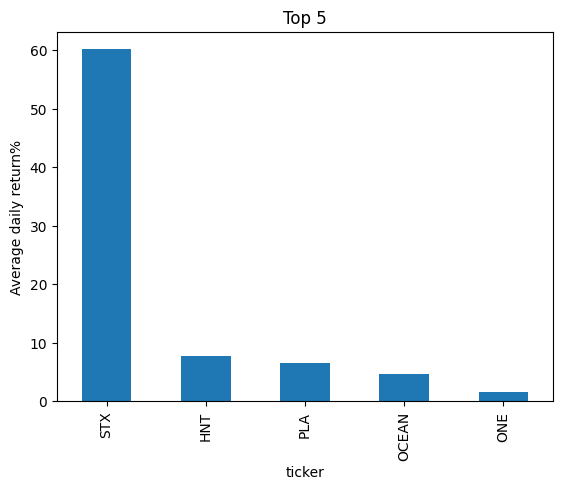

In [10]:
#Calculating 1-day return
df_prices['return'] = df_prices.groupby(['ticker'])['close'].pct_change()
df_prices = df_prices.reset_index(drop=True)

df_prices = df_prices.dropna() 

#Calculating mean of 1-day returns for each currency and selecting 5 stocks with highest mean return                           
df_returns = (df_prices.groupby('ticker')['return'].mean())*100
print(df_returns.head())
df_top_returns = df_returns.nlargest(5)
print(df_top_returns)
df_top_returns.plot.bar()
plt.xlabel('ticker')
plt.ylabel('Average daily return%')
plt.title("Top 5")
print("Average daily return:", df_returns.mean(), "%")

The mean daily return is 0.67%. The top 5 currencies, in terms of highest average daily return are  unknown currencies. 

### Selected cryptocurrencies

In [11]:
#Selected tickers dataset 
df_tickers = pd.read_csv('./dataset/tickers.csv', index_col = 0)
#df_tickers[~ df_tickers['ticker'].isin(df_prices['ticker'])]
# remove tickers with late listing and without history
df_tickers = df_tickers[~ df_tickers['ticker'].isin(['TON', 'OP', 'ICP', 'SHIB', 'IMX', 'INJ'])]
df_tickers = df_tickers.head(10)
print(df_tickers.shape)
df_tickers.T

(10, 1)


#        1    2    3    4    5    6     7     8     9    10
ticker  BTC  ETH  BNB  SOL  XRP  ADA  AVAX  LINK  DOGE  TRX

ticker
SOL     0.602185
DOGE    0.503403
XRP     0.471374
BTC     0.464694
LINK    0.414312
BNB     0.414201
TRX     0.408161
AVAX    0.393316
ETH     0.393236
ADA     0.150454
Name: return, dtype: float64
df_top_returns shape: (10,)
Average daily return: 0.671750107003616 %


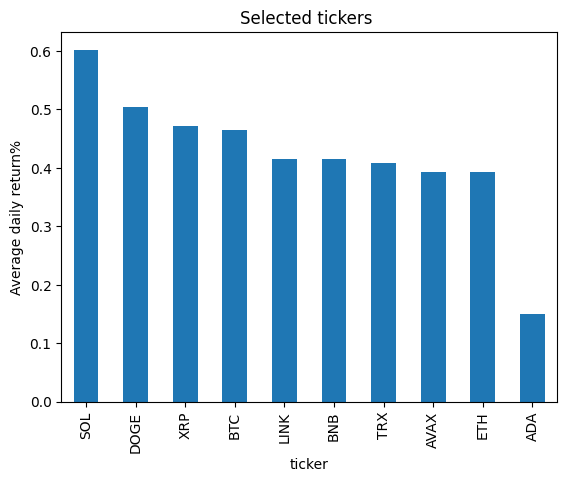

In [12]:
df_top_returns = df_returns[df_returns.index.isin(df_tickers['ticker'])].sort_values(ascending = False)
print(df_top_returns)
print("df_top_returns shape:", df_top_returns.shape)
df_top_returns.plot.bar()
plt.xlabel('ticker')
plt.ylabel('Average daily return%')
plt.title("Selected tickers ")
print("Average daily return:", df_returns.mean(), "%")

# Finding correlation between the currencies

In [13]:
df_selected_prices = df_prices[df_prices['ticker'].isin(df_tickers['ticker'])]
print(df_selected_prices.head())
df_selected_prices['ticker'].unique()

     ticker       date    open   high     low   close    return
2470    ADA 2017-12-31  0.5900  0.740  0.5900  0.7100  0.203390
2471    ADA 2018-01-01  0.7100  0.715  0.6320  0.7022 -0.010986
2472    ADA 2018-01-02  0.7022  0.800  0.6750  0.7620  0.085161
2473    ADA 2018-01-03  0.7620  1.100  0.7601  1.1000  0.443570
2474    ADA 2018-01-04  1.1100  1.380  1.0400  1.1300  0.027273


array(['ADA', 'AVAX', 'BNB', 'BTC', 'DOGE', 'ETH', 'LINK', 'SOL', 'TRX',
       'XRP'], dtype=object)

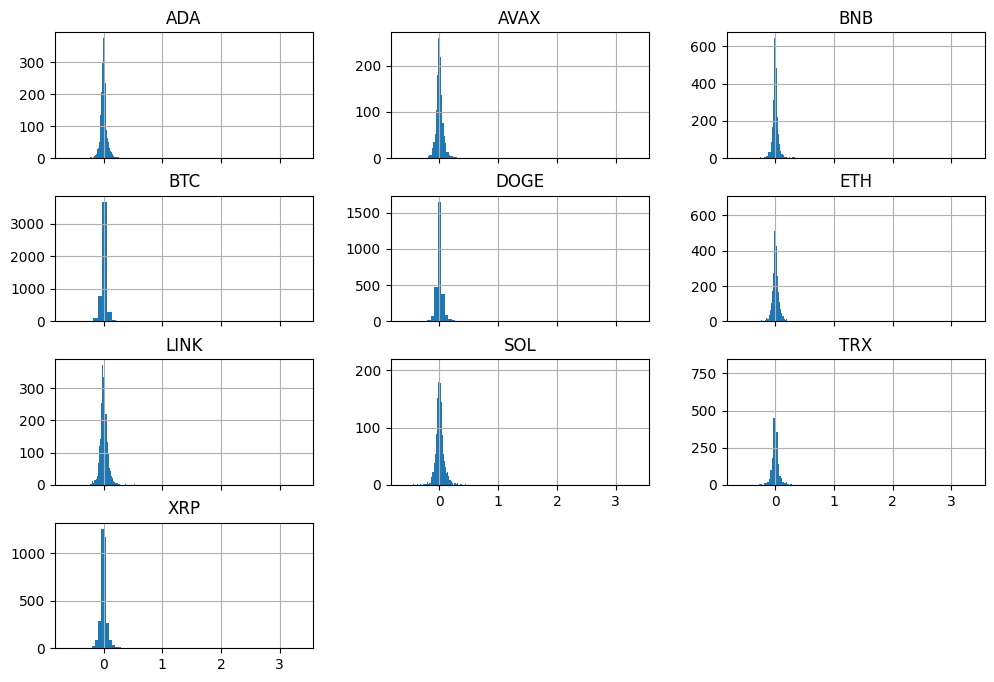

In [14]:
df_sel_prices_pivoted = df_selected_prices.pivot(index='date', columns='ticker', values=['close'])
df_sel_prices_pivoted.columns = [col[1] for col in df_sel_prices_pivoted.columns.values]
df_daily_pct_change = df_sel_prices_pivoted.pct_change()
df_daily_pct_change.hist(bins=50, sharex=True, figsize=(12,8))
plt.show()

In [15]:
#df_sel_prices_pivoted = df_selected_prices.pivot(index='date', columns='ticker', values=['close'])
#df_sel_prices_pivoted.columns = [col[1] for col in df_sel_prices_pivoted.columns.values]
df_sel_prices_pivoted = df_sel_prices_pivoted.dropna()
#df_sel_prices_pivoted = df_sel_prices_pivoted.rename_axis(None, axis=1).rename_axis(None, axis=0)
df_sel_prices_pivoted.reset_index()
df_sel_prices_pivoted.head(10)


ADA   AVAX    BNB      BTC      DOGE     ETH    LINK    SOL  \
date                                                                          
2020-09-23  0.07744  3.525  23.10  10260.0  0.002565  322.90   8.003  2.858   
2020-09-24  0.08305  4.590  24.15  10651.6  0.002663  346.05   9.799  3.146   
2020-09-25  0.09751  4.718  24.83  10752.9  0.002688  357.35  11.000  3.197   
2020-09-26  0.09473  4.529  26.33  10730.6  0.002683  353.19  10.160  3.135   
2020-09-27  0.10110  4.657  25.89  10726.6  0.002682  353.29  10.630  3.164   
2020-09-28  0.10330  4.206  27.62  10890.1  0.002614  363.63  10.650  2.963   
2020-09-29  0.10000  4.143  28.50  10770.6  0.002585  357.67   9.756  2.953   
2020-09-30  0.10000  4.333  29.12  10708.3  0.002570  357.22   9.798  2.900   
2020-10-01  0.09722  4.154  27.22  10592.9  0.002648  351.32   9.489  2.870   
2020-10-02  0.09179  3.916  26.80  10477.2  0.002619  342.13   9.026  2.626   

                TRX     XRP  
date                         
2020-09-23  0.02495  0.2246  
2020-09-24  0.02589  0.2324  
2020-09-25  0.02743  0.2441  
2020-09-26  0.02745  0.2416  
2020-09-27  0.02641  0.2418  
2020-09-28  0.02689  0.2463  
2020-09-29  0.02596  0.2414  
2020-09-30  0.02611  0.2394  
2020-10-01  0.02545  0.2373  
2020-10-02  0.02566  0.2315

<Axes: >

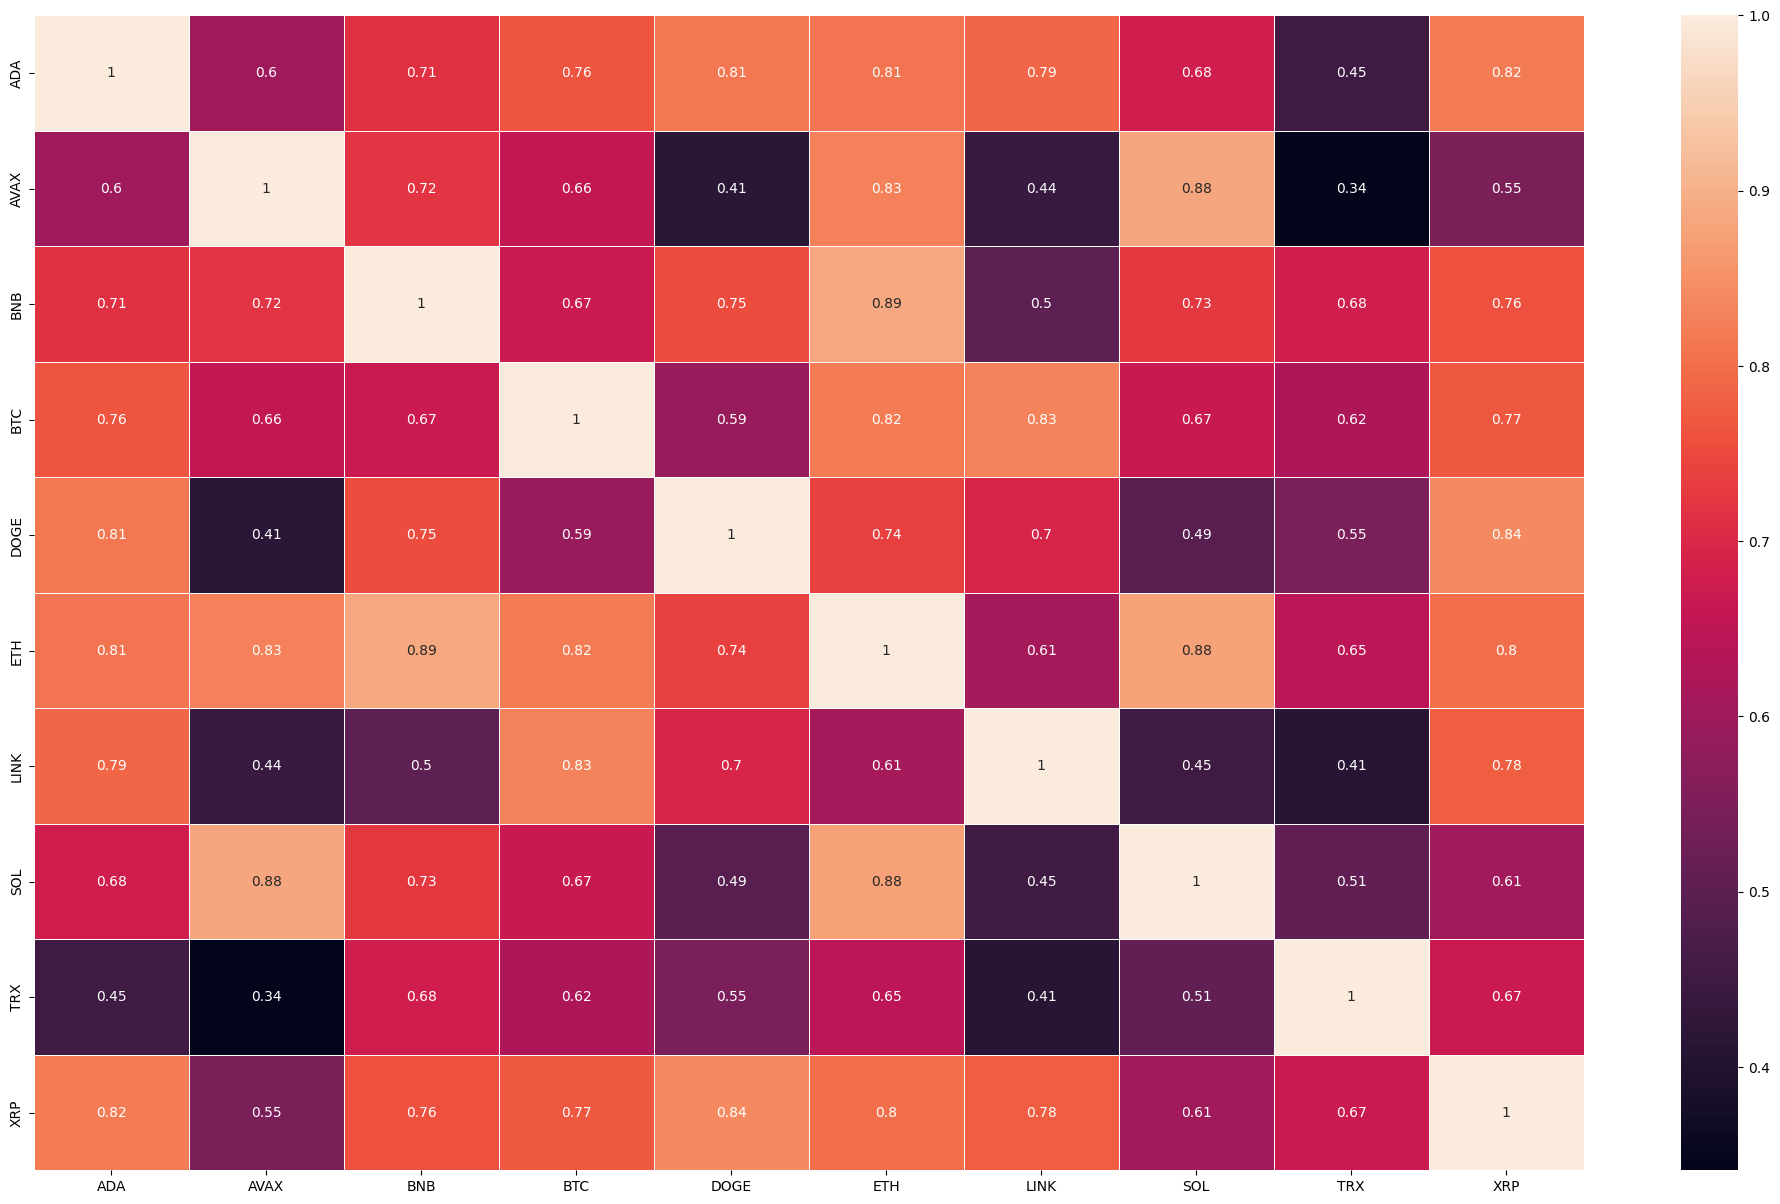

In [16]:
plt.figure(figsize = (25,15))
sns.heatmap(df_sel_prices_pivoted.corr(), annot=True, linewidths=.5)


# Creating a dataframe containing  'cumulative returns' of selected currencies and plotting their returns against CCi30 index return. 


In [17]:
#df_selected_prices[df_selected_prices['ticker'] == 'BTC']['cum_returns'].plot(figsize=(12,8))
#plt.show()
print('min date of selected prices', df_selected_prices.date.min())
print('max date of selected prices', df_selected_prices.date.max())
df_selected_prices.groupby('ticker')['date'].agg(['min', 'max', 'count']).sort_values(by = 'min')

min date of selected prices 2010-07-18 00:00:00
max date of selected prices 2024-02-14 00:00:00


min        max  count
ticker                             
BTC    2010-07-18 2024-02-14   4960
XRP    2015-01-22 2024-02-14   3308
ETH    2015-08-08 2024-02-14   3113
DOGE   2016-07-02 2024-02-14   2784
BNB    2017-09-09 2024-02-14   2350
LINK   2017-09-29 2024-02-14   2328
TRX    2017-10-11 2024-02-14   2318
ADA    2017-12-31 2024-02-14   2237
SOL    2020-04-11 2024-02-14   1405
AVAX   2020-09-23 2024-02-14   1239

In [18]:
df_ret_pivoted = df_selected_prices.pivot(index='date', columns='ticker', values=['return'])
df_ret_pivoted.columns = [col[1] for col in df_ret_pivoted.columns.values]
df_ret_pivoted = df_ret_pivoted.dropna()
df_ret_pivoted.head()

ADA      AVAX       BNB       BTC      DOGE       ETH  \
date                                                                     
2020-09-23 -0.058022 -0.328571 -0.042685 -0.027580 -0.027672 -0.068163   
2020-09-24  0.072443  0.302128  0.045455  0.038168  0.038207  0.071694   
2020-09-25  0.174112  0.027887  0.028157  0.009510  0.009388  0.032654   
2020-09-26 -0.028510 -0.040059  0.060411 -0.002074 -0.001860 -0.011641   
2020-09-27  0.067244  0.028262 -0.016711 -0.000373 -0.000373  0.000283   

                LINK       SOL       TRX       XRP  
date                                                
2020-09-23 -0.087249 -0.018207 -0.003594 -0.041400  
2020-09-24  0.224416  0.100770  0.037675  0.034728  
2020-09-25  0.122564  0.016211  0.059482  0.050344  
2020-09-26 -0.076364 -0.019393  0.000729 -0.010242  
2020-09-27  0.046260  0.009250 -0.037887  0.000828

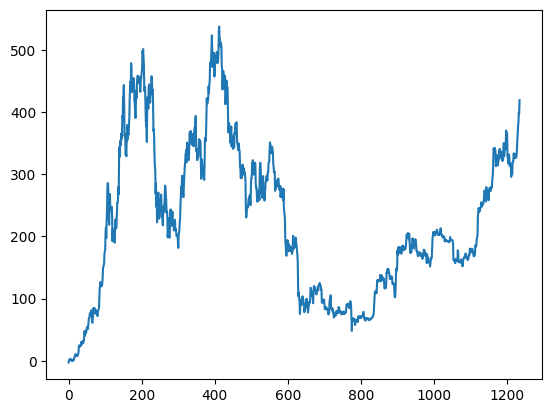

min date of selected prices 2020-09-23 00:00:00
max date of selected prices 2024-02-14 00:00:00


In [19]:
# Calculate the cumulative daily returns
df_cum_daily_returns = (1 + df_ret_pivoted).cumprod() - 1
df_cum_daily_returns = df_cum_daily_returns.reset_index()
df_cum_daily_returns.head()
#df_cum_daily_returns['BTC'].plot(figsize=(12,8))
(df_cum_daily_returns['BTC']*100).plot(label='BTC')
plt.show()
print('min date of selected prices', df_ret_pivoted.index.min())
print('max date of selected prices', df_ret_pivoted.index.max())

# Importing CCi30 index data to compare the return of selected currencies

The data frame df_cci30 contains data for S&P index from 2015-01-01 to 2024-02-10 

In [20]:
#Dataset 2: CCi30 index
df_cci30 = pd.read_csv('./dataset/cci30_OHLCV.csv').sort_values(by = 'Date')
#df_cci30 = df_cci30.drop(columns = {'open', 'high', 'low'})
df_cci30 = df_cci30.drop_duplicates()
print(df_cci30.head())
#min and max dates
print("Min date of dataset: ", df_cci30.Date.min())
print("Max date of dataset: ", df_cci30.Date.max())

            Date      Open      High      Low     Close  Volume
3331  2015-01-01  101.3600  102.1530  98.8187  100.0000     0.0
3330  2015-01-02   99.9137  101.8690  98.7938  100.2180     0.0
3329  2015-01-03  100.2530  101.5400  88.7442   89.3769     0.0
3328  2015-01-04   89.2479   91.1656  79.8710   82.2132     0.0
3327  2015-01-05   82.3484   88.3190  81.5787   86.2289     0.0
Min date of dataset:  2015-01-01
Max date of dataset:  2024-02-14


In [21]:
#min date of selected prices 2022-05-16
#max date of selected prices 2024-02-14
df_cci30 = df_cci30[(df_cci30['Date'] >= '2020-09-25') & (df_cci30['Date'] <= '2024-02-14')]
print(df_cci30.head())
print(df_cci30['Date'].agg(['min', 'max', 'count']))

            Date     Open     High      Low    Close        Volume
1237  2020-09-25  4300.66  4433.18  4209.61  4367.60  4.855201e+10
1236  2020-09-26  4370.11  4481.98  4316.45  4414.92  4.466020e+10
1235  2020-09-27  4414.08  4514.62  4323.32  4443.38  4.312653e+10
1234  2020-09-28  4443.20  4567.19  4383.45  4412.88  4.829366e+10
1233  2020-09-29  4411.30  4512.15  4349.71  4478.04  4.425796e+10
min      2020-09-25
max      2024-02-14
count          1238
Name: Date, dtype: object


In [22]:
df_cci30 = df_cci30.drop(columns = {'Date', 'Open', 'High', 'Low', 'Volume'})
df_cci30['returns'] = df_cci30['Close'].pct_change()
df_cci30 = df_cci30.dropna()

#Calculating cummulative returns of index
df_cci30['cum_returns'] = (1 + df_cci30['returns']).cumprod() - 1
df_cci30 = df_cci30.drop(columns = {'Close','returns'})
df_cci30 = df_cci30.dropna()
df_cci30 = df_cci30.reset_index()
print(df_cci30.head())
print(df_cum_daily_returns.head())

   index  cum_returns
0   1236     0.010834
1   1235     0.017350
2   1234     0.010367
3   1233     0.025286
4   1232     0.026200
        date       ADA      AVAX       BNB       BTC      DOGE       ETH  \
0 2020-09-23 -0.058022 -0.328571 -0.042685 -0.027580 -0.027672 -0.068163   
1 2020-09-24  0.010218 -0.125714  0.000829  0.009535  0.009477 -0.001356   
2 2020-09-25  0.186109 -0.101333  0.029010  0.019136  0.018954  0.031254   
3 2020-09-26  0.152293 -0.137333  0.091173  0.017022  0.017058  0.019249   
4 2020-09-27  0.229777 -0.112952  0.072938  0.016643  0.016679  0.019537   

       LINK       SOL       TRX       XRP  
0 -0.087249 -0.018207 -0.003594 -0.041400  
1  0.117587  0.080728  0.033946 -0.008109  
2  0.254562  0.098248  0.095447  0.041827  
3  0.158759  0.076950  0.096246  0.031157  
4  0.212363  0.086912  0.054712  0.032010  


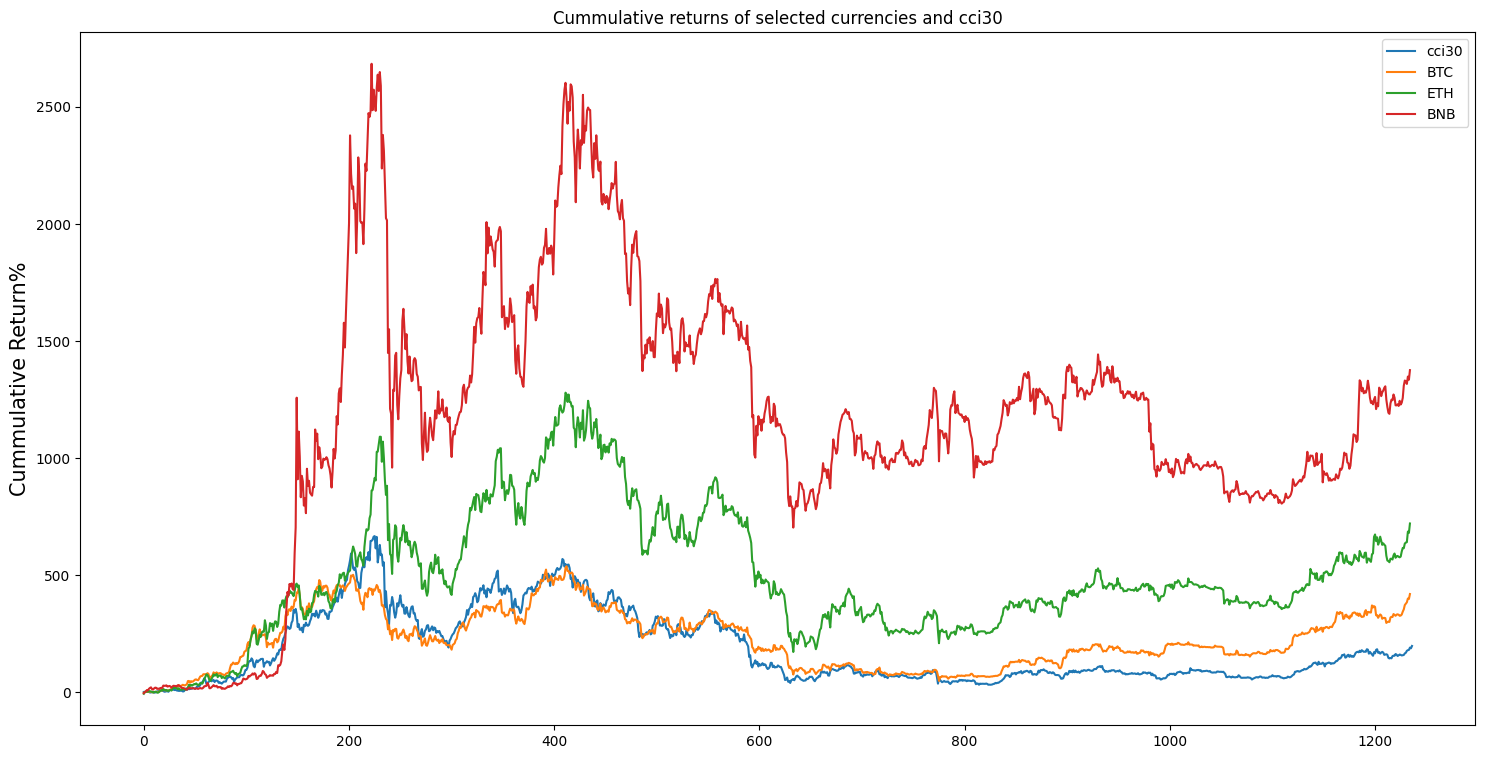

In [23]:
plt.figure(figsize = (18,9))

(df_cci30['cum_returns']*100).plot(label='cci30')
(df_cum_daily_returns['BTC']*100).plot(label='BTC')
(df_cum_daily_returns['ETH']*100).plot(label='ETH')
(df_cum_daily_returns['BNB']*100).plot(label='BNB')
plt.ylabel('Cummulative Return%', fontsize=15)
plt.legend()
plt.title('Cummulative returns of selected currencies and cci30')
plt.show()

# Machine learning for Modern Portfolio Theory
https://github.com/stefan-jansen/machine-learning-for-trading/tree/main

In [24]:
prices = df_selected_prices.pivot(index='date', columns='ticker', values=['close'])
prices.columns = [col[1] for col in prices.columns.values]
prices.index = pd.to_datetime(prices.index)
prices.reset_index()
print(prices.shape)
prices.head(10)

(4960, 10)


ADA  AVAX  BNB      BTC  DOGE  ETH  LINK  SOL  TRX  XRP
date                                                               
2010-07-18  NaN   NaN  NaN  0.08584   NaN  NaN   NaN  NaN  NaN  NaN
2010-07-19  NaN   NaN  NaN  0.08080   NaN  NaN   NaN  NaN  NaN  NaN
2010-07-20  NaN   NaN  NaN  0.07474   NaN  NaN   NaN  NaN  NaN  NaN
2010-07-21  NaN   NaN  NaN  0.07921   NaN  NaN   NaN  NaN  NaN  NaN
2010-07-22  NaN   NaN  NaN  0.05050   NaN  NaN   NaN  NaN  NaN  NaN
2010-07-23  NaN   NaN  NaN  0.06262   NaN  NaN   NaN  NaN  NaN  NaN
2010-07-24  NaN   NaN  NaN  0.05454   NaN  NaN   NaN  NaN  NaN  NaN
2010-07-25  NaN   NaN  NaN  0.05050   NaN  NaN   NaN  NaN  NaN  NaN
2010-07-26  NaN   NaN  NaN  0.05600   NaN  NaN   NaN  NaN  NaN  NaN
2010-07-27  NaN   NaN  NaN  0.06000   NaN  NaN   NaN  NaN  NaN  NaN

Compute return

In [25]:
print('min date of selected prices', prices.index.min())
print('max date of selected prices', prices.index.max())

min date of selected prices 2010-07-18 00:00:00
max date of selected prices 2024-02-14 00:00:00


In [26]:
start = 2020
end = 2025
weekly_returns = prices.loc[f'{start}':f'{end}'].resample('W').last().pct_change().dropna(how='all')
weekly_returns = weekly_returns.dropna()
#weekly_returns = weekly_returns.dropna(axis=1)
weekly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 177 entries, 2020-10-04 to 2024-02-18
Freq: W-SUN
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ADA     177 non-null    float64
 1   AVAX    177 non-null    float64
 2   BNB     177 non-null    float64
 3   BTC     177 non-null    float64
 4   DOGE    177 non-null    float64
 5   ETH     177 non-null    float64
 6   LINK    177 non-null    float64
 7   SOL     177 non-null    float64
 8   TRX     177 non-null    float64
 9   XRP     177 non-null    float64
dtypes: float64(10)
memory usage: 15.2 KB


In [27]:
print(weekly_returns.shape)
weekly_returns.head()

(177, 10)


ADA      AVAX       BNB       BTC      DOGE       ETH  \
date                                                                     
2020-10-04 -0.039960 -0.147949  0.112012 -0.006796 -0.007084 -0.004048   
2020-10-11  0.097259  0.033266 -0.009726  0.063339  0.021029  0.060109   
2020-10-18  0.001878  0.005854  0.072957  0.011899 -0.030158  0.008498   
2020-10-25 -0.002812  0.006062 -0.017653  0.135868  0.036784  0.080121   
2020-11-01 -0.084211 -0.112798 -0.058902  0.052024 -0.047915 -0.026703   

                LINK       SOL       TRX       XRP  
date                                                
2020-10-04 -0.119661 -0.202592  0.000757  0.022333  
2020-10-11  0.146613 -0.038843  0.002270  0.031149  
2020-10-18  0.012116 -0.086186 -0.021518 -0.049039  
2020-10-25  0.117864 -0.189982  0.040123  0.042492  
2020-11-01 -0.056013 -0.104178 -0.042656 -0.049861

### Set  Parameters

In [28]:
currencies = weekly_returns.columns

In [29]:
n_obs, n_currencies = weekly_returns.shape
n_currencies, n_obs

(10, 177)

In [30]:
NUM_PF = 100000 # no of portfolios to simulate

In [31]:
x0 = uniform(0, 1, n_currencies)
x0 /= np.sum(np.abs(x0))
x0


array([0.07829944, 0.08782881, 0.10365729, 0.03677808, 0.13695567,
       0.07977909, 0.14487218, 0.08088813, 0.07130965, 0.17963167])

### Annualization Factor

In [34]:
periods_per_year = round(weekly_returns.resample('A').size().mean())
periods_per_year

35

In [35]:
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov_matrix), index=currencies, columns=currencies)

### Risk-Free Rate

Load historical 10-year Treasury rate:

In [36]:
treasury_10yr_weekly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('W')
                         .last()
                         .div(periods_per_year)
                         .div(100)
                         .squeeze())

In [37]:
rf_rate = treasury_10yr_weekly.mean()
rf_rate

0.0006764682539682538

## Simulate Random Portfolios

The simulation generates random weights using the Dirichlet distribution, and computes the mean, standard deviation, and SR for each sample portfolio using the historical return data:

In [38]:
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=False):
    alpha = np.full(shape=n_currencies, fill_value=.05)
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    if short:
        weights *= choice([-1, 1], size=weights.shape)

    returns = weights @ mean_ret.values + 1
    returns = returns ** periods_per_year - 1
    std = (weights @ weekly_returns.T).std(1)
    std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std
    return pd.DataFrame({'Annualized Standard Deviation': std,
                         'Annualized Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

In [39]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [40]:
df = pd.DataFrame(simul_wt)
df.describe()

0              1             2              3  \
count   1.000000e+05   1.000000e+05  1.000000e+05   1.000000e+05   
mean    9.928888e-02   1.010349e-01  9.891389e-02   1.000489e-01   
std     2.439083e-01   2.459212e-01  2.428119e-01   2.443315e-01   
min    4.440411e-106  3.981271e-109  2.600835e-93  1.589099e-105   
25%     4.225224e-12   5.160347e-12  4.625278e-12   5.046544e-12   
50%     4.590266e-06   5.177931e-06  4.610242e-06   4.552523e-06   
75%     1.527786e-02   1.599159e-02  1.478929e-02   1.494740e-02   
max     1.000000e+00   1.000000e+00  1.000000e+00   1.000000e+00   

                  4              5             6             7              8  \
count  1.000000e+05   1.000000e+05  1.000000e+05  1.000000e+05   1.000000e+05   
mean   1.003691e-01   1.009593e-01  1.010579e-01  1.003007e-01   9.933655e-02   
std    2.444070e-01   2.462117e-01  2.458399e-01  2.454841e-01   2.439751e-01   
min    6.429326e-98  8.811870e-106  5.660420e-95  4.240015e-99  8.773477e-104   
25%    4.798280e-12   4.818724e-12  4.657754e-12  4.557507e-12   3.785104e-12   
50%    4.885229e-06   5.074826e-06  4.561781e-06  4.346915e-06   4.328836e-06   
75%    1.593100e-02   1.577565e-02  1.602344e-02  1.550598e-02   1.518386e-02   
max    1.000000e+00   1.000000e+00  1.000000e+00  1.000000e+00   1.000000e+00   

                   9  
count   1.000000e+05  
mean    9.868987e-02  
std     2.431102e-01  
min    1.935126e-111  
25%     4.275643e-12  
50%     4.423101e-06  
75%     1.426238e-02  
max     1.000000e+00

In [41]:
df

0             1             2             3             4  \
0      4.734462e-02  7.001526e-05  4.015532e-17  8.889911e-07  9.471658e-01   
1      2.877800e-01  4.658218e-02  1.997231e-12  2.641057e-04  4.629435e-02   
2      3.116585e-09  6.496898e-19  4.075255e-02  3.888492e-04  1.112396e-06   
3      1.860120e-01  4.259239e-01  1.544503e-04  1.285616e-02  6.056167e-20   
4      7.091550e-05  7.333991e-09  8.289111e-02  1.360206e-41  4.507915e-15   
...             ...           ...           ...           ...           ...   
99995  4.866003e-16  4.458057e-26  3.125980e-04  7.472965e-01  1.587642e-05   
99996  7.603841e-21  1.428845e-07  7.554542e-07  3.319474e-01  2.103883e-02   
99997  1.282610e-15  2.000094e-02  7.480749e-11  9.423041e-11  1.290608e-17   
99998  1.256250e-20  9.548660e-09  1.674479e-02  1.799188e-13  9.338082e-01   
99999  1.147547e-17  2.083435e-02  1.458339e-03  2.491343e-04  6.004860e-03   

                  5             6             7             8             9  
0      5.794282e-14  5.357606e-03  5.772392e-47  1.033540e-14  6.105875e-05  
1      1.099756e-10  4.232404e-01  3.163727e-10  1.958389e-01  1.476914e-15  
2      1.544981e-01  2.872267e-13  3.843173e-10  8.043594e-01  6.755110e-10  
3      4.573699e-16  4.648615e-07  7.930410e-02  2.957489e-01  2.750050e-11  
4      3.387206e-27  1.505466e-13  8.888068e-01  2.792781e-02  3.033969e-04  
...             ...           ...           ...           ...           ...  
99995  3.337176e-04  2.520395e-01  6.037491e-16  2.692513e-08  1.746942e-06  
99996  1.317946e-03  5.627112e-01  2.534164e-08  4.093911e-02  4.204462e-02  
99997  1.500080e-04  4.230232e-04  5.466560e-02  1.291975e-02  9.118407e-01  
99998  1.769759e-05  4.306356e-07  1.395979e-14  2.783574e-08  4.942882e-02  
99999  4.371777e-23  2.346470e-03  1.463018e-08  1.574720e-05  9.690911e-01  

[100000 rows x 10 columns]

### Plot Simulated Portfolios

Max Sharpe: 121.68%, 338.52%


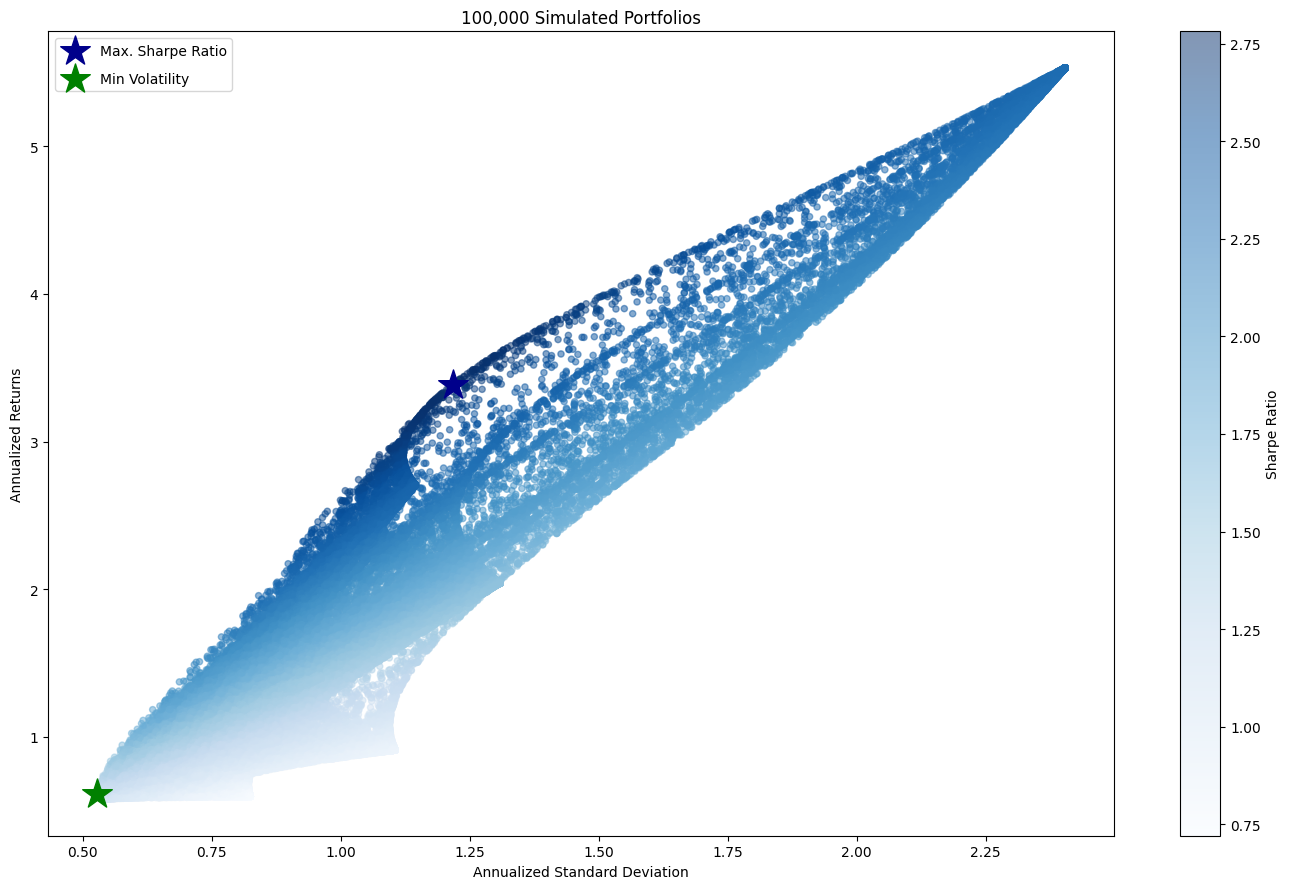

In [42]:
ax = simul_perf.plot.scatter(x=0, y=1, c=2, cmap='Blues',
                             alpha=0.5, figsize=(14, 9), colorbar=True,
                             title=f'{NUM_PF:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
print(f'Max Sharpe: {sd:.2%}, {r:.2%}')
ax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

## Compute Annualize PF Performance

Now we'll set up the quadratic optimization problem to solve for the minimum standard deviation for a given return or the maximum SR.

To this end, define the functions that measure the key metrics:

In [43]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year)

In [44]:
def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1

In [45]:
def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

## Max Sharpe PF

Define a target function that represents the negative SR for scipy's minimize function to optimize, given the constraints that the weights are bounded by [-1, 1], if short trading is permitted, and [0, 1] otherwise, and sum to one in absolute terms.

In [46]:
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

In [47]:
weight_constraint = {'type': 'eq', 
                     'fun': lambda x: np.sum(np.abs(x))-1}

In [48]:
def max_sharpe_ratio(mean_ret, cov, short=False):
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_currencies,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

## Compute Efficient Frontier

The solution requires iterating over ranges of acceptable values to identify optimal risk-return combinations

In [49]:
def min_vol_target(mean_ret, cov, target, short=False):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    constraints = [{'type': 'eq',
                    'fun': lambda x: ret_(x) - target},
                   weight_constraint]

    bounds = ((-1 if short else 0, 1),) * n_currencies
    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

The mean-variance frontier relies on in-sample, backward-looking optimization. In practice, portfolio optimization requires forward-looking input. Unfortunately, expected returns are notoriously difficult to estimate accurately.

The covariance matrix can be estimated somewhat more reliably, which has given rise to several alternative approaches. However, covariance matrices with correlated assets pose computational challenges since the optimization problem requires inverting the matrix. The high condition number induces numerical instability, which in turn gives rise to Markovitz curse: the more diversification is required (by correlated investment opportunities), the more unreliable the weights produced by the algorithm. 

## Min Volatility Portfolio

In [50]:
def min_vol(mean_ret, cov, short=False):
    bounds = ((-1 if short else 0, 1),) * n_currencies

    return minimize(fun=portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

In [51]:
def efficient_frontier(mean_ret, cov, ret_range, short=False):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

## Run Calculation

### Get random PF

In [52]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [53]:
print(simul_perf.describe())

       Annualized Standard Deviation  Annualized Returns   Sharpe Ratio
count                  100000.000000       100000.000000  100000.000000
mean                        0.966700            1.541177       1.478773
std                         0.394587            1.111722       0.466050
min                         0.526933            0.576734       0.720591
25%                         0.720471            0.854229       1.114125
50%                         0.862789            1.079831       1.411336
75%                         1.079683            1.905304       1.756395
max                         2.404390            5.531520       2.781444


In [54]:
simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
simul_perf.iloc[simul_max_sharpe]

Annualized Standard Deviation    1.214720
Annualized Returns               3.379352
Sharpe Ratio                     2.781444
Name: 95550, dtype: float64

### Get Max Sharpe PF

In [55]:
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

In [56]:
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret    3.375430
sd     1.213293
sr     2.781483
dtype: float64

### Get Min Vol PF

In [57]:
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)

### Get Efficent PFs

In [58]:
ret_range = np.linspace(simul_perf.iloc[:, 1].min(), simul_perf.iloc[:, 1].max(), 50)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range, short=True)
eff_pf = pd.Series(dict(zip([p['fun'] for p in eff_pf], ret_range)))

### Plot Result

The simulation yields a subset of the feasible portfolios, and the efficient frontier identifies the optimal in-sample return-risk combinations that were achievable given historic data. 

The below figure shows the result including the minimum variance portfolio and the portfolio that maximizes the SR and several portfolios produce by alternative optimization strategies. The efficient frontier 

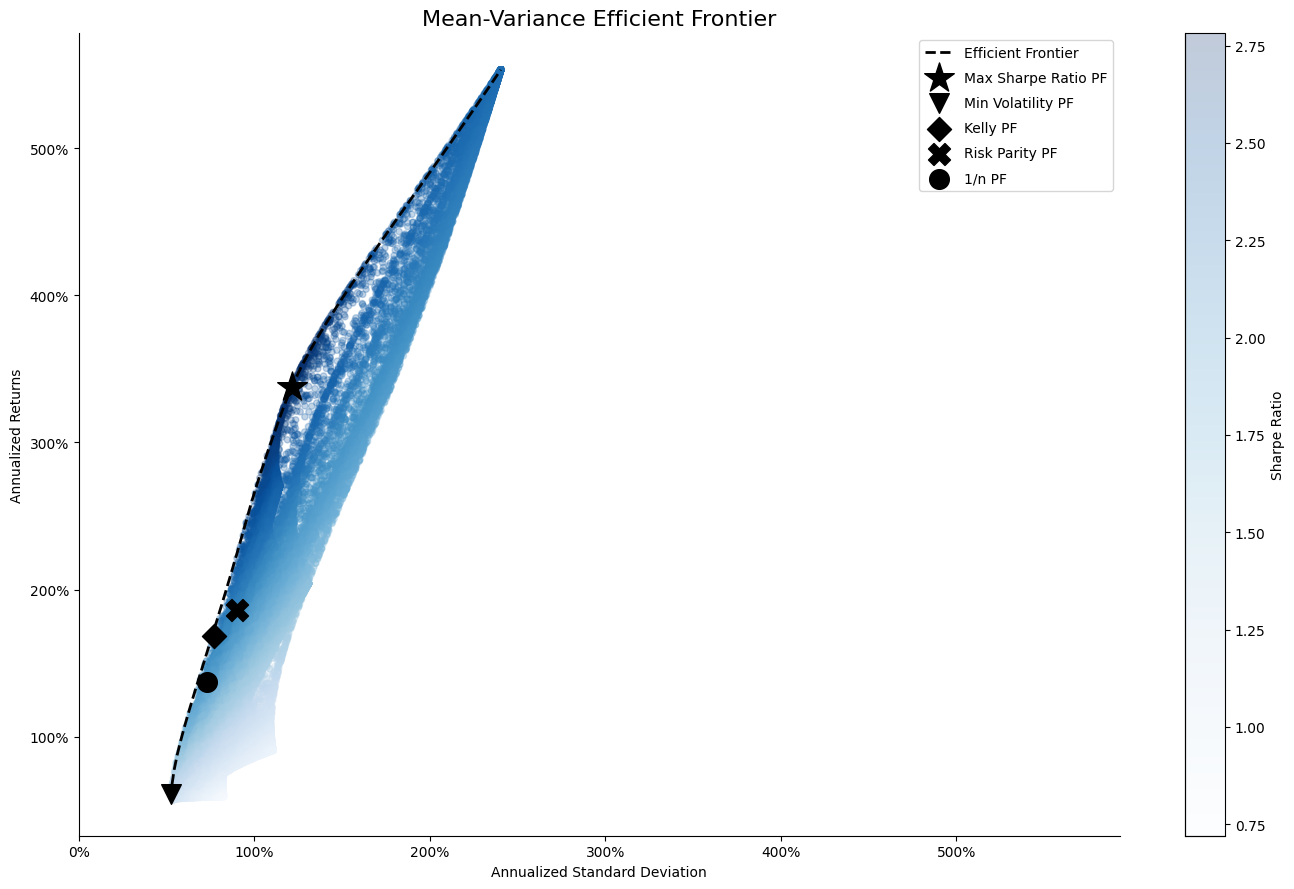

In [59]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax, cmap='Blues',alpha=0.25, 
                        figsize=(14, 9), colorbar=True)

eff_pf[eff_pf.index.min():].plot(linestyle='--', lw=2, ax=ax, c='k',
                                 label='Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='k', s=500, label='Max Sharpe Ratio PF')

r, sd = min_vol_perf
ax.scatter(sd, r, marker='v', color='k', s=200, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).clip(lower=0).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='D', color='k', s=150, label='Kelly PF')

std = weekly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='X', color='k', s=250, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_currencies, 1/n_currencies), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='o', color='k', s=200, label='1/n PF')


ax.legend(labelspacing=0.8)
ax.set_xlim(0, eff_pf.max()+.4)
ax.set_title('Mean-Variance Efficient Frontier', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();

# Random Forest

In [60]:
ticker_values = df_sel_prices_pivoted
#ticker_values = weekly_returns
print(ticker_values.shape)
ticker_values.head(11)

(1235, 10)


ADA   AVAX    BNB      BTC      DOGE     ETH    LINK    SOL  \
date                                                                          
2020-09-23  0.07744  3.525  23.10  10260.0  0.002565  322.90   8.003  2.858   
2020-09-24  0.08305  4.590  24.15  10651.6  0.002663  346.05   9.799  3.146   
2020-09-25  0.09751  4.718  24.83  10752.9  0.002688  357.35  11.000  3.197   
2020-09-26  0.09473  4.529  26.33  10730.6  0.002683  353.19  10.160  3.135   
2020-09-27  0.10110  4.657  25.89  10726.6  0.002682  353.29  10.630  3.164   
2020-09-28  0.10330  4.206  27.62  10890.1  0.002614  363.63  10.650  2.963   
2020-09-29  0.10000  4.143  28.50  10770.6  0.002585  357.67   9.756  2.953   
2020-09-30  0.10000  4.333  29.12  10708.3  0.002570  357.22   9.798  2.900   
2020-10-01  0.09722  4.154  27.22  10592.9  0.002648  351.32   9.489  2.870   
2020-10-02  0.09179  3.916  26.80  10477.2  0.002619  342.13   9.026  2.626   
2020-10-03  0.09351  4.021  28.01  10578.9  0.002645  349.21   9.391  2.547   

                TRX     XRP  
date                         
2020-09-23  0.02495  0.2246  
2020-09-24  0.02589  0.2324  
2020-09-25  0.02743  0.2441  
2020-09-26  0.02745  0.2416  
2020-09-27  0.02641  0.2418  
2020-09-28  0.02689  0.2463  
2020-09-29  0.02596  0.2414  
2020-09-30  0.02611  0.2394  
2020-10-01  0.02545  0.2373  
2020-10-02  0.02566  0.2315  
2020-10-03  0.02828  0.2339

In [61]:
ticker_values['ADA']

date
2020-09-23    0.07744
2020-09-24    0.08305
2020-09-25    0.09751
2020-09-26    0.09473
2020-09-27    0.10110
               ...   
2024-02-10    0.55170
2024-02-11    0.54180
2024-02-12    0.55960
2024-02-13    0.54520
2024-02-14    0.57750
Name: ADA, Length: 1235, dtype: float64

In [63]:
from sklearn.preprocessing import MinMaxScaler

ticker_data = {}

NUM_FEATURES = 60

for ticker in ticker_values.columns:    
    ticker_data[ticker] = {}
    X, Y = [], []
    sc = MinMaxScaler(feature_range=(0,1))
    scaled_values = np.array(ticker_values[ticker])
    scaled_values = scaled_values.reshape(scaled_values.shape[0],1)
    scaled_values = sc.fit_transform(scaled_values)
    #print(scaled_values)
    ticker_data[ticker]['Scaler'] = sc

    for i in range(0, len(ticker_values) - NUM_FEATURES, 1):
        #x = ticker_values[ticker][i:(i+NUM_FEATURES)].T.to_numpy()
        #y = ticker_values[ticker][i+NUM_FEATURES:i+NUM_FEATURES + 1].to_numpy()
        x = scaled_values[i:(i+NUM_FEATURES), 0]
        y = scaled_values[i+NUM_FEATURES:i+NUM_FEATURES + 1, 0]
        X.append(x)
        Y.append(y)
        #if i == 2:
        #    break
    X, Y = np.array(X), np.array(Y)
    #X = np.concatenate(X)
    Y = np.concatenate(Y)
    ticker_data[ticker]['X'] = X
    ticker_data[ticker]['Y'] = Y

#print(ticker_data['ADA']['X'])
#print(100*'-')
#print(ticker_data['ADA']['Y'])
print((ticker_data['ADA']['X']).shape)        
print((ticker_data['ADA']['Y']).shape)
       
# Convert the x_train and y_train to numpy arrays 
#X, Y = np.array(X), np.array(Y)

(1175, 60)
(1175,)


In [64]:
from sklearn.model_selection import train_test_split

for ticker in ticker_values.columns:
    X_train, X_test, y_train, y_test = train_test_split(ticker_data[ticker]['X'], ticker_data[ticker]['Y'], train_size=0.8, shuffle=False)
    ticker_data[ticker]['X_train'] = X_train
    ticker_data[ticker]['X_test'] = X_test
    ticker_data[ticker]['y_train'] = y_train
    ticker_data[ticker]['y_test'] = y_test

arr_buff = []
for ticker in ticker_values.columns:
    buff = {}
    buff["X_train"] = ticker_data[ticker]['X_train'].shape
    buff["X_test"] = ticker_data[ticker]['X_test'].shape
    buff["y_train"] = ticker_data[ticker]['y_train'].shape
    buff["y_test"] = ticker_data[ticker]['y_test'].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=weekly_returns.columns)

X_train     X_test y_train  y_test
ADA   (940, 60)  (235, 60)  (940,)  (235,)
AVAX  (940, 60)  (235, 60)  (940,)  (235,)
BNB   (940, 60)  (235, 60)  (940,)  (235,)
BTC   (940, 60)  (235, 60)  (940,)  (235,)
DOGE  (940, 60)  (235, 60)  (940,)  (235,)
ETH   (940, 60)  (235, 60)  (940,)  (235,)
LINK  (940, 60)  (235, 60)  (940,)  (235,)
SOL   (940, 60)  (235, 60)  (940,)  (235,)
TRX   (940, 60)  (235, 60)  (940,)  (235,)
XRP   (940, 60)  (235, 60)  (940,)  (235,)

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

### base model

In [66]:
for ticker in ticker_values.columns:    
    model = RandomForestRegressor(n_estimators=100)
    model.fit(ticker_data[ticker]['X_train'], ticker_data[ticker]['y_train'])    
    ticker_data[ticker]['RandomForest'] = model   
    
    

In [67]:
for ticker in ticker_values.columns:
    test_pred = ticker_data[ticker]['RandomForest'].predict(ticker_data[ticker]['X_test'])
    
    y_test = ticker_data[ticker]['Scaler'].inverse_transform(ticker_data[ticker]['y_test'].reshape(-1,1))
    y_pred = ticker_data[ticker]['Scaler'].inverse_transform(test_pred.reshape(-1,1))
        
    #ticker_data[ticker]['y_pred'] = test_pred
    ticker_data[ticker]['y_test'] = y_test
    ticker_data[ticker]['y_pred'] = y_pred
    ticker_data[ticker]['score'] = model.score(ticker_data[ticker]['X_test'], test_pred)       
    ticker_data[ticker]['evs'] = explained_variance_score(y_test, y_pred )
    ticker_data[ticker]['mae'] = mean_absolute_error(y_test, y_pred)
    ticker_data[ticker]['mse'] = mean_squared_error(y_test, y_pred)
    ticker_data[ticker]['rmse'] = np.sqrt(ticker_data[ticker]['mse'])
    ticker_data[ticker]['r2'] = r2_score(y_test, y_pred)

ADA
Random forest regression:
0.95168
test evs: 0.96972
MAE: 0.0142
MSE: 0.0005
RMSE: 0.0220
R2 Score: 0.9694

AVAX
Random forest regression:
0.96891
test evs: 0.97802
MAE: 1.3229
MSE: 3.2396
RMSE: 1.7999
R2 Score: 0.9773

BNB
Random forest regression:
0.92878
test evs: 0.95904
MAE: 6.7984
MSE: 68.0717
RMSE: 8.2506
R2 Score: 0.9467

BTC
Random forest regression:
0.97665
test evs: 0.98022
MAE: 664.3715
MSE: 996509.5161
RMSE: 998.2532
R2 Score: 0.9799

DOGE
Random forest regression:
0.85638
test evs: 0.92262
MAE: 0.0021
MSE: 0.0000
RMSE: 0.0030
R2 Score: 0.9222

ETH
Random forest regression:
0.95339
test evs: 0.96381
MAE: 37.4298
MSE: 3242.6407
RMSE: 56.9442
R2 Score: 0.9638

LINK
Random forest regression:
0.94007
test evs: 0.97324
MAE: 0.4693
MSE: 0.4912
RMSE: 0.7009
R2 Score: 0.9731

SOL
Random forest regression:
0.98957
test evs: 0.98336
MAE: 2.6935
MSE: 18.2057
RMSE: 4.2668
R2 Score: 0.9830

TRX
Random forest regression:
0.96745
test evs: 0.95615
MAE: 0.0025
MSE: 0.0000
RMSE: 0.0035


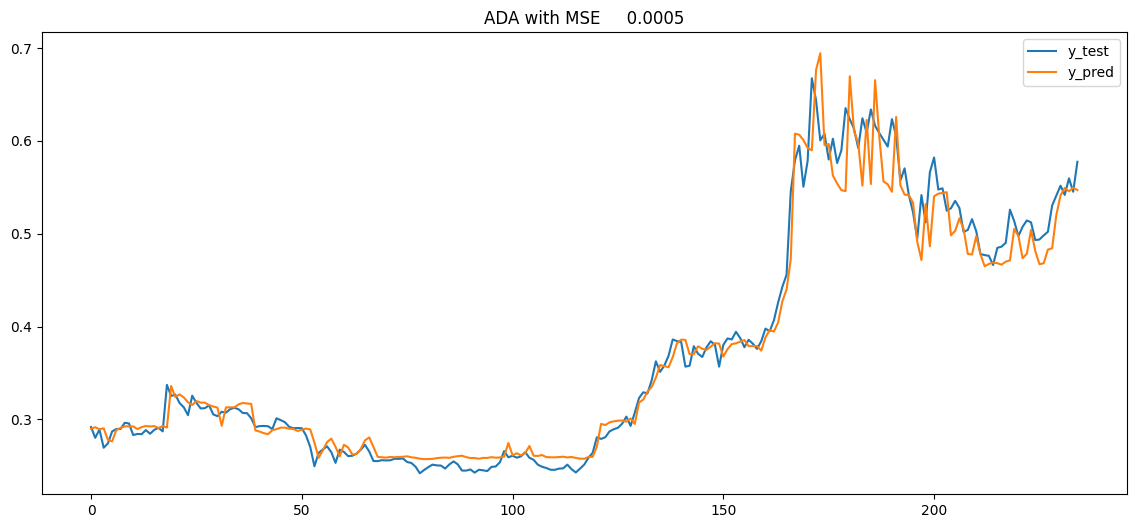

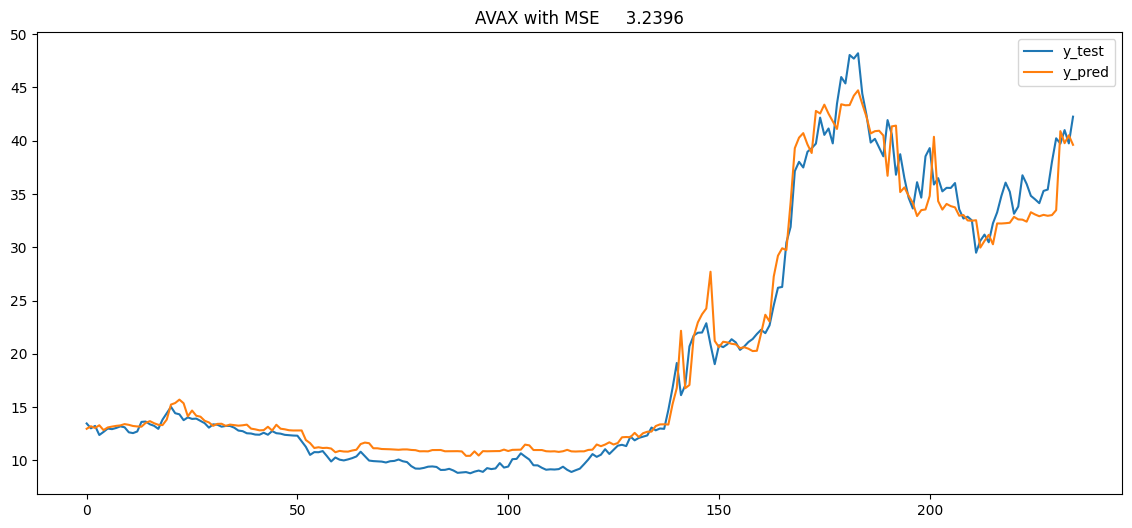

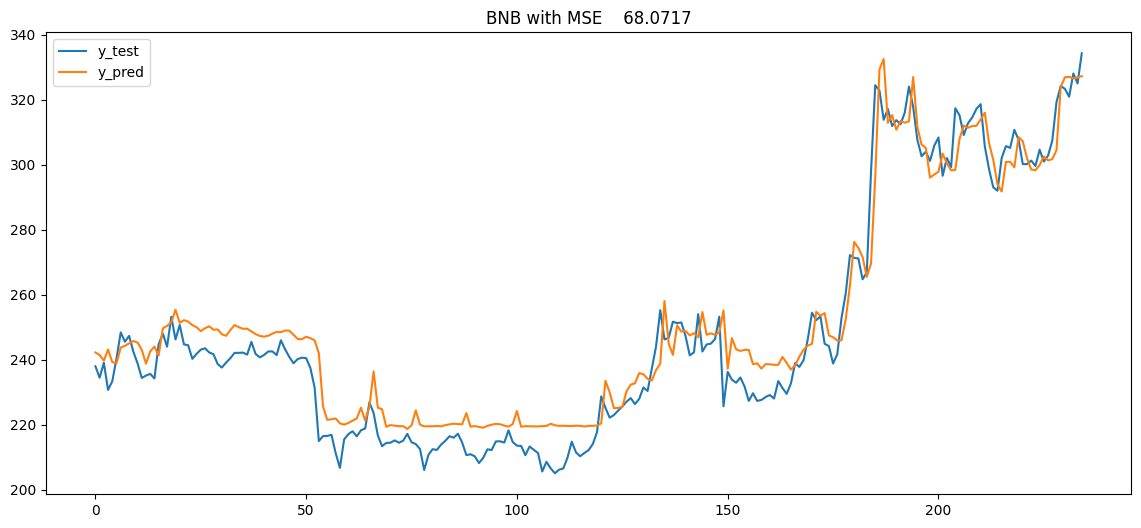

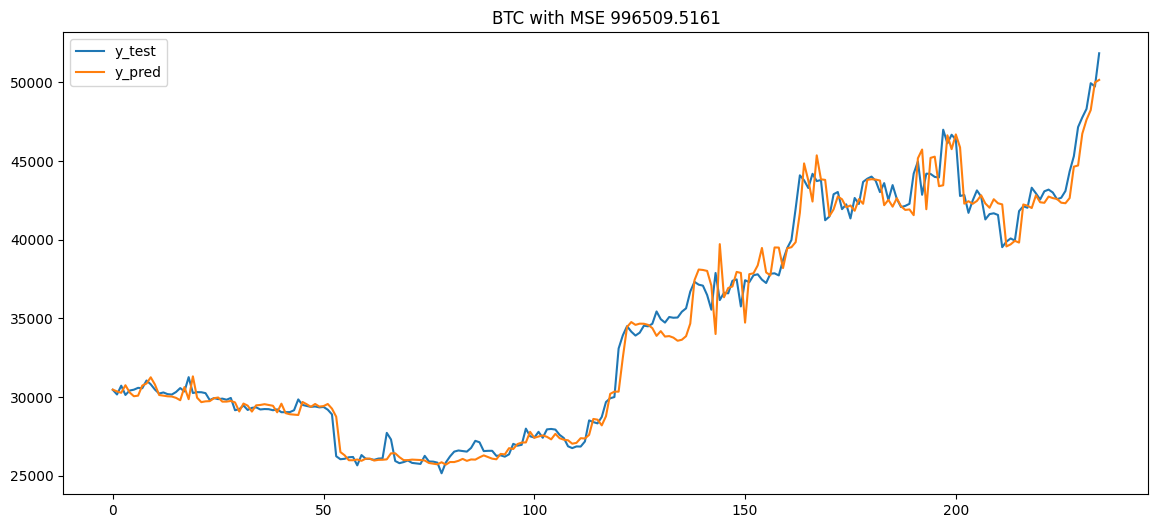

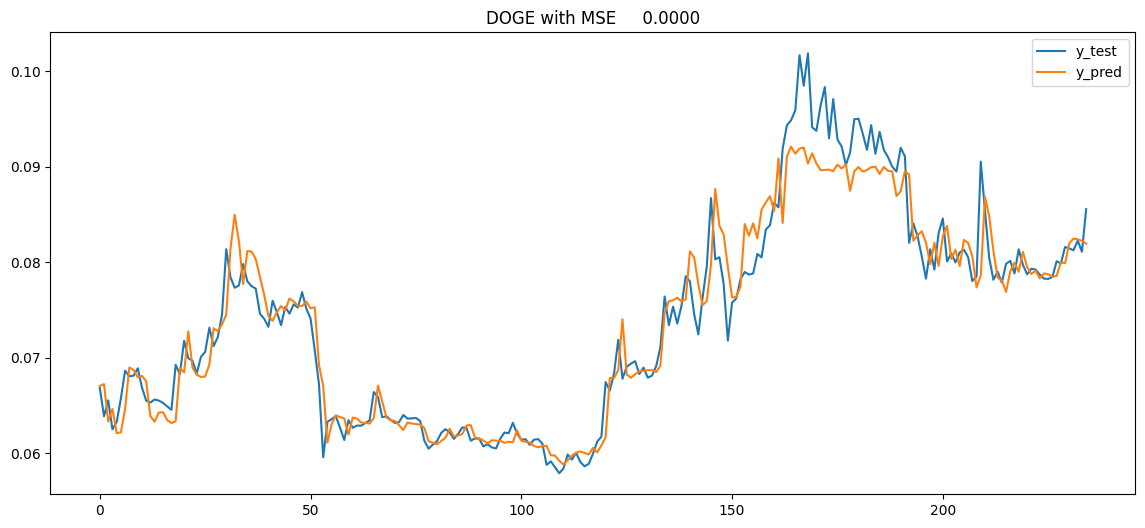

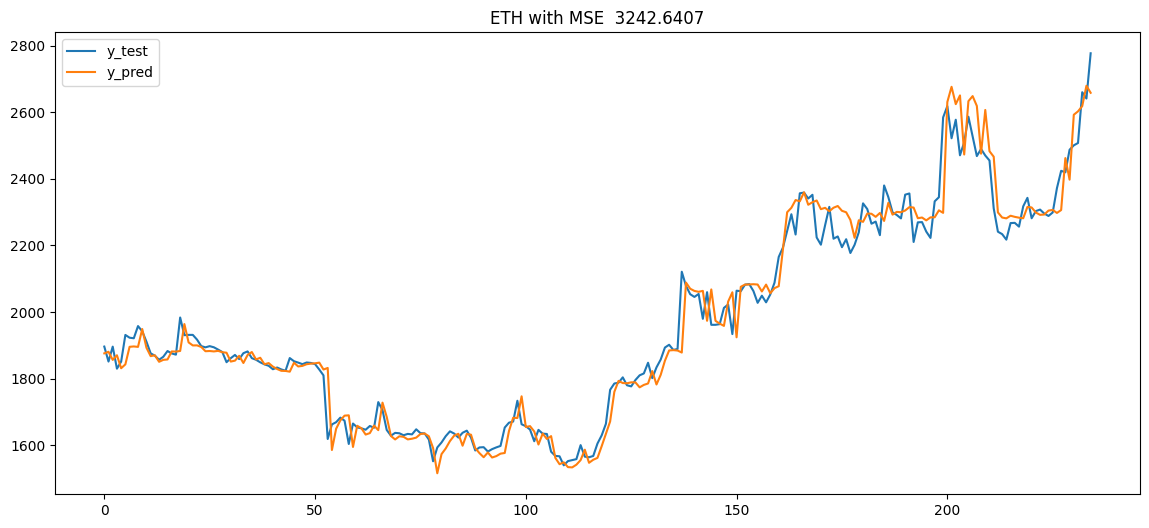

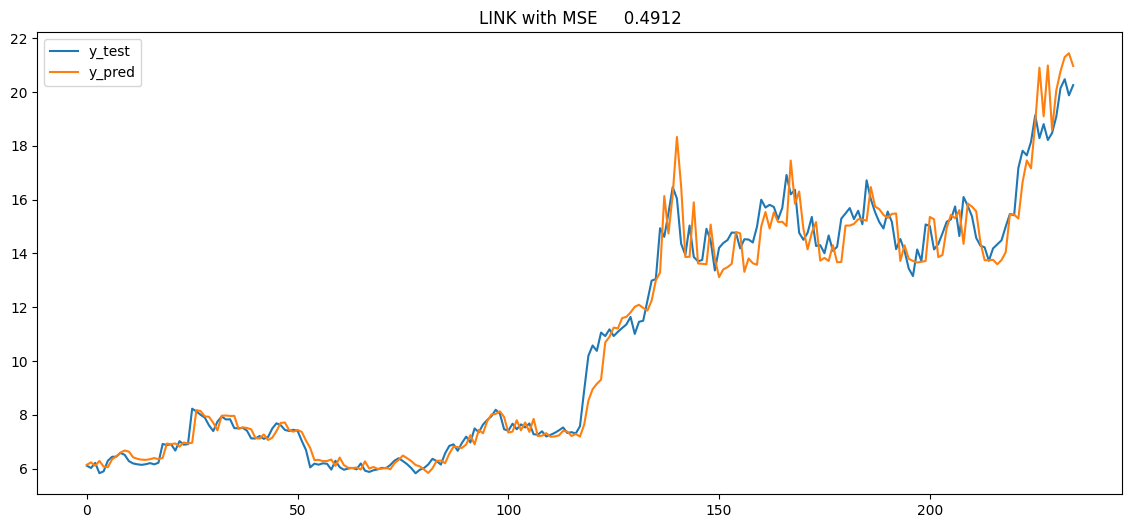

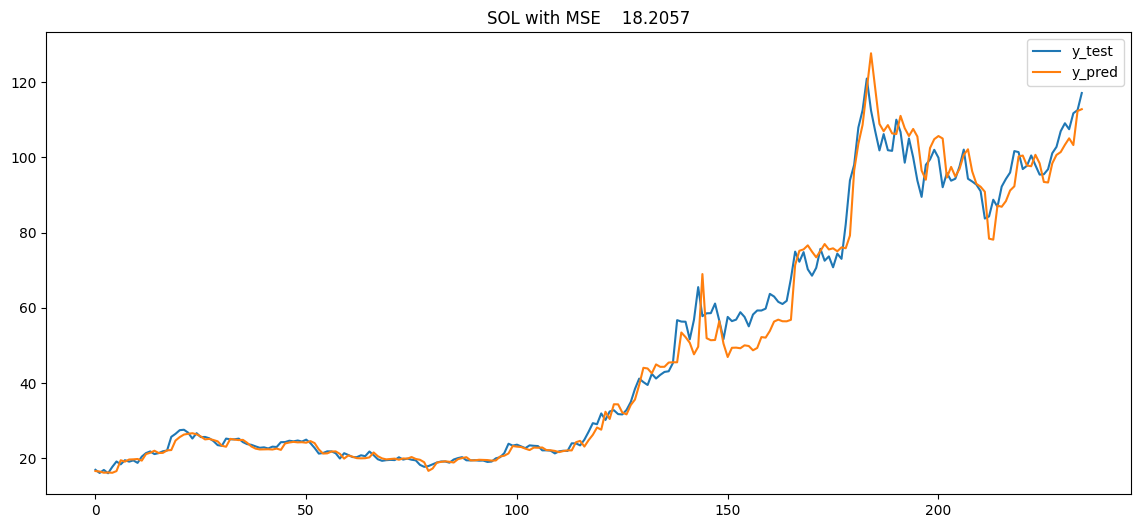

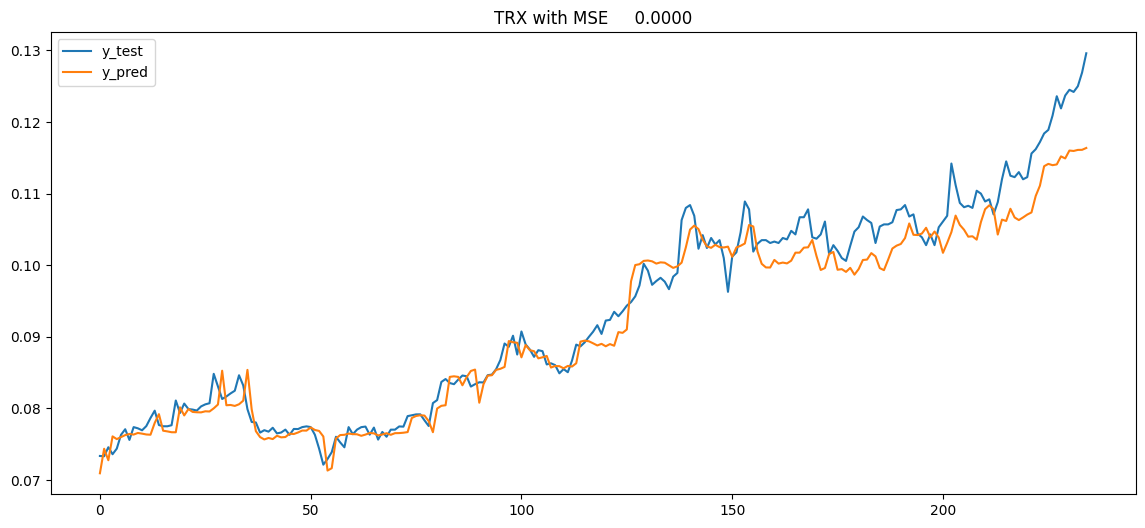

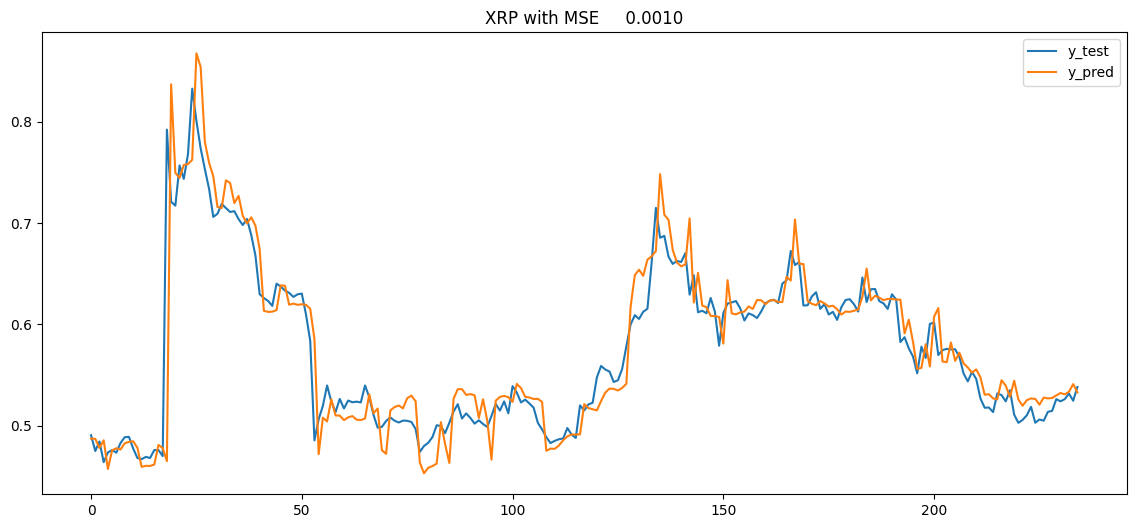

In [68]:
#ticker = 'ADA'
for ticker in ticker_values.columns:
    print(ticker)
    print("%s:\n%0.5f" % ('Random forest regression', ticker_data[ticker]['score']))    
    print("test evs: %.5f" % ticker_data[ticker]['evs'])
    print("MAE: {:.4f}".format(ticker_data[ticker]['mae']))
    print("MSE: {:.4f}".format(ticker_data[ticker]['mse']))
    print("RMSE: {:.4f}".format(ticker_data[ticker]['rmse']))
    print("R2 Score: {:.4f}\n".format(ticker_data[ticker]['r2']))
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(ticker, ticker_data[ticker]['mse']))
    plt.plot(ticker_data[ticker]['y_test'])
    plt.plot(ticker_data[ticker]['y_pred'])
    plt.legend(['y_test', 'y_pred'])    
    

### Models with automatically optimized parameters (RandomizedSearchCV)

In [63]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [64]:
for ticker in ticker_values.columns:    
    #model = RandomForestRegressor(n_estimators=100, random_state=42)
    #model.fit(ticker_data[ticker]['X_train'], ticker_data[ticker]['y_train'])
    #randomsearch = RandomizedSearchCV(model, param_dist, n_iter = 100, cv = 3, verbose = 1, n_jobs=-1, random_state=0)
    randomsearch = RandomizedSearchCV(model, param_dist, n_iter = 100, cv = 3, verbose = 1, n_jobs=-1)
    randomsearch.fit(ticker_data[ticker]['X_train'], ticker_data[ticker]['y_train'])
    randomsearch.best_params_
    #ticker_data[ticker]['RandomForest'] = model
    randomsearch_df = pd.DataFrame(randomsearch.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
    randomsearch_df = randomsearch_df.drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'std_test_score'], axis=1)
    ticker_data[ticker]['RandomForest'] = randomsearch.best_estimator_   
    ticker_data[ticker]['best_params_'] = randomsearch.best_params_
    ticker_data[ticker]['randomsearch_df'] = randomsearch_df
    

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [65]:
for ticker in ticker_values.columns:
    test_pred = ticker_data[ticker]['RandomForest'].predict(ticker_data[ticker]['X_test'])
    
    y_test = ticker_data[ticker]['Scaler'].inverse_transform(ticker_data[ticker]['y_test'].reshape(-1,1))
    y_pred = ticker_data[ticker]['Scaler'].inverse_transform(test_pred.reshape(-1,1))
        
    #ticker_data[ticker]['y_pred'] = test_pred
    ticker_data[ticker]['y_test'] = y_test
    ticker_data[ticker]['y_pred'] = y_pred
    ticker_data[ticker]['score'] = model.score(ticker_data[ticker]['X_test'], test_pred)       
    ticker_data[ticker]['evs'] = explained_variance_score(y_test, y_pred )
    ticker_data[ticker]['mae'] = mean_absolute_error(y_test, y_pred)
    ticker_data[ticker]['mse'] = mean_squared_error(y_test, y_pred)
    ticker_data[ticker]['rmse'] = np.sqrt(ticker_data[ticker]['mse'])
    ticker_data[ticker]['r2'] = r2_score(y_test, y_pred)

ADA
Random forest regression:
0.91313
test evs: 0.56587
MAE: 0.8095
MSE: 0.7146
RMSE: 0.8454
R2 Score: -4.2324

AVAX
Random forest regression:
0.88953
test evs: 0.01192
MAE: 2636.7729
MSE: 9416464.9506
RMSE: 3068.6259
R2 Score: -2.7762

BNB
Random forest regression:
0.12503
test evs: 0.00183
MAE: 160687.4230
MSE: 26357380512.0969
RMSE: 162349.5627
R2 Score: -47.9990

BTC
Random forest regression:
0.96440
test evs: 0.00003
MAE: 1960681752.9111
MSE: 4005505023349018112.0000
RMSE: 2001375782.6428
R2 Score: -23.8423

DOGE
Random forest regression:
-0.57856
test evs: 0.83738
MAE: 0.0221
MSE: 0.0005
RMSE: 0.0223
R2 Score: -8.2251

ETH
Random forest regression:
0.92324
test evs: 0.00048
MAE: 8762892.1787
MSE: 78567341870255.4531
RMSE: 8863822.0802
R2 Score: -43.1411

LINK
Random forest regression:
0.88943
test evs: 0.04011
MAE: 483.3123
MSE: 269449.5616
RMSE: 519.0853
R2 Score: -6.2128

SOL
Random forest regression:
0.94030
test evs: 0.00906
MAE: 12541.9799
MSE: 227497464.6992
RMSE: 15083.019

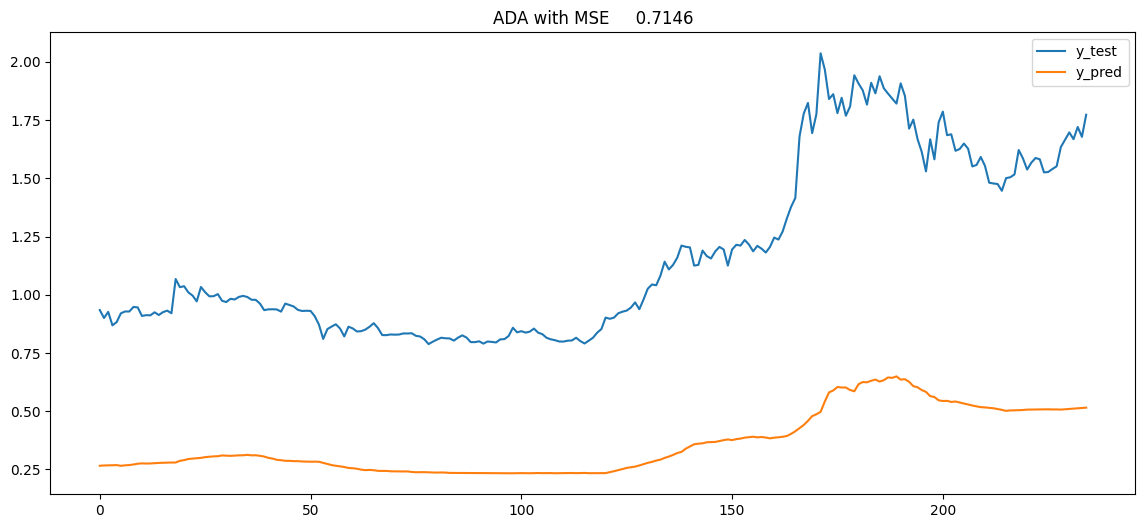

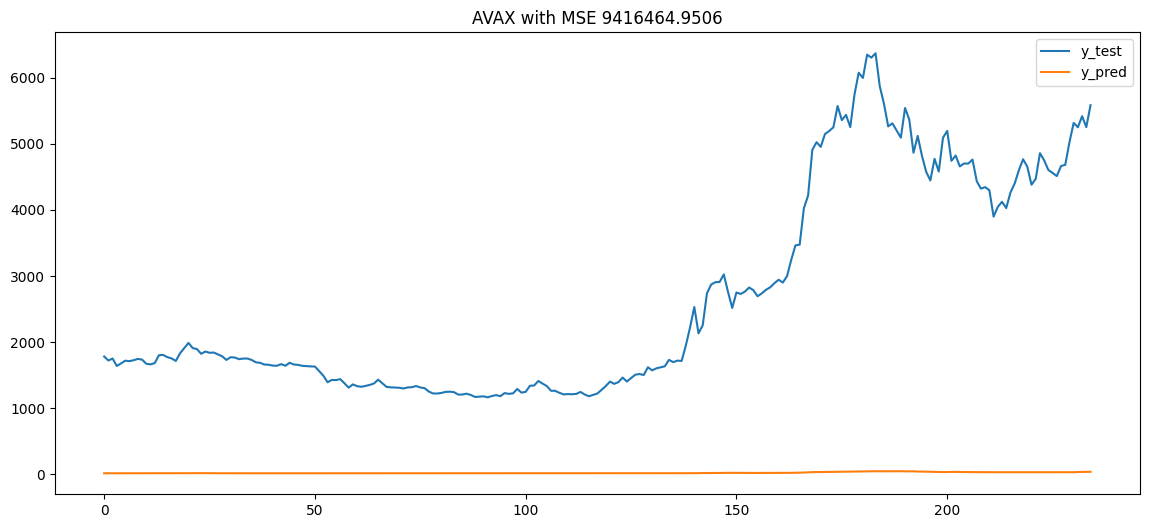

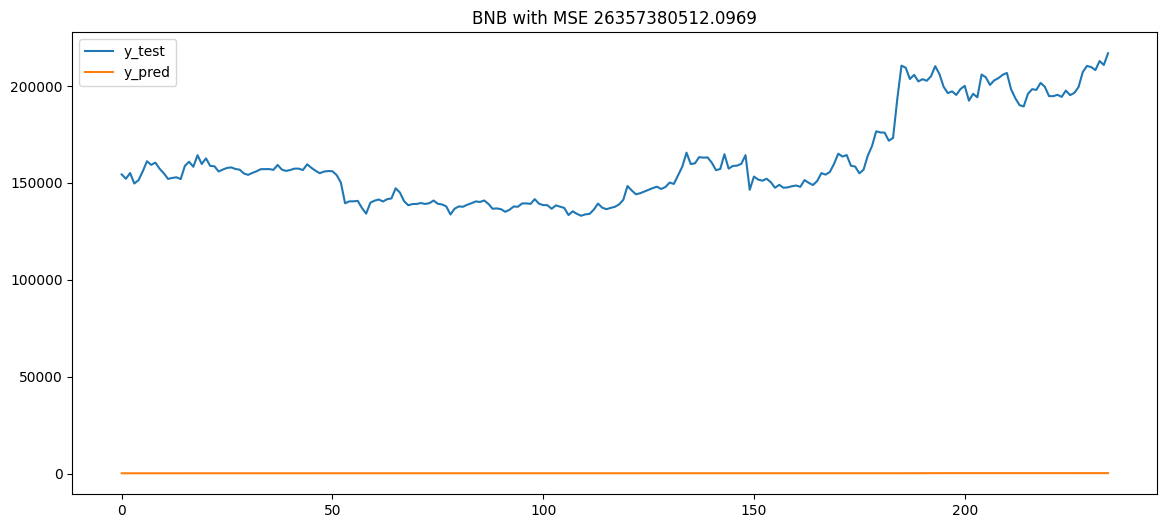

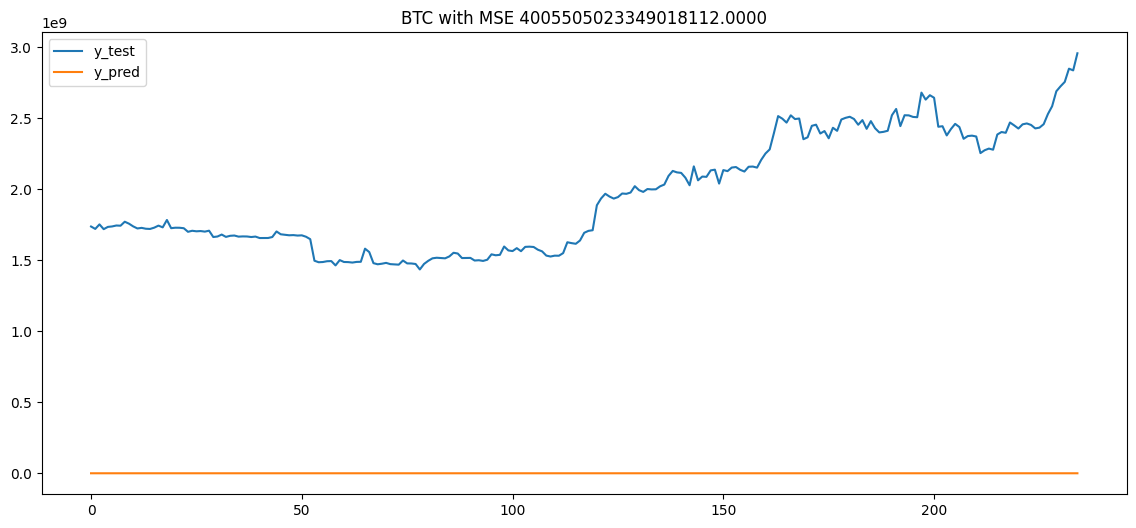

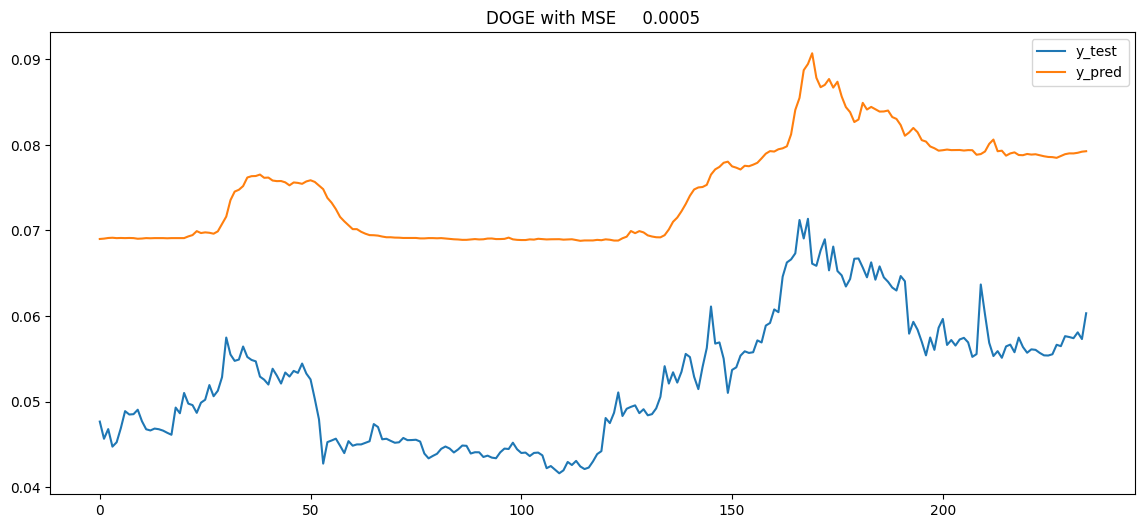

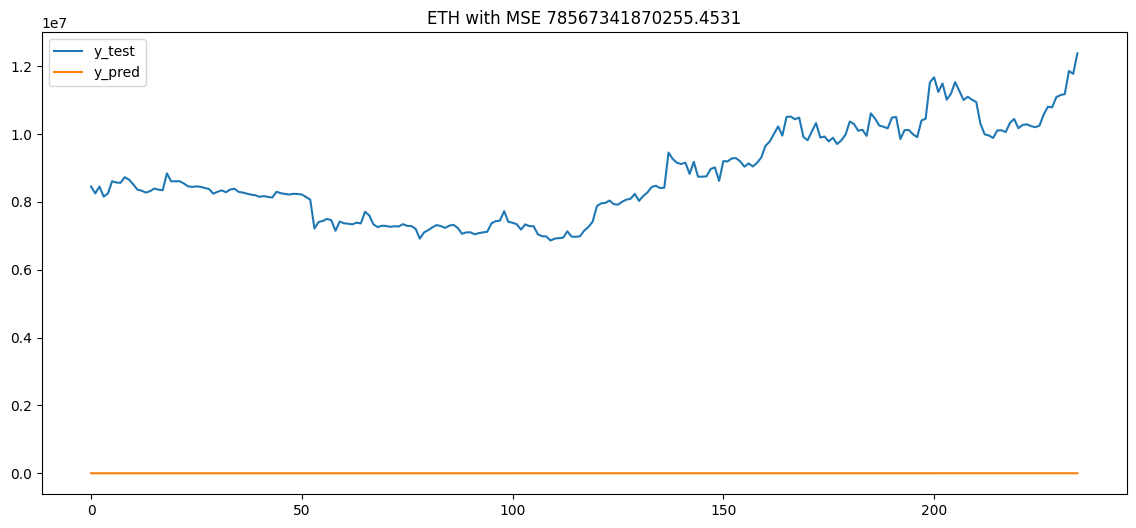

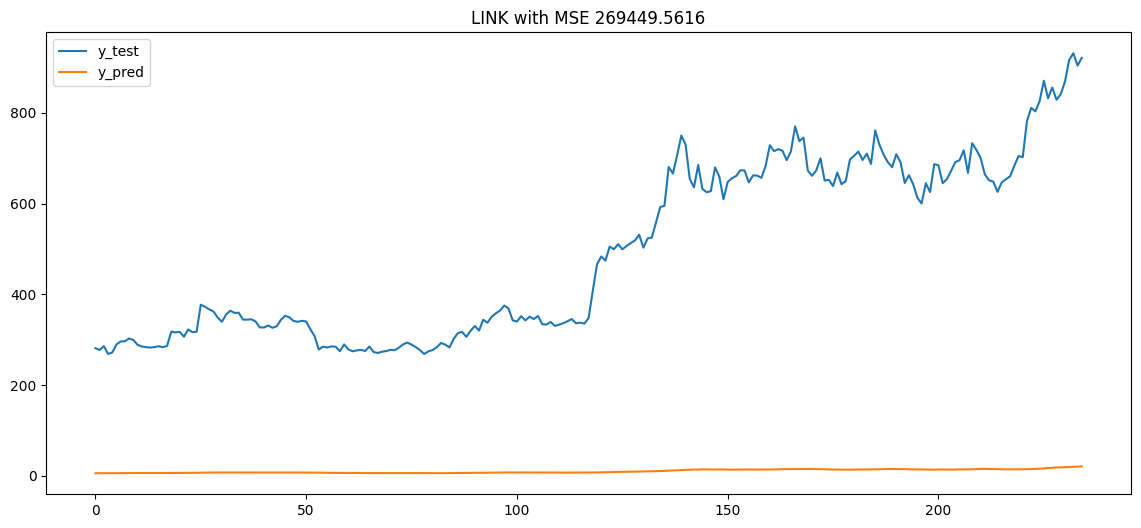

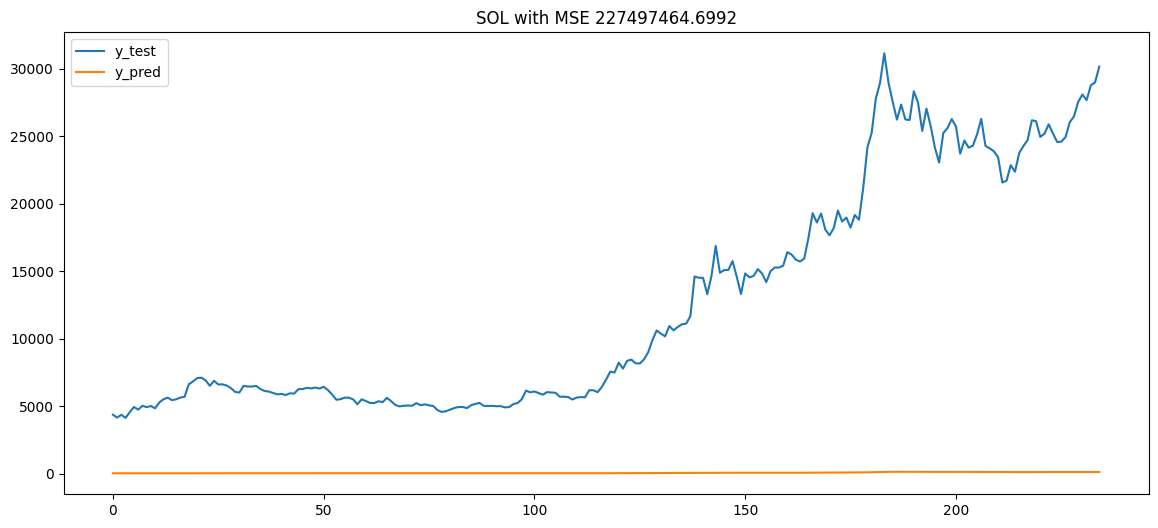

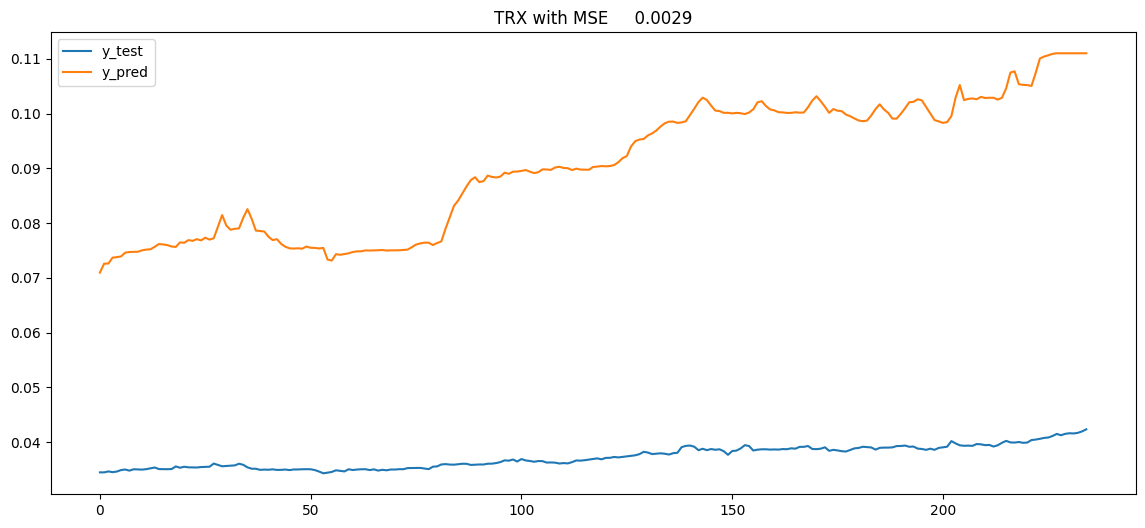

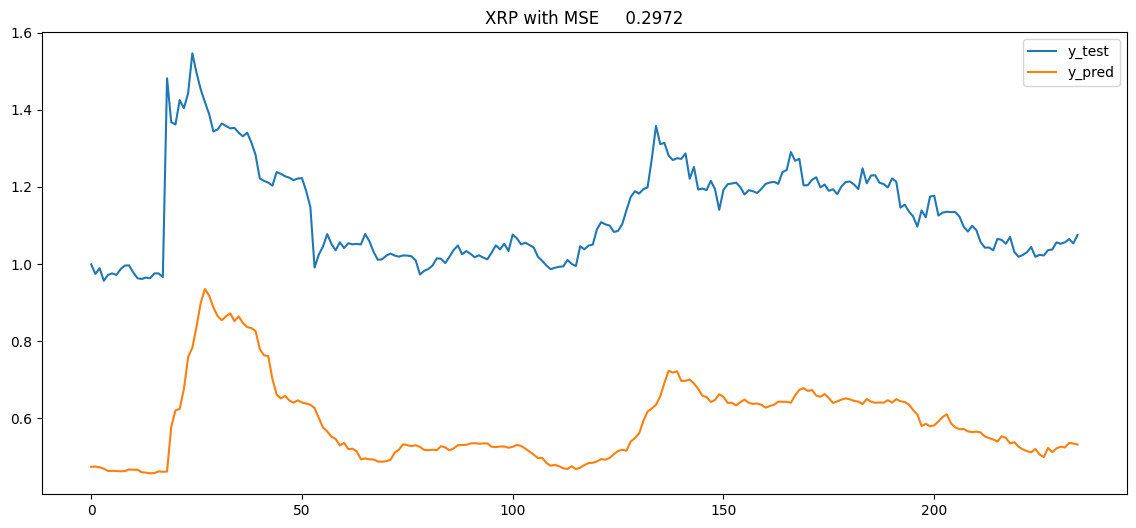

In [66]:
#ticker = 'ADA'
for ticker in ticker_values.columns:
    print(ticker)
    print("%s:\n%0.5f" % ('Random forest regression', ticker_data[ticker]['score']))    
    print("test evs: %.5f" % ticker_data[ticker]['evs'])
    print("MAE: {:.4f}".format(ticker_data[ticker]['mae']))
    print("MSE: {:.4f}".format(ticker_data[ticker]['mse']))
    print("RMSE: {:.4f}".format(ticker_data[ticker]['rmse']))
    print("R2 Score: {:.4f}\n".format(ticker_data[ticker]['r2']))
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(ticker, ticker_data[ticker]['mse']))
    plt.plot(ticker_data[ticker]['y_test'])
    plt.plot(ticker_data[ticker]['y_pred'])
    plt.legend(['y_test', 'y_pred'])   

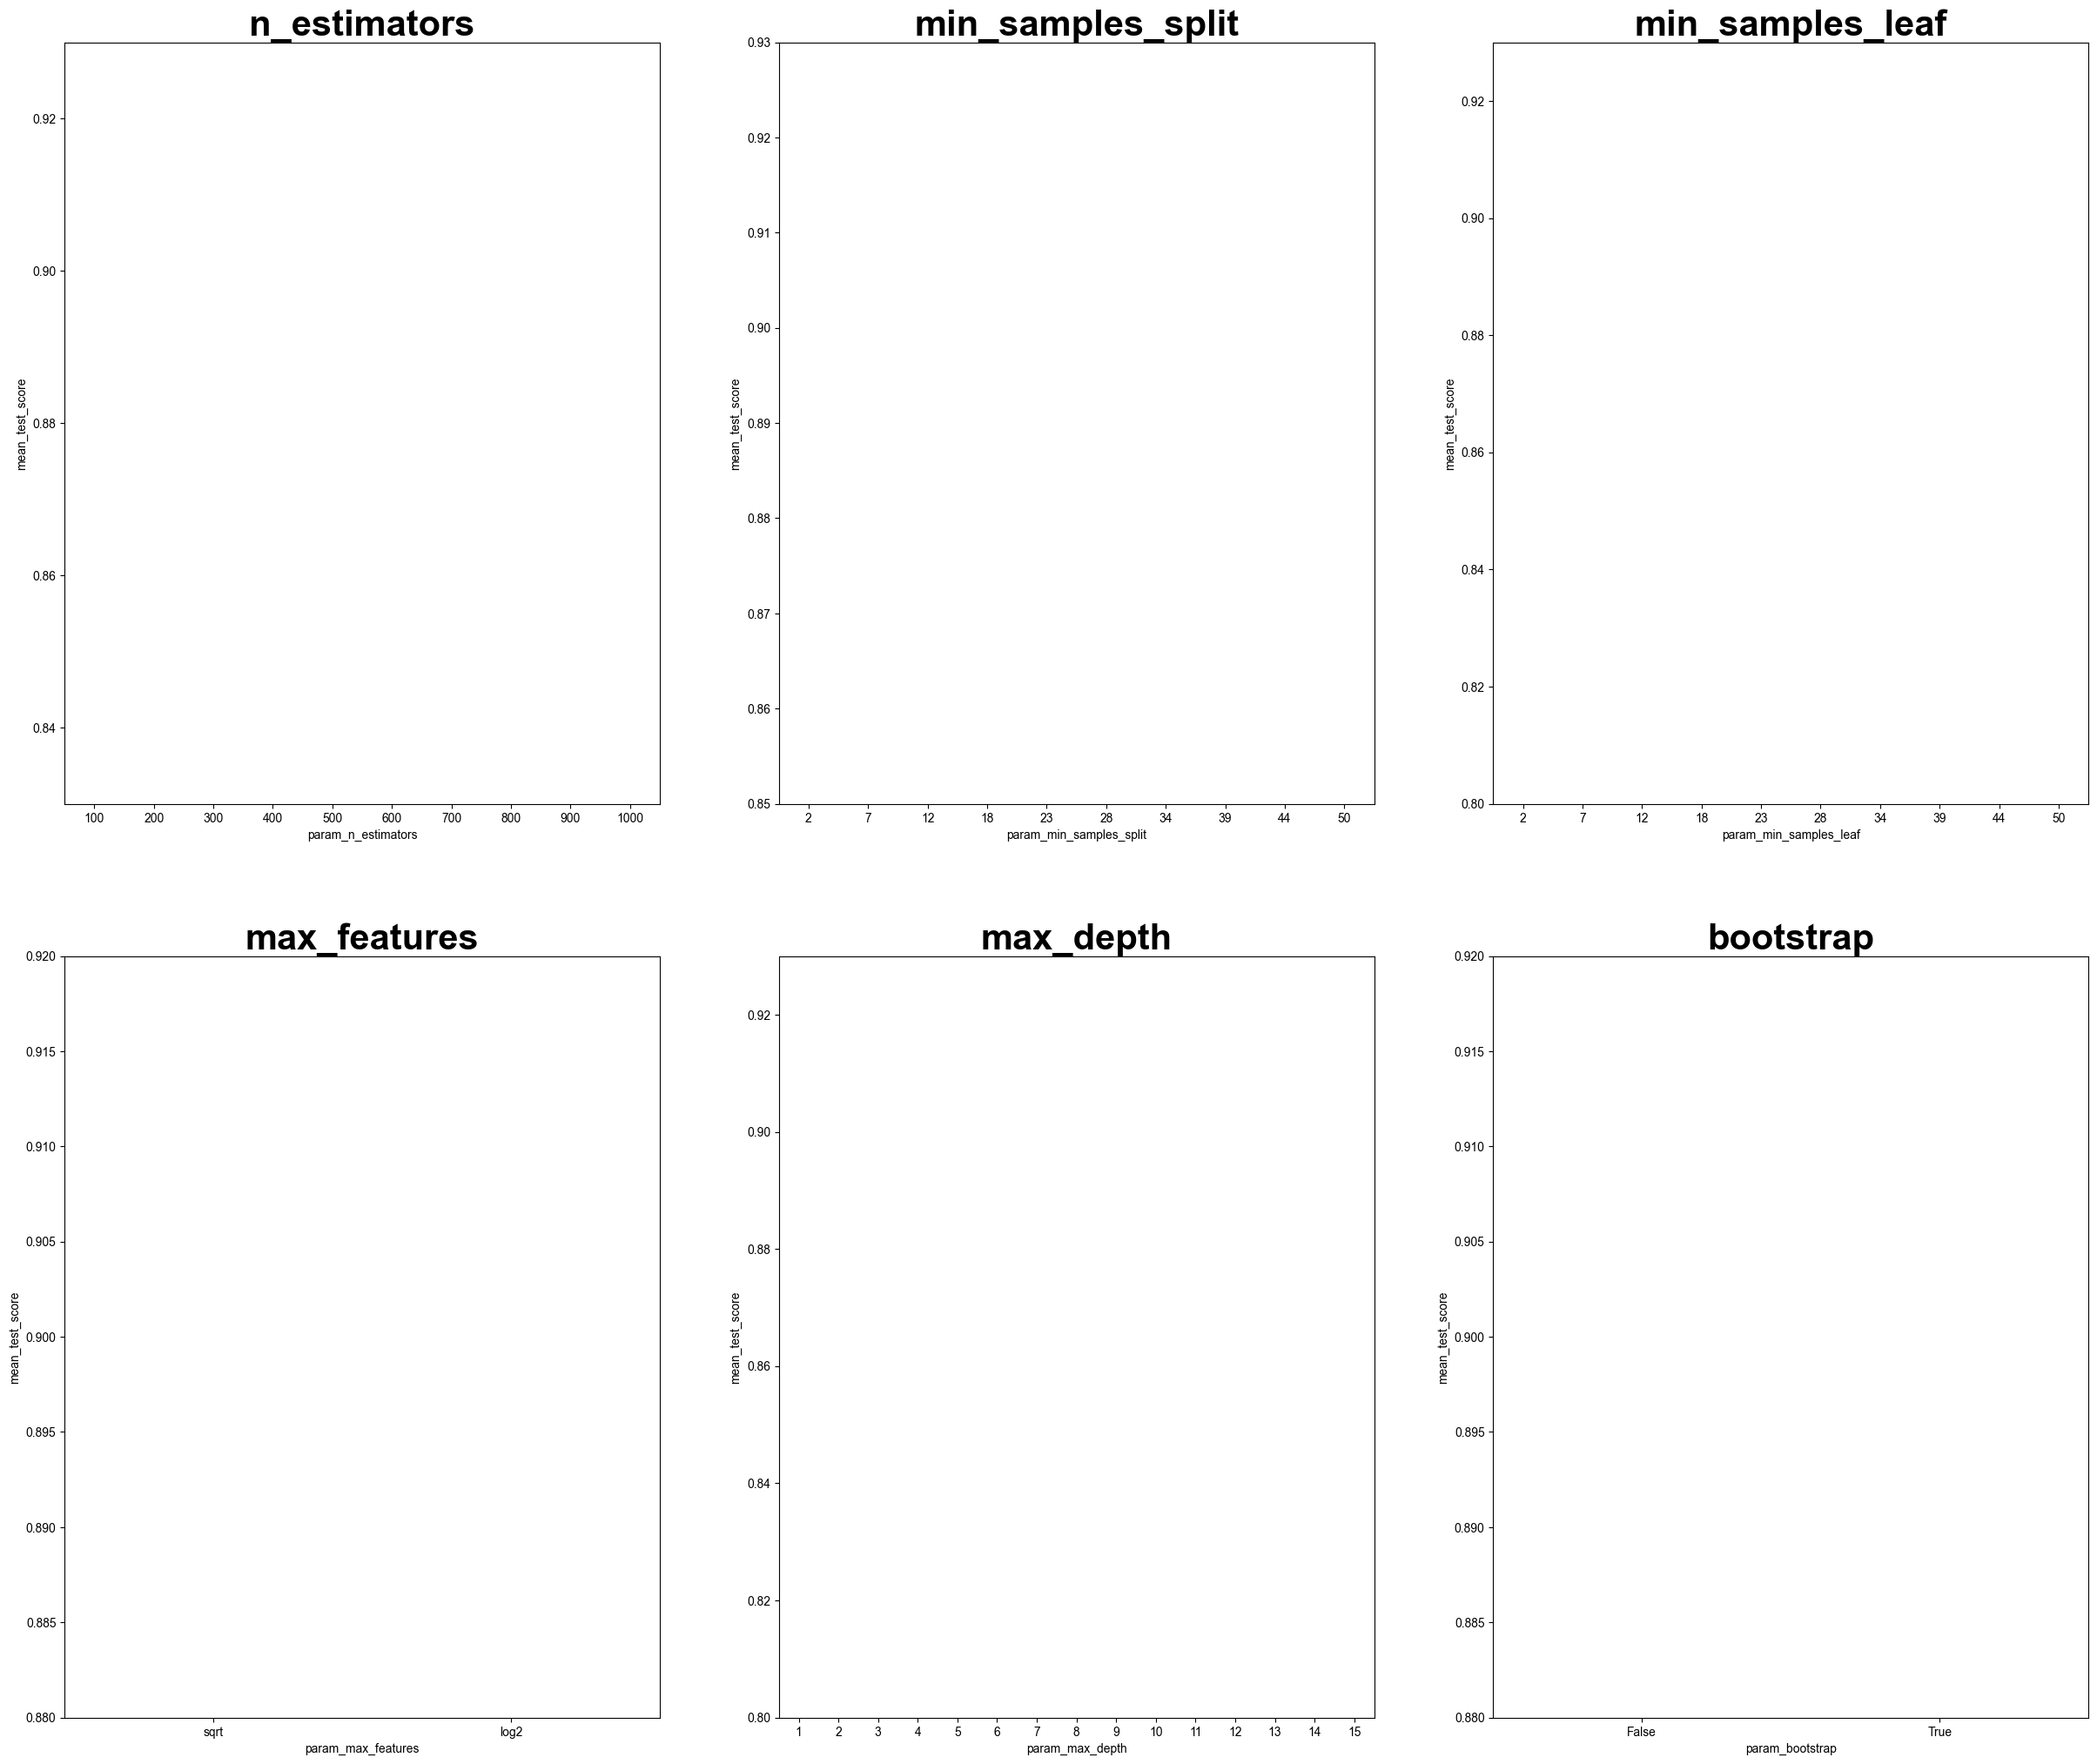

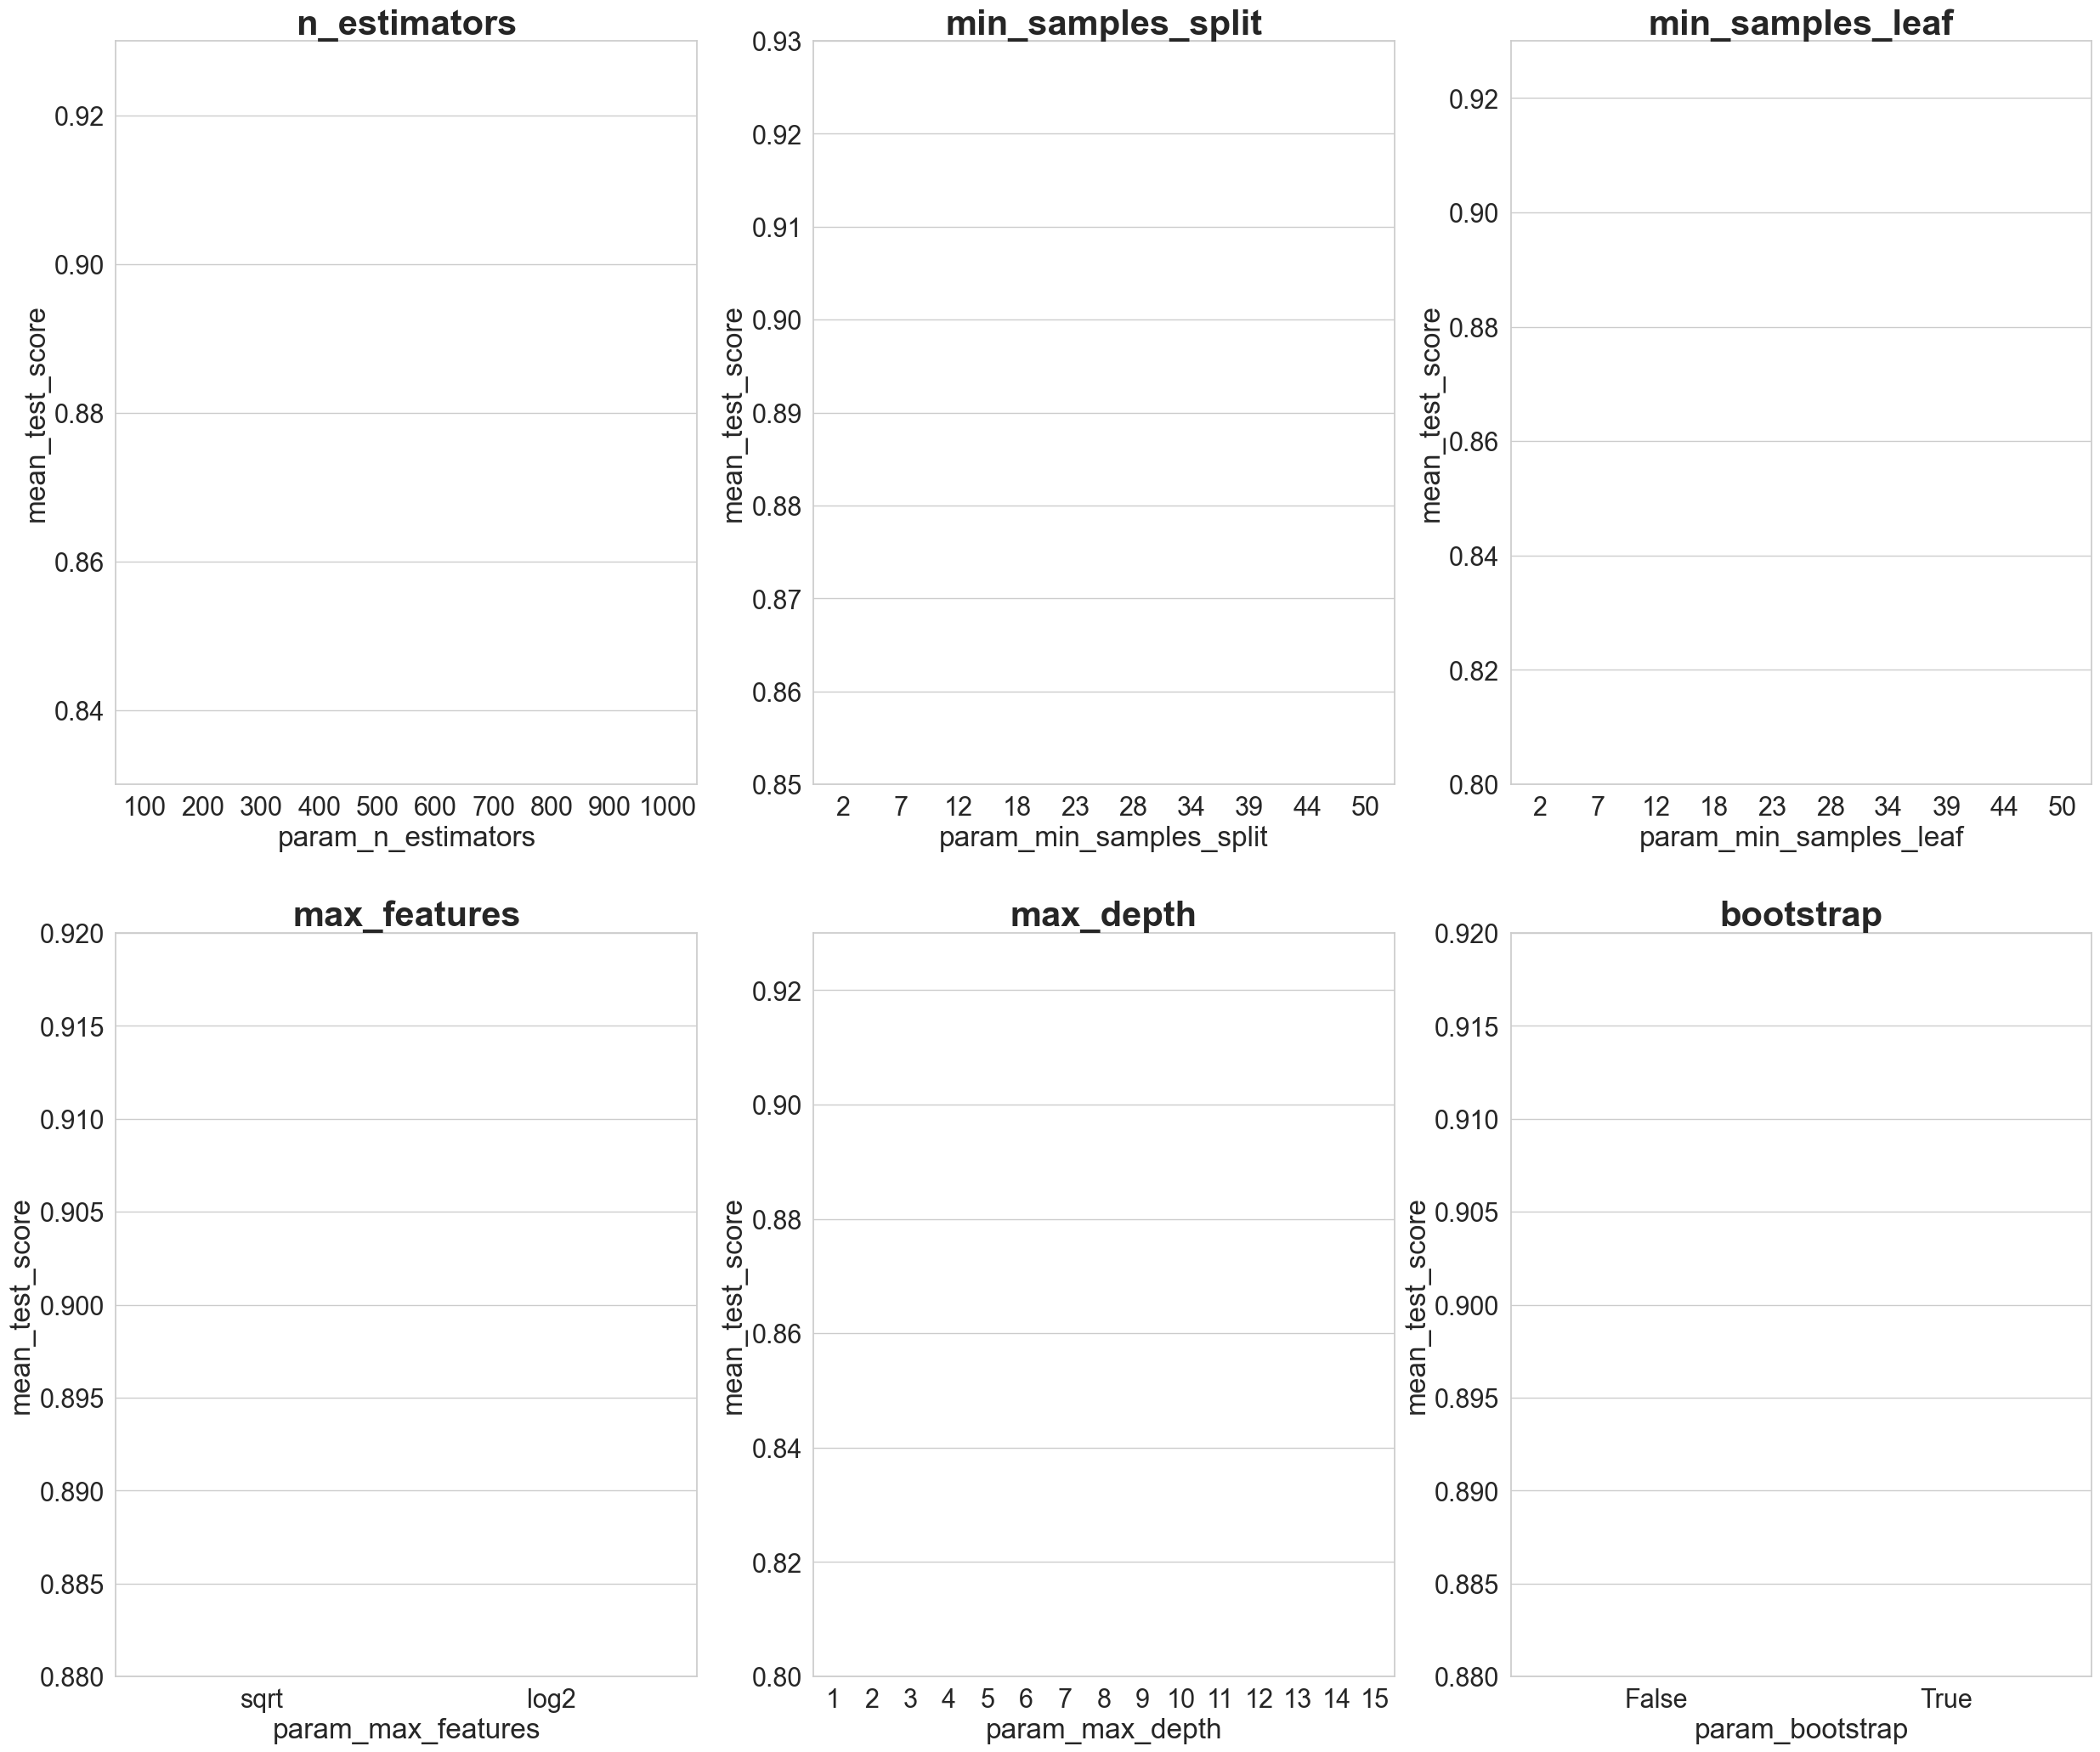

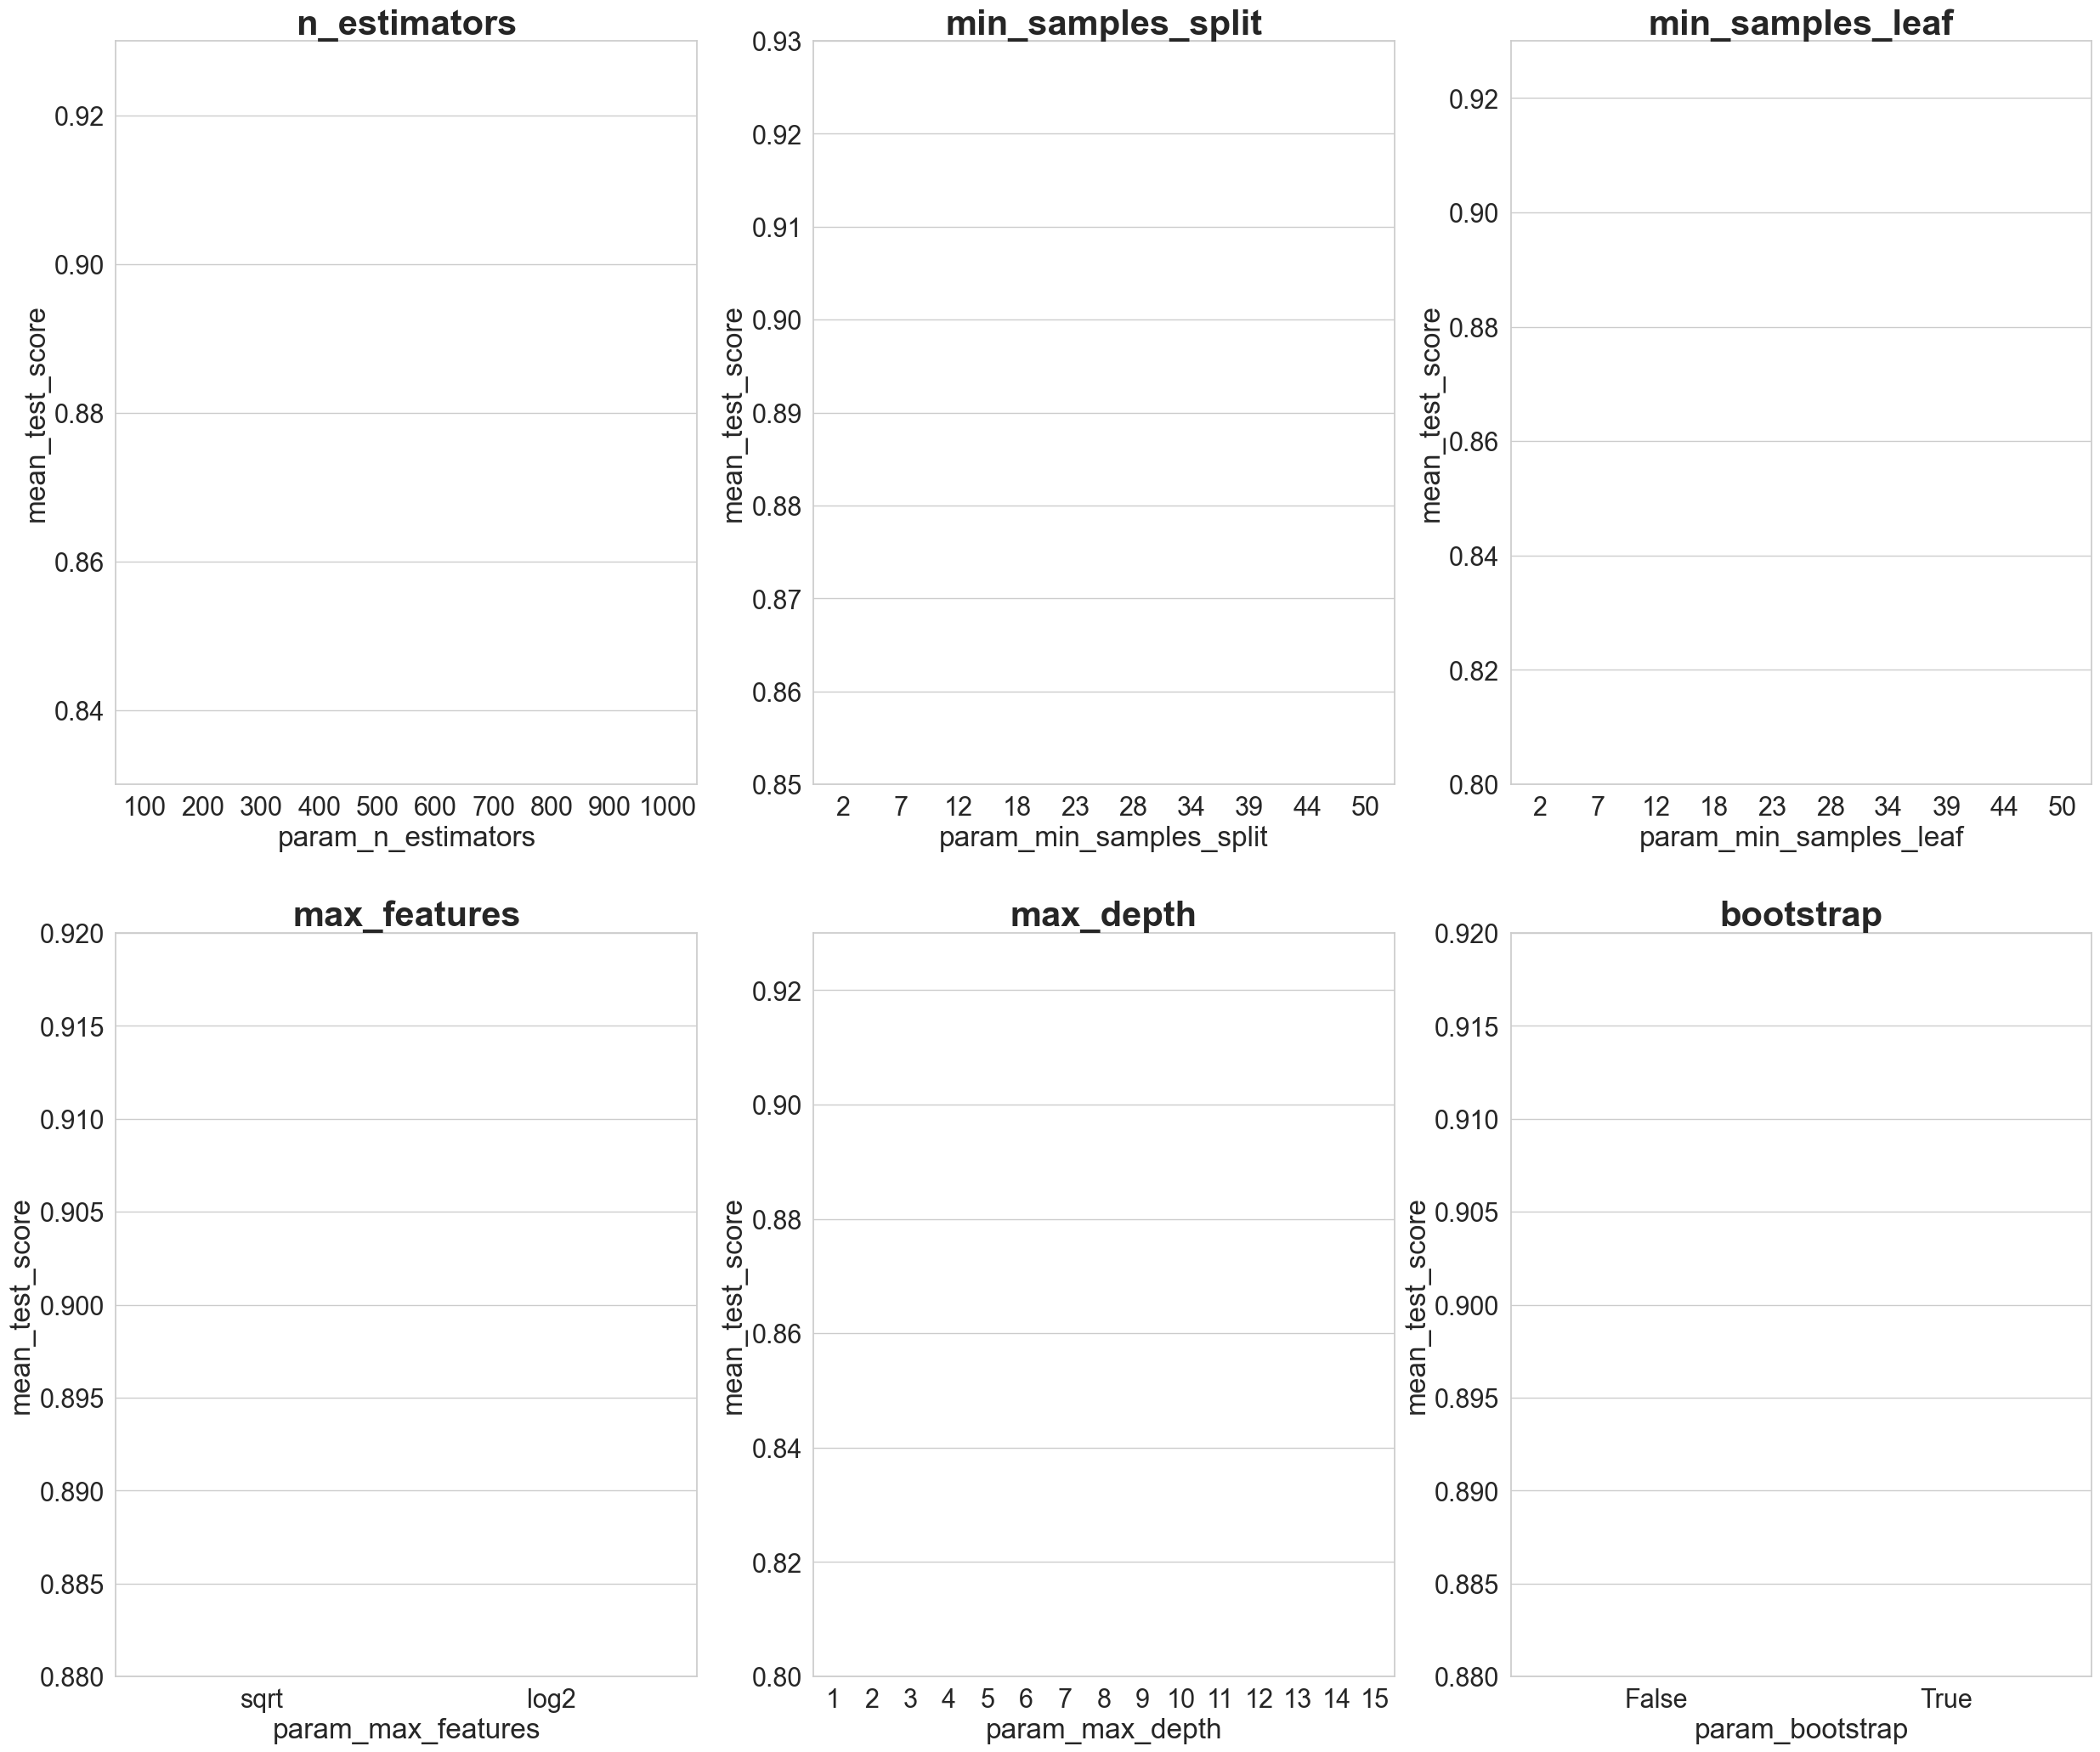

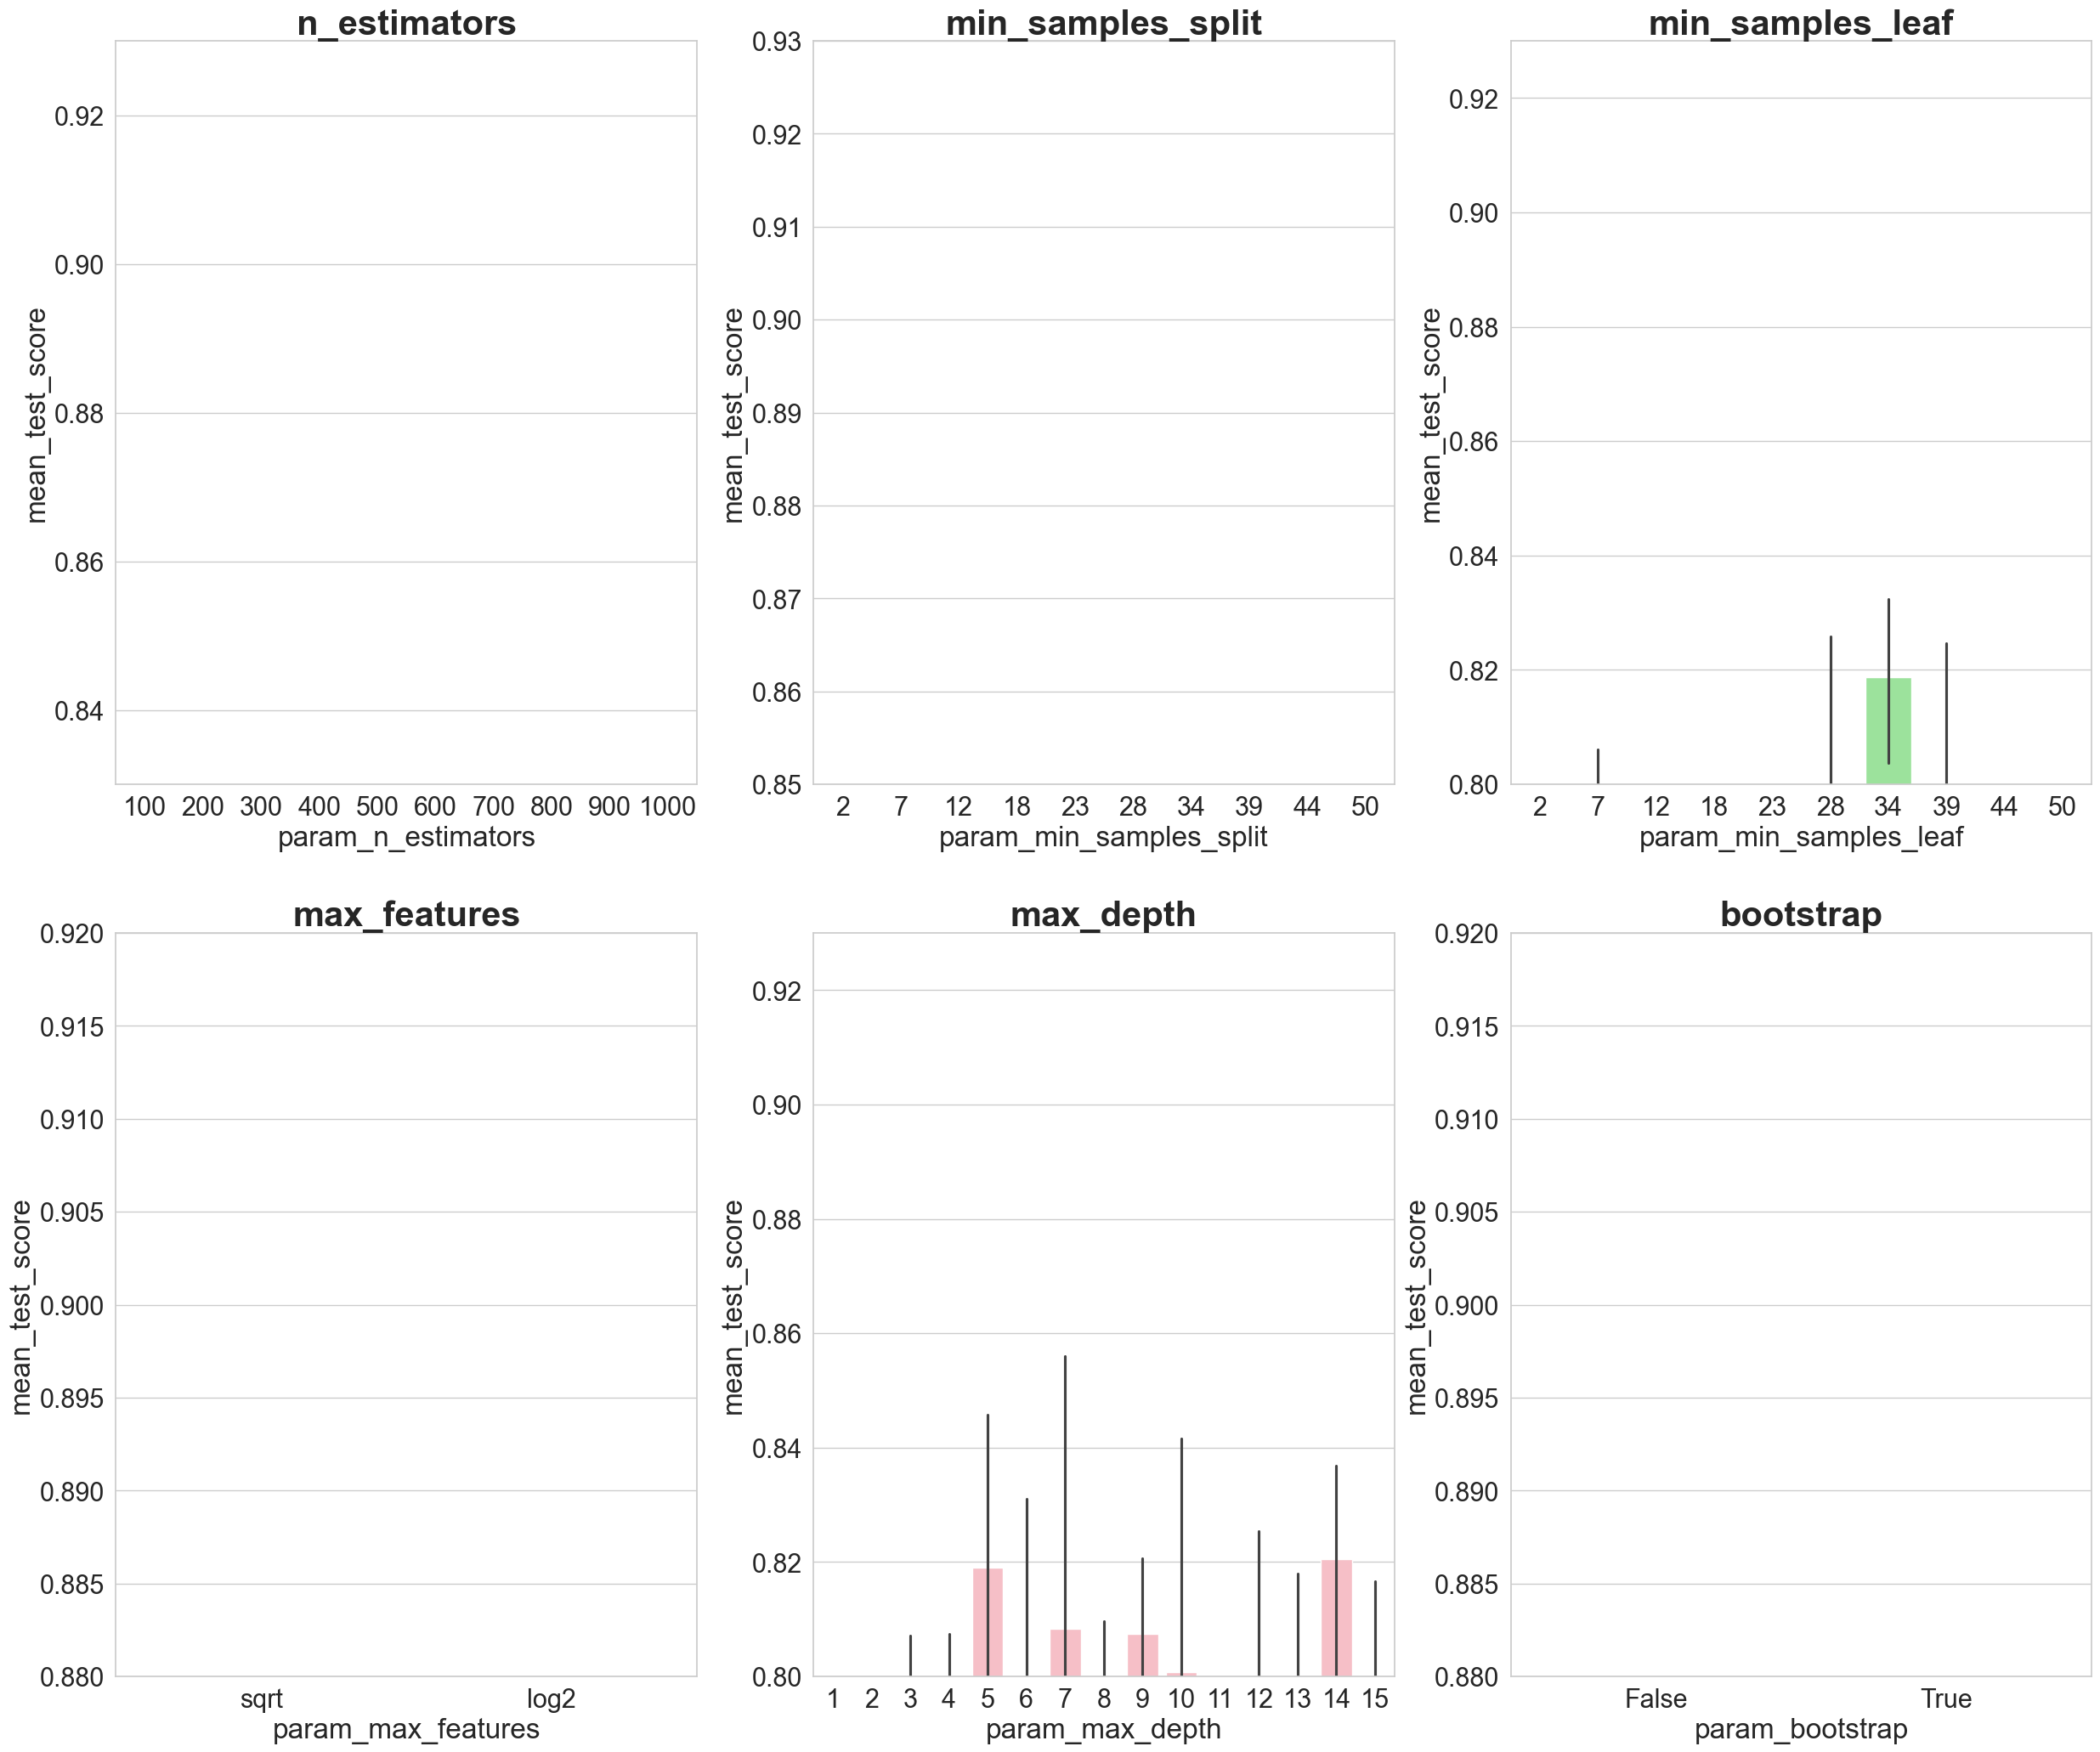

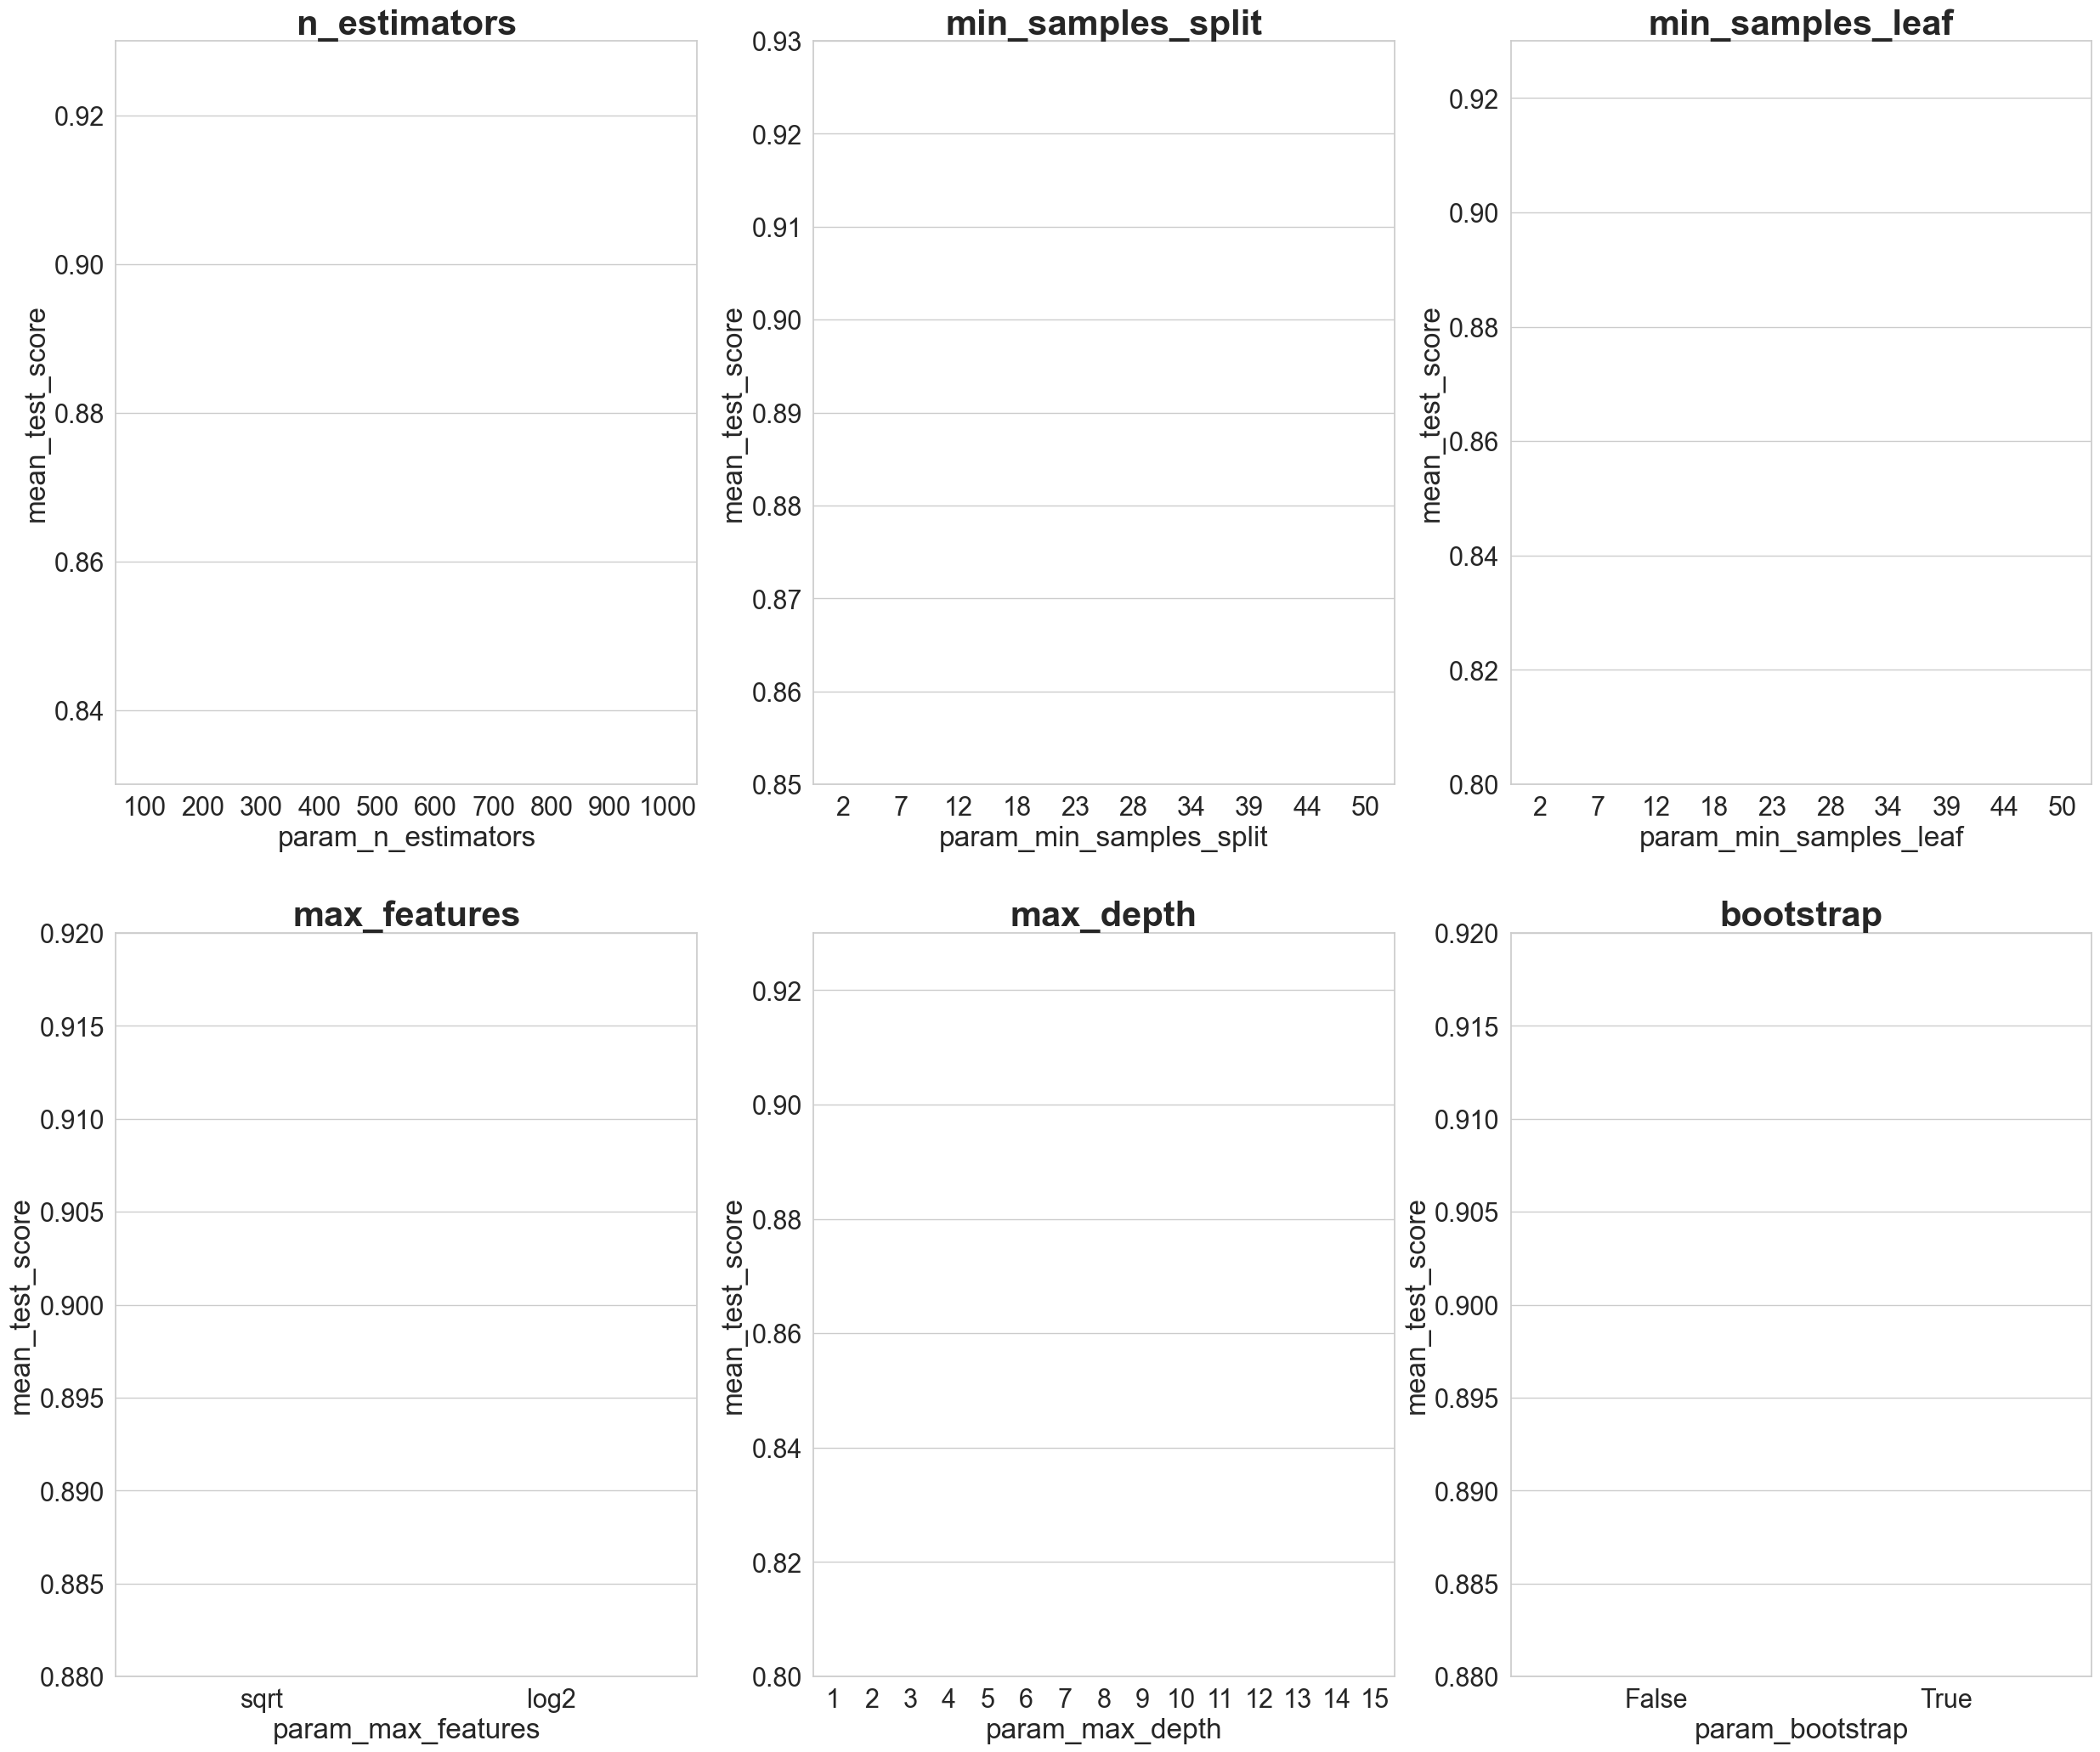

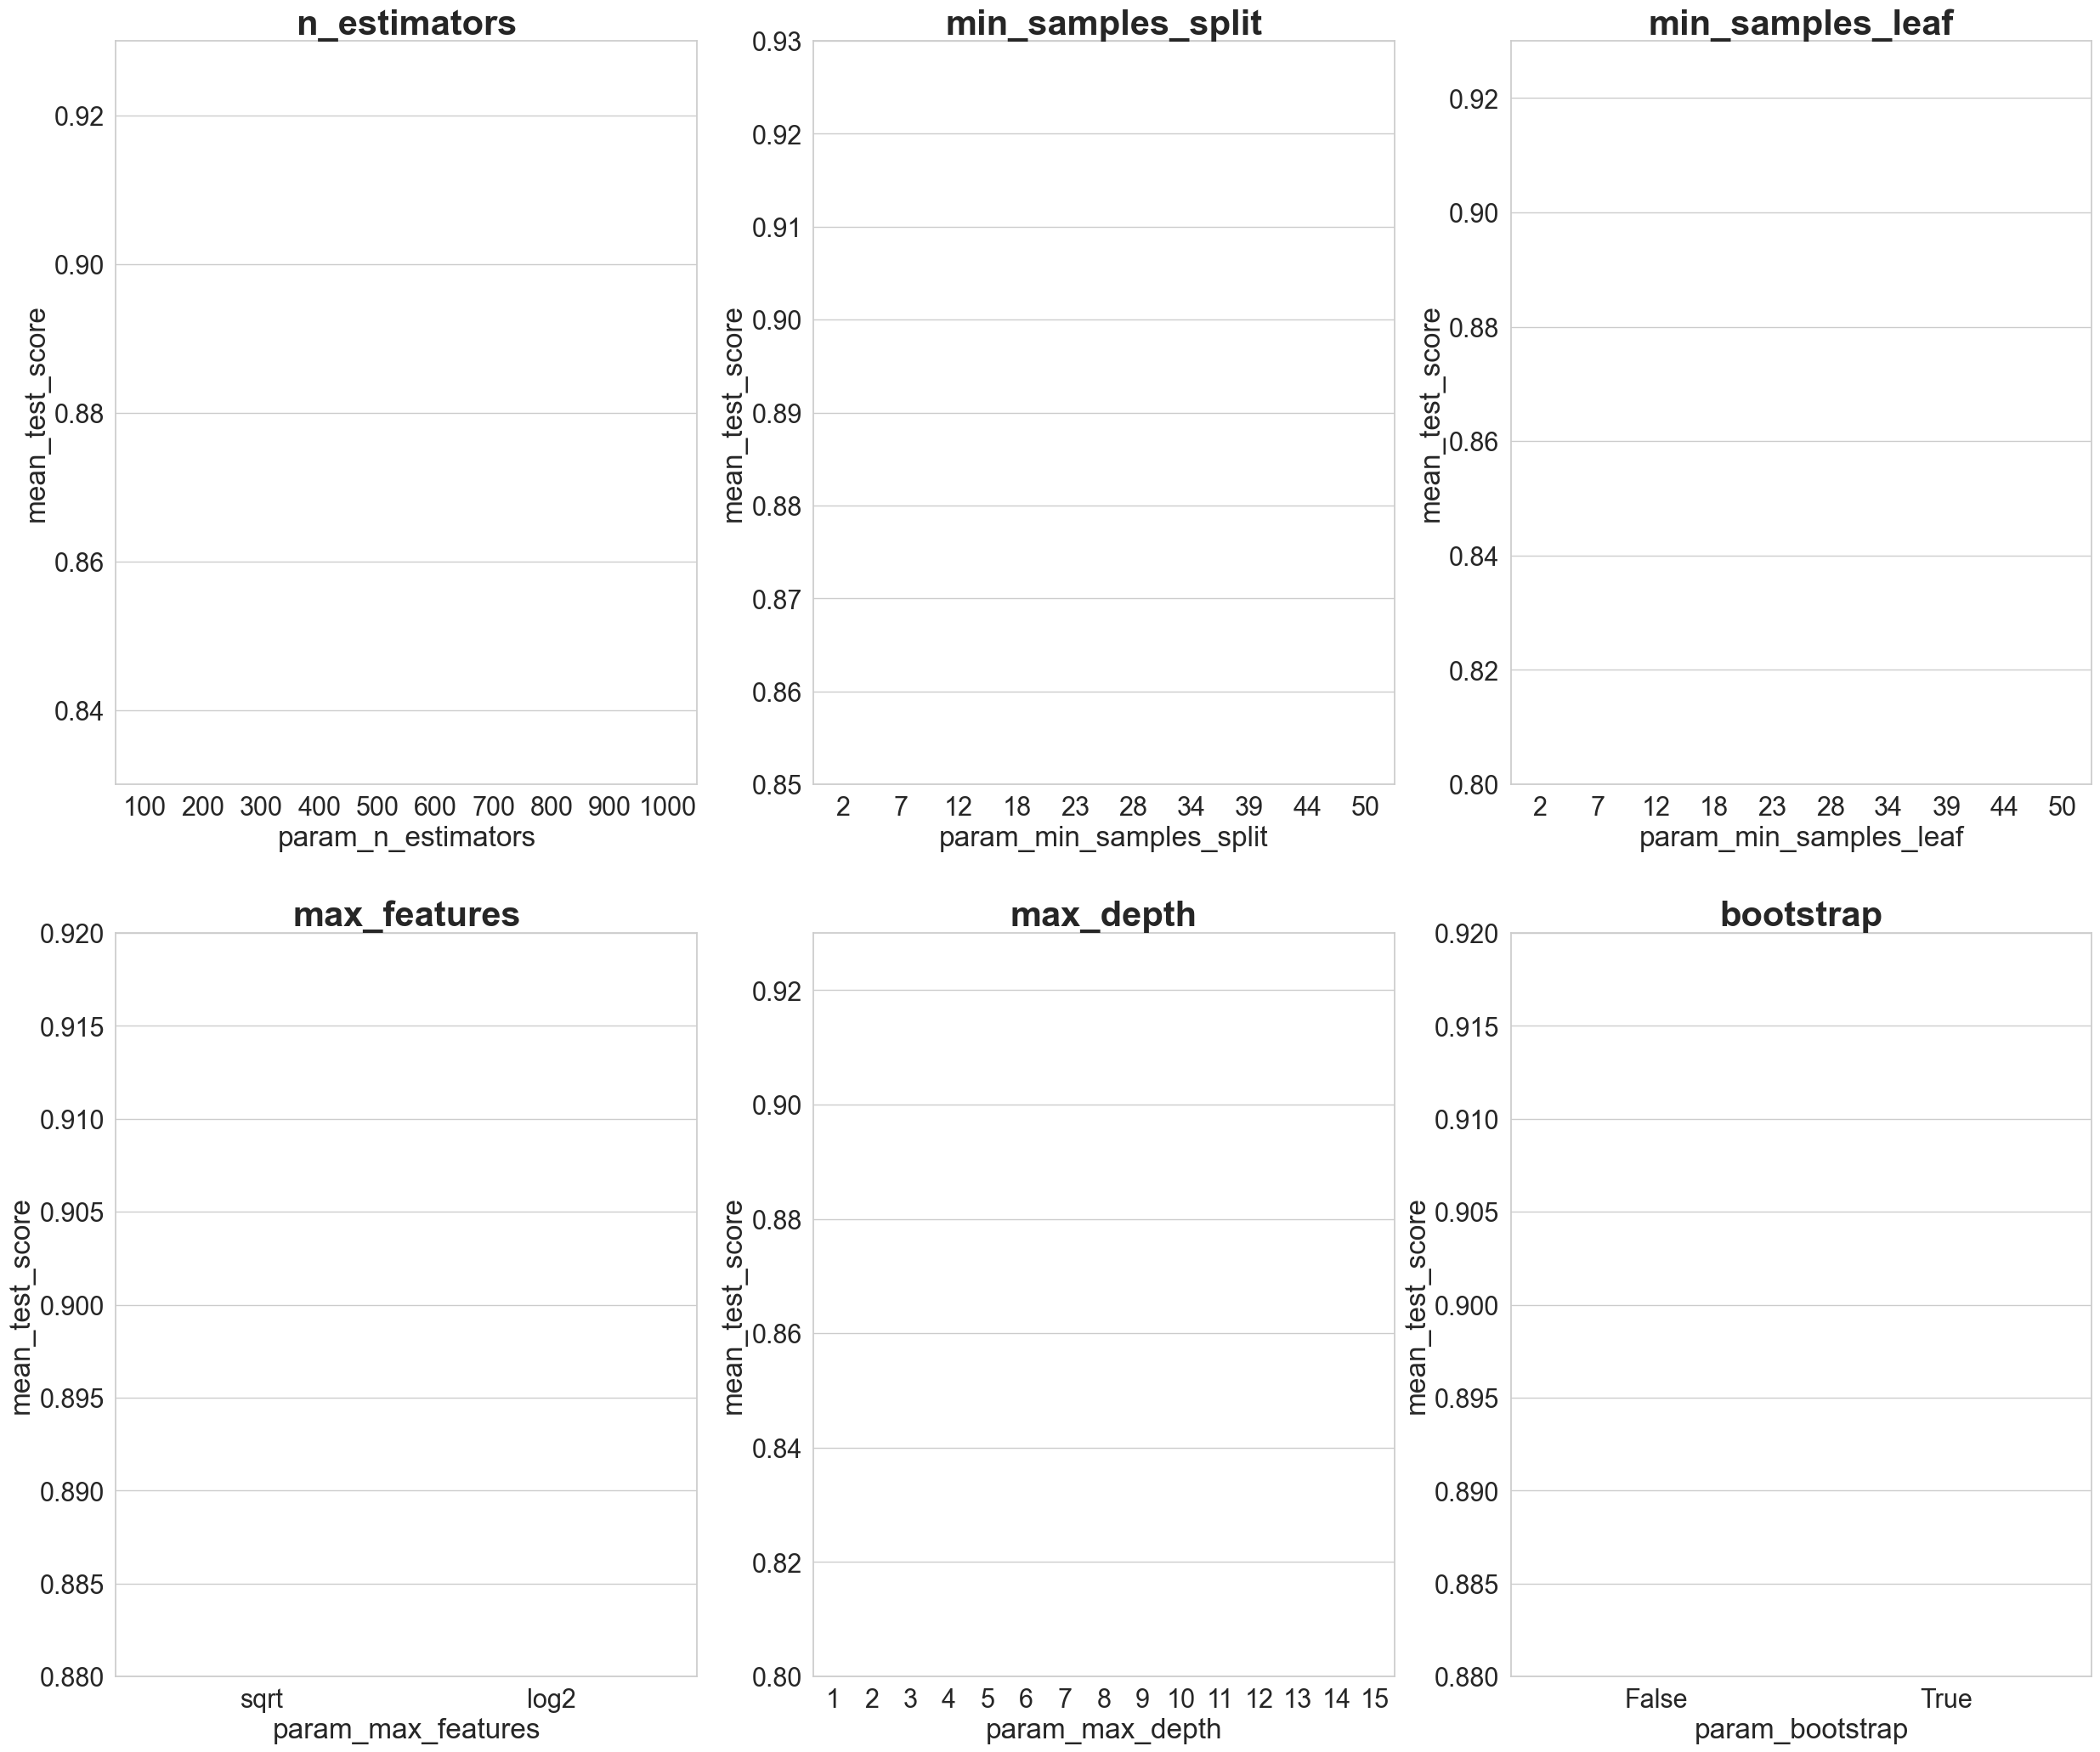

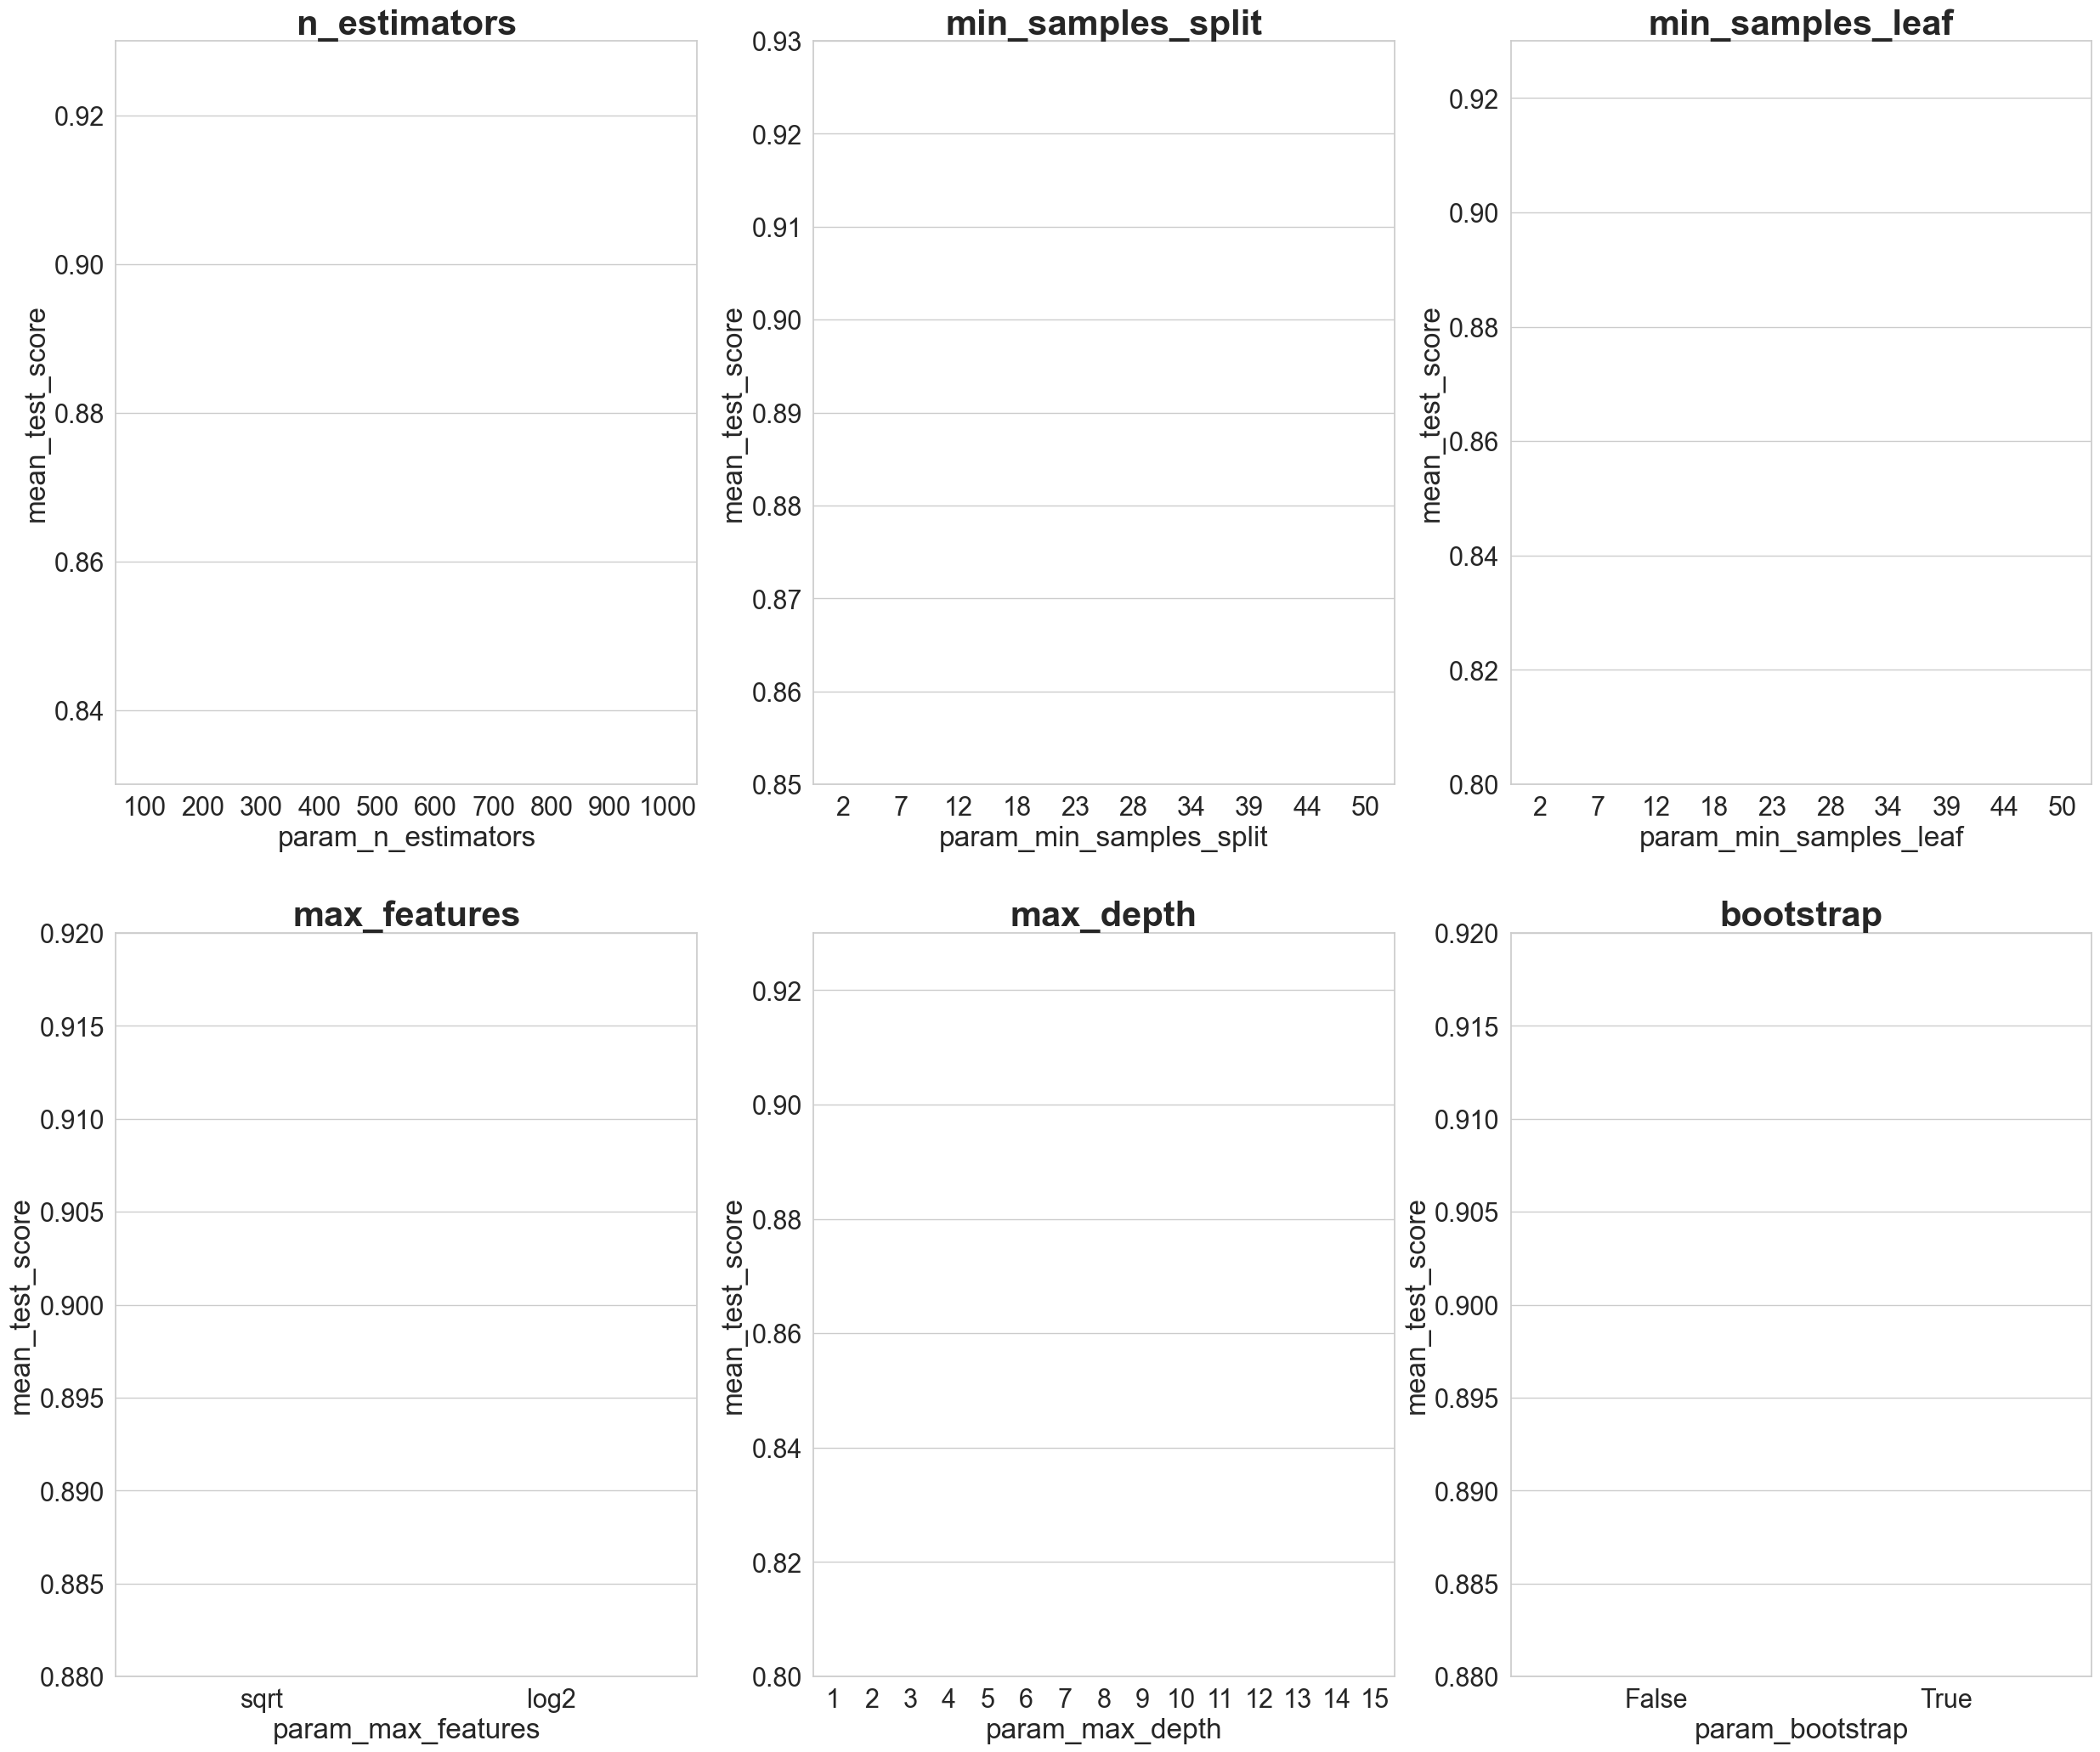

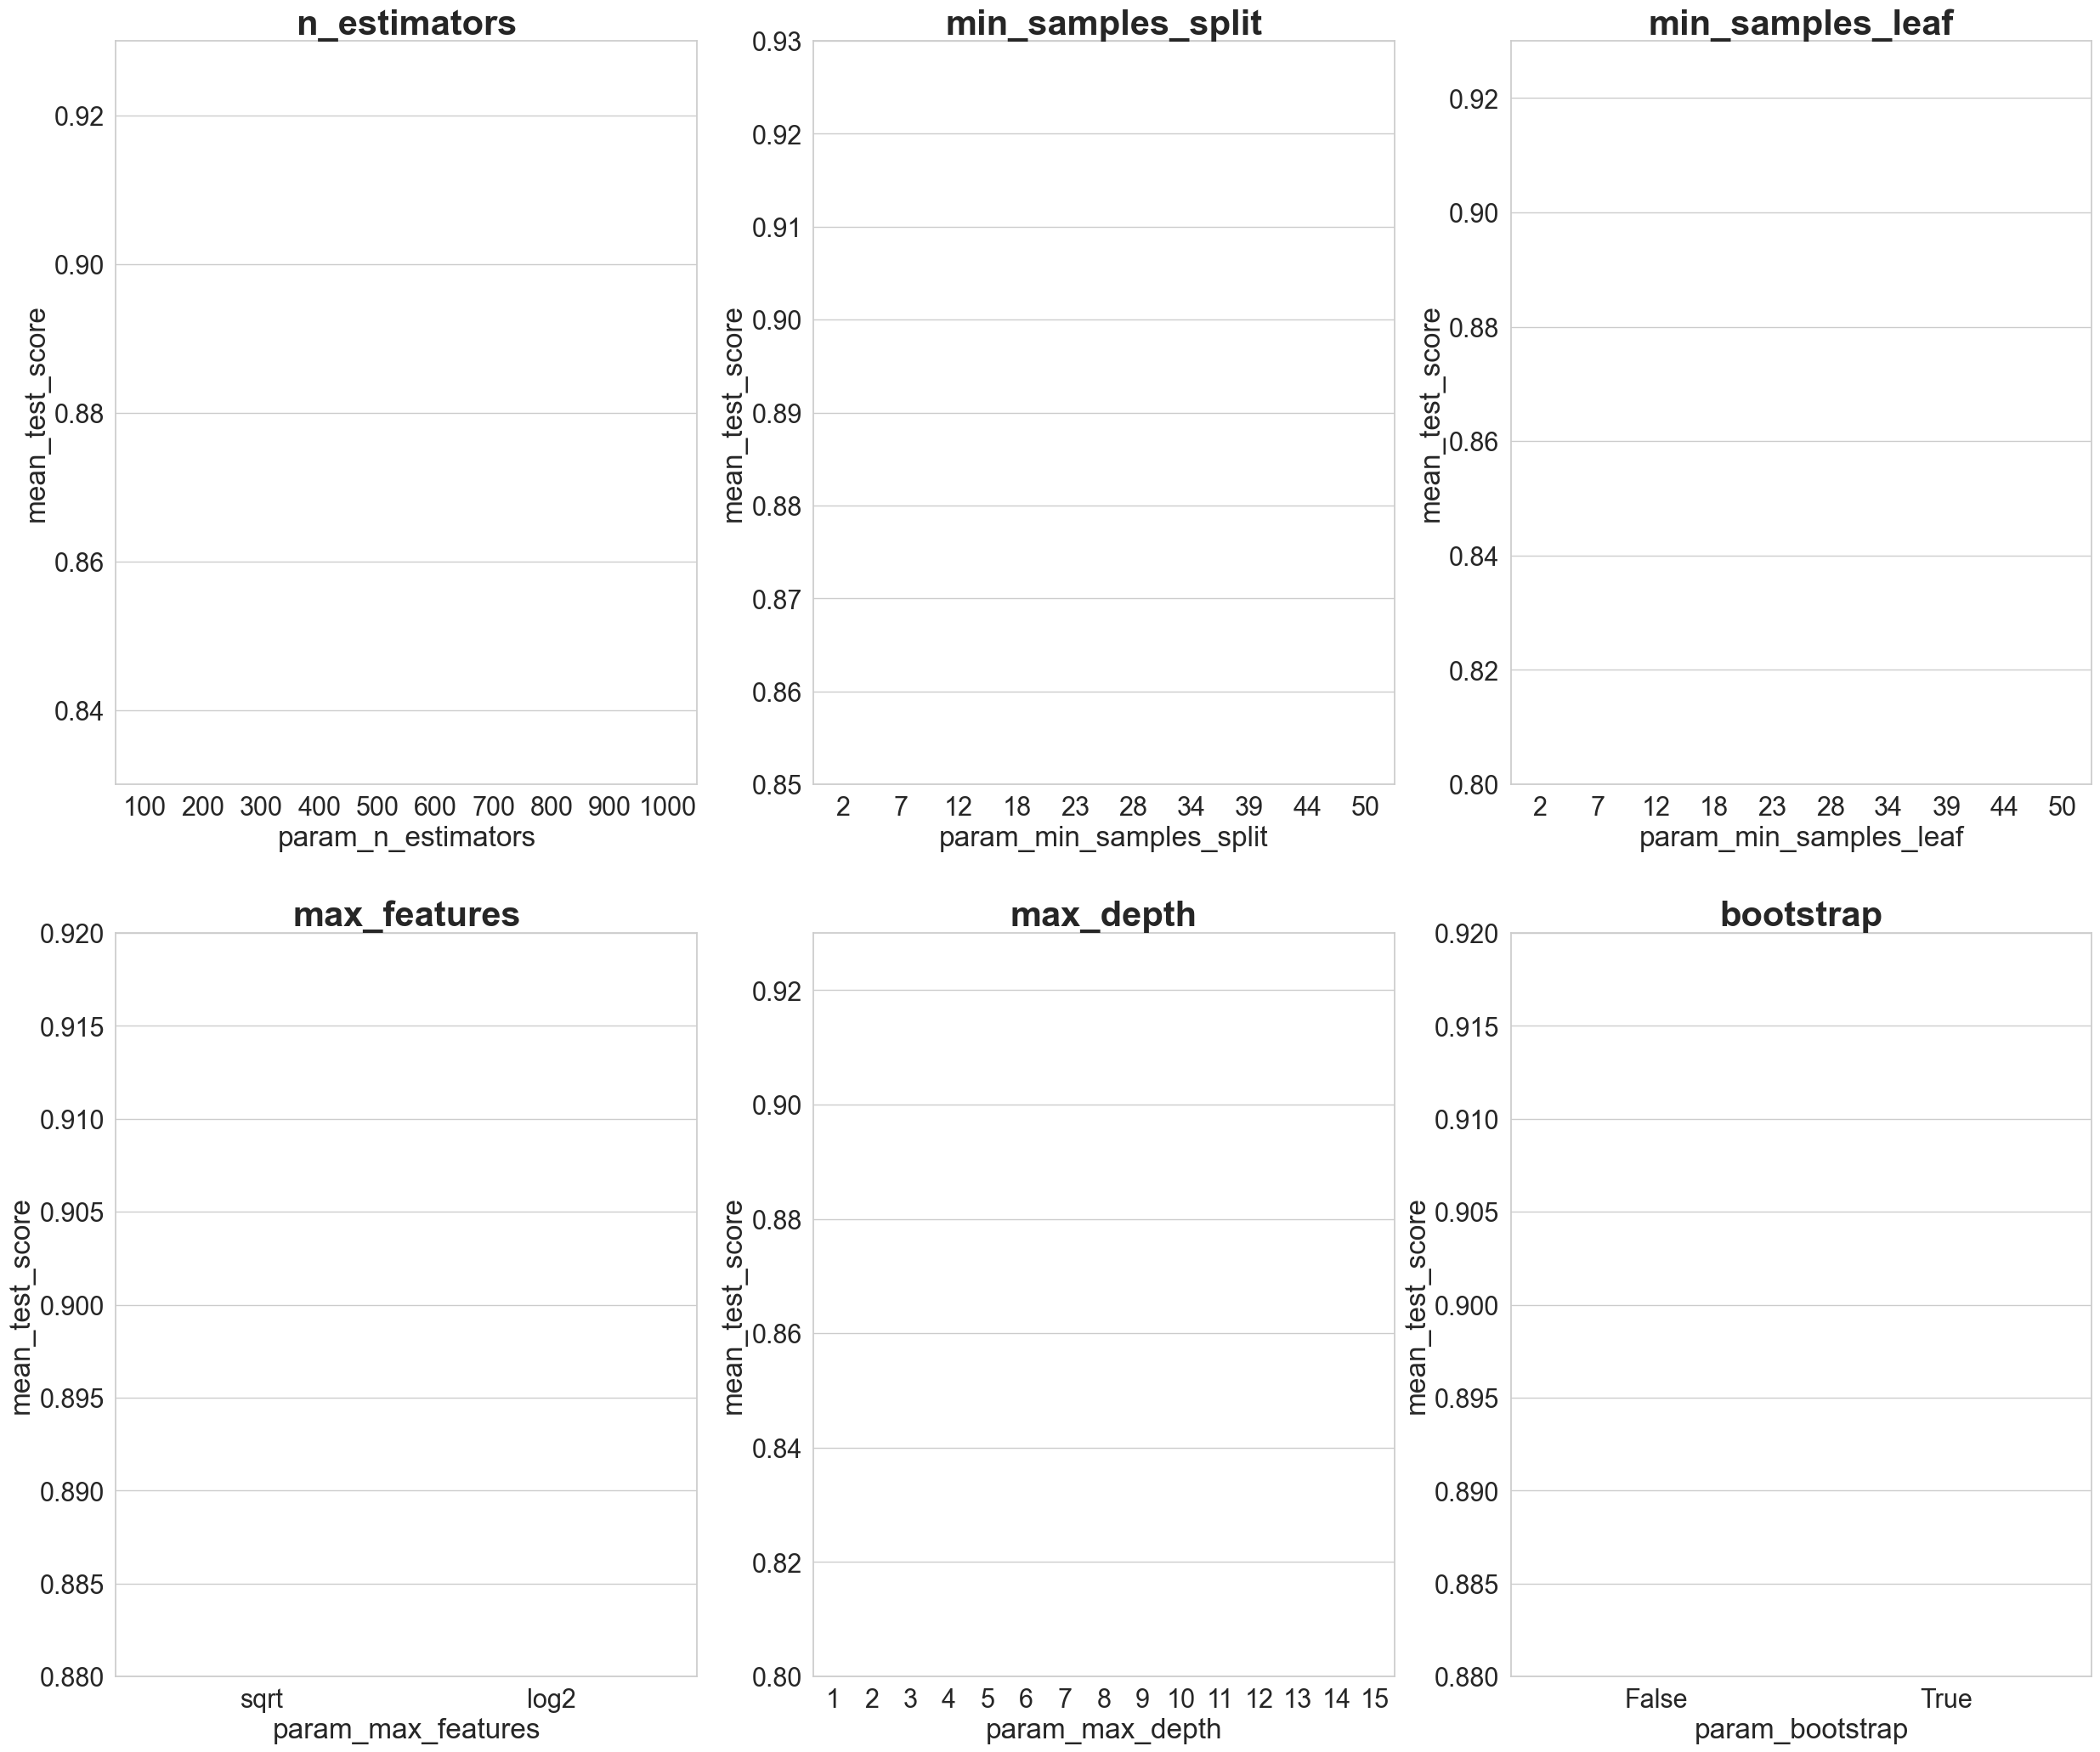

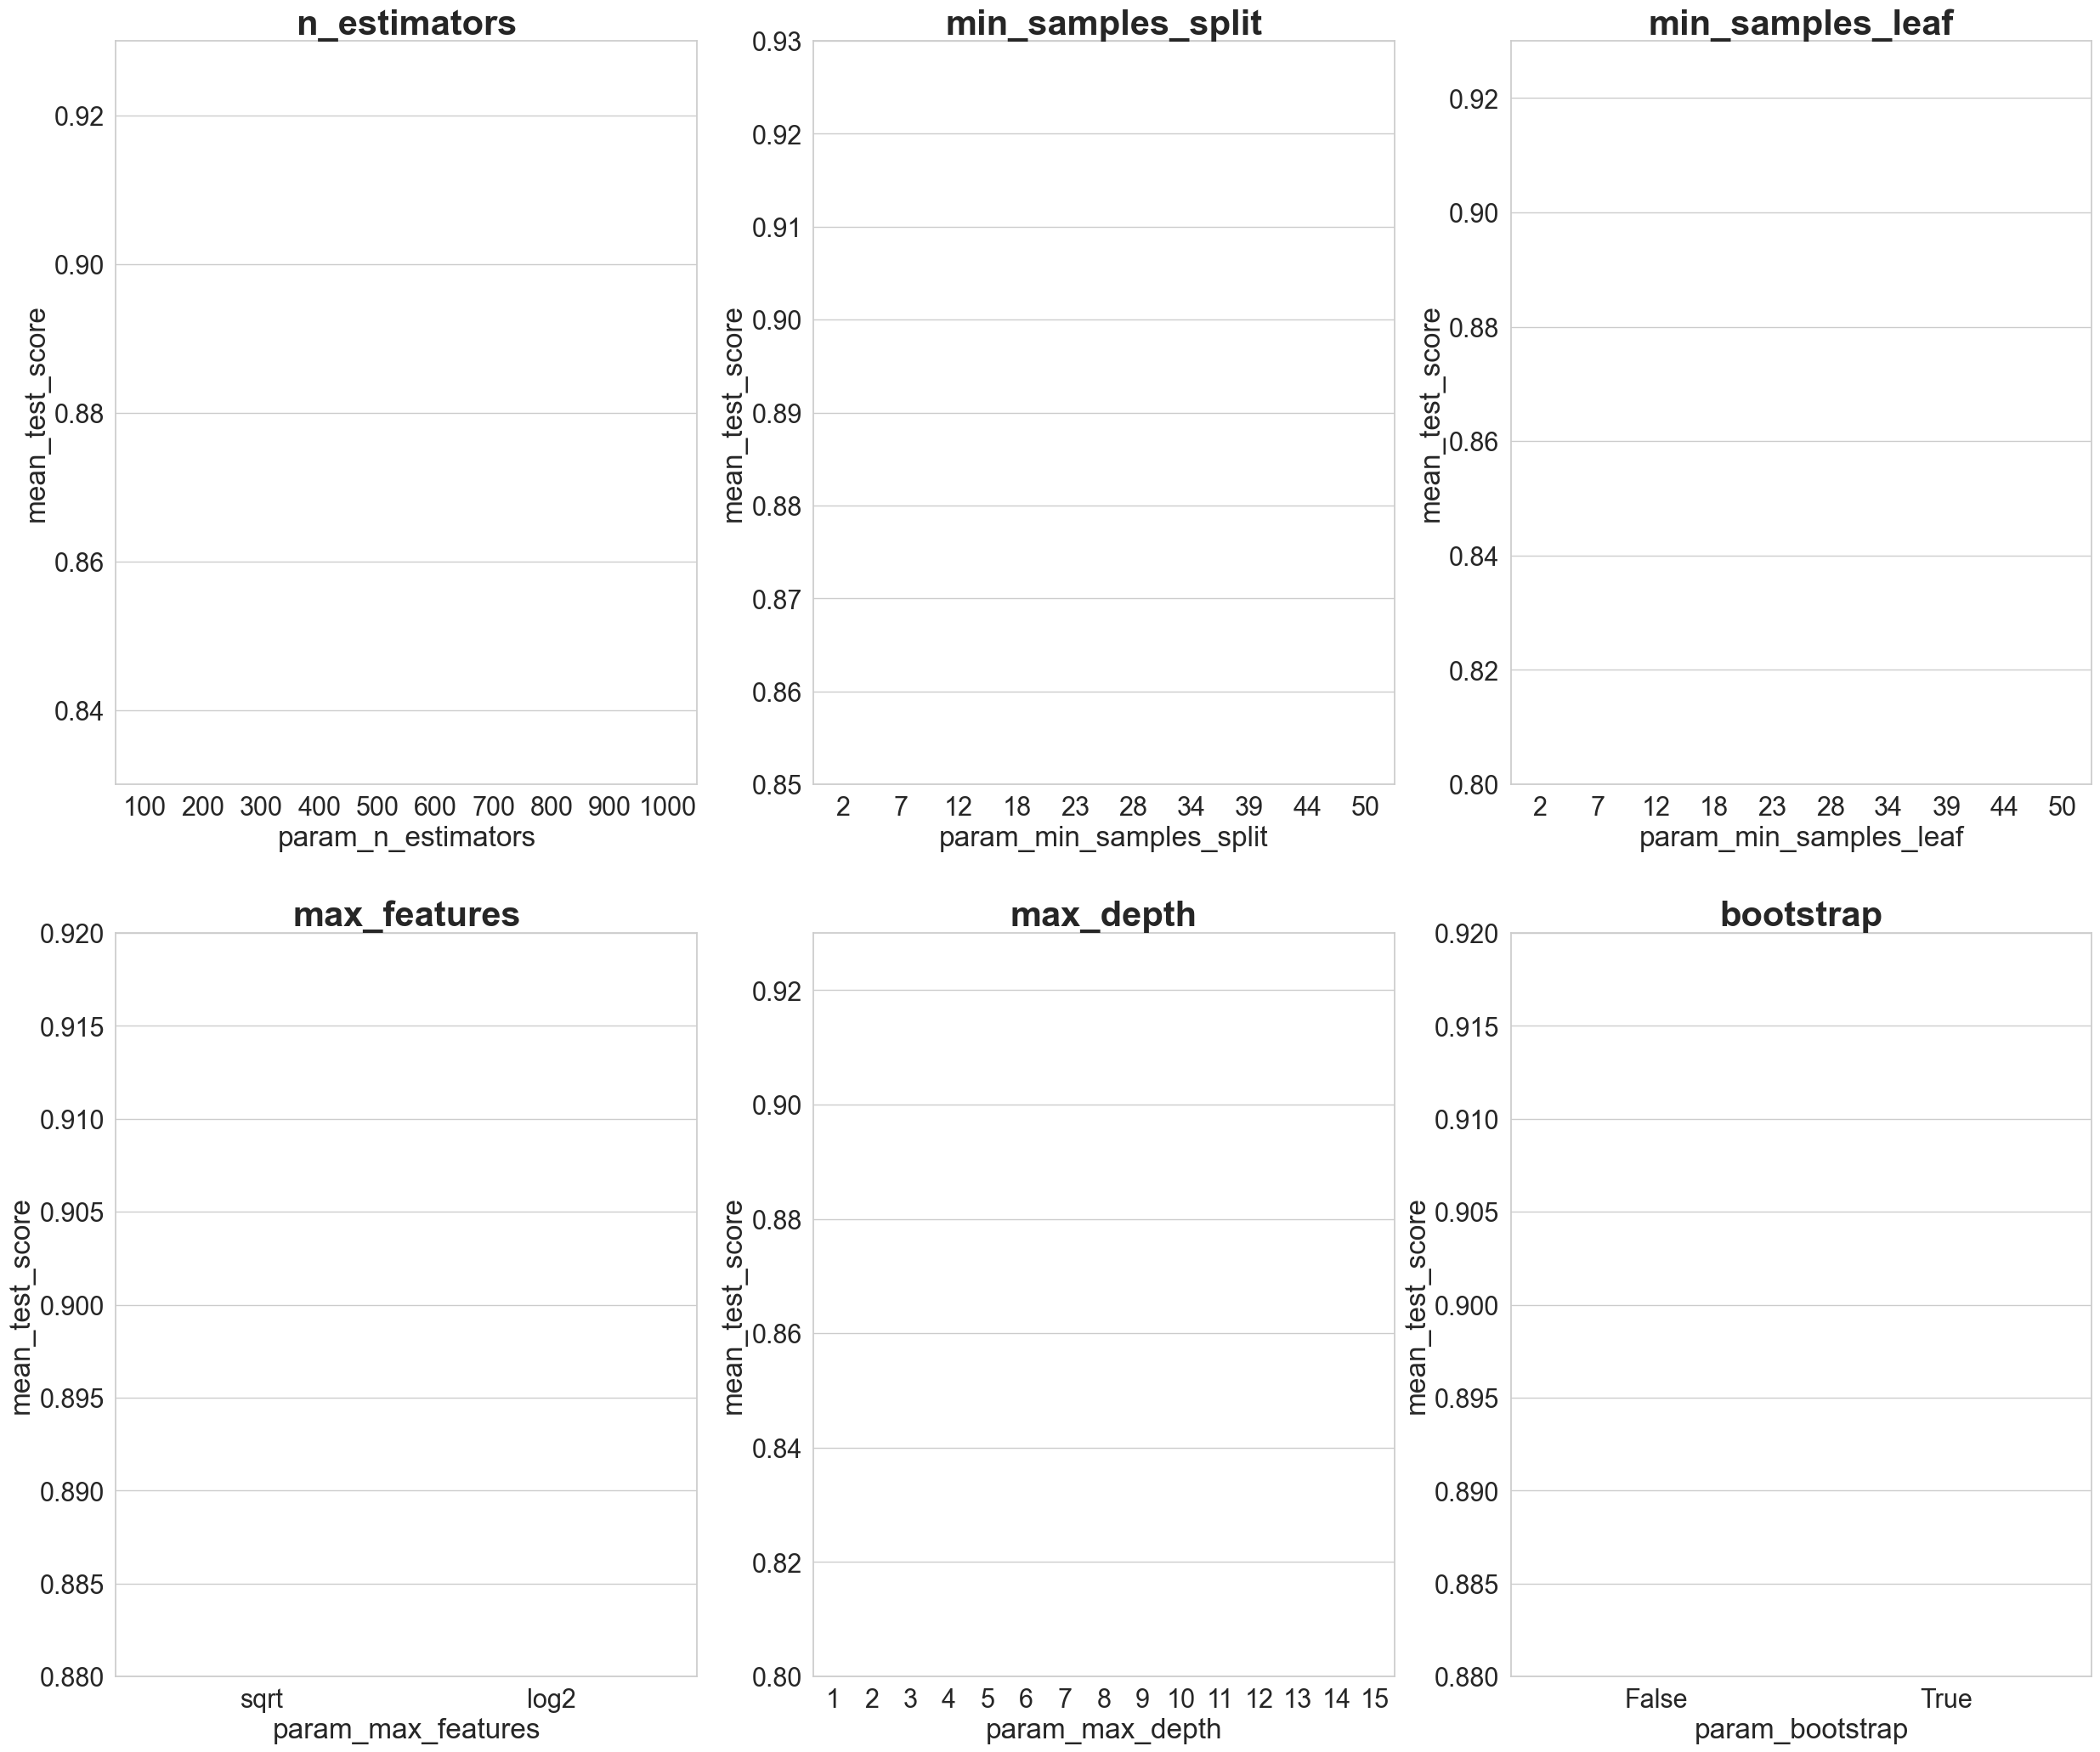

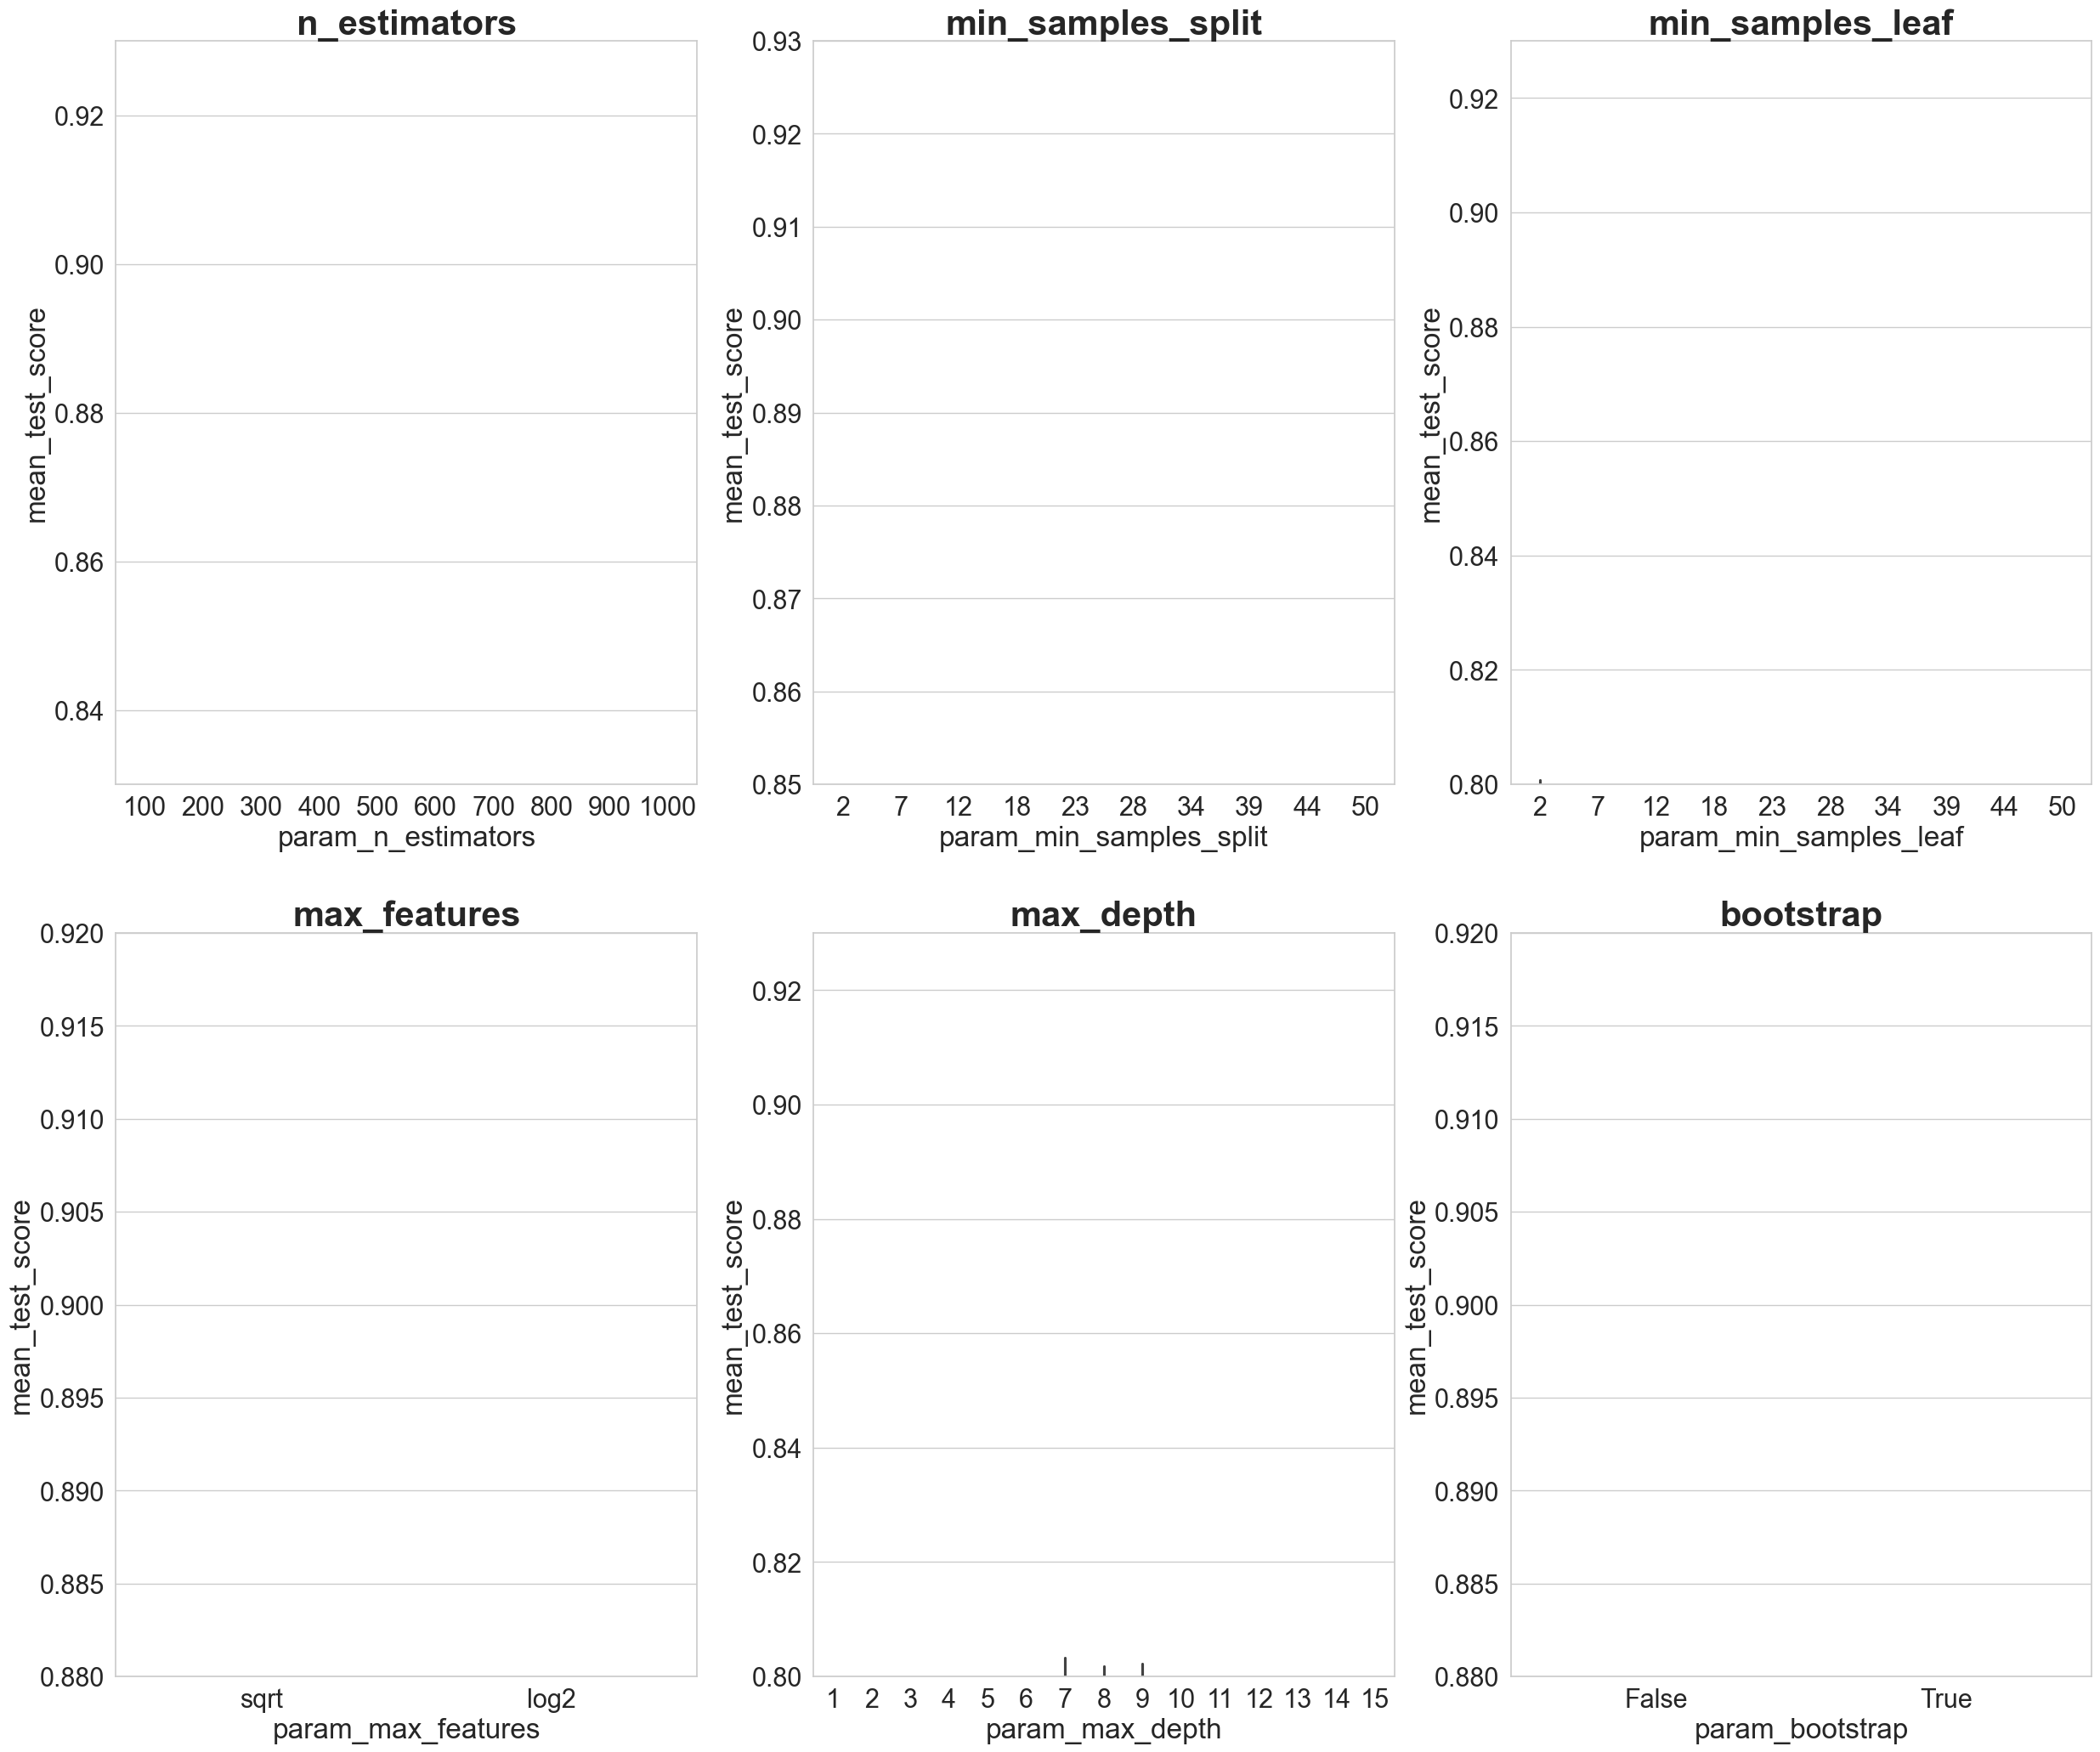

In [67]:
for ticker in ticker_values.columns:
    rs_df = ticker_data[ticker]['randomsearch_df']
    fig, axs = plt.subplots(ncols=3, nrows=2)
    sns.set(style="whitegrid", color_codes=True, font_scale = 2)
    fig.set_size_inches(30,25)
    sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
    axs[0,0].set_ylim([.83,.93])
    axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
    sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
    axs[0,1].set_ylim([.85,.93])
    axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
    sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
    axs[0,2].set_ylim([.80,.93])
    axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
    sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
    axs[1,0].set_ylim([.88,.92])
    axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
    sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
    axs[1,1].set_ylim([.80,.93])
    axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
    sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
    axs[1,2].set_ylim([.88,.92])
    axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
    plt.show()

# Simulating and comparing vs CCi30 Predicted Sharpe Portfolios on test data

In [69]:
len_test = len(ticker_data[ticker]['y_test'])
len_test

235

In [70]:
test_prices = ticker_values[-len_test - 1:]
test_prices = test_prices.pct_change().dropna()
test_prices

ADA      AVAX       BNB       BTC      DOGE       ETH  \
date                                                                     
2023-06-25  0.007146  0.040663  0.009879 -0.002352  0.007442  0.010574   
2023-06-26 -0.039821 -0.034038 -0.014821 -0.009744 -0.044431 -0.023737   
2023-06-27  0.031872  0.017500  0.019595  0.018515  0.026122  0.024238   
2023-06-28 -0.067891 -0.064511 -0.034910 -0.019165 -0.046260 -0.034941   
2023-06-29  0.017290  0.023344  0.011569  0.009259  0.012080  0.011542   
...              ...       ...       ...       ...       ...       ...   
2024-02-10  0.019967  0.058127 -0.002776  0.013019 -0.001838  0.005326   
2024-02-11 -0.017945 -0.012429 -0.007455  0.011368 -0.002455  0.002815   
2024-02-12  0.032853  0.031966  0.022282  0.033777  0.012431  0.060867   
2024-02-13 -0.025733 -0.030488 -0.009359 -0.004202 -0.014102 -0.007126   
2024-02-14  0.059244  0.063145  0.028557  0.042448  0.054994  0.051450   

                LINK       SOL       TRX       XRP  
date                                                
2023-06-25  0.001379  0.021227  0.015758  0.008532  
2023-06-26 -0.013863 -0.049204 -0.000519 -0.031706  
2023-06-27  0.031299  0.049936  0.017159  0.019758  
2023-06-28 -0.061352 -0.052728 -0.013062 -0.042090  
2023-06-29  0.011905  0.105691  0.010602  0.020554  
...              ...       ...       ...       ...  
2024-02-10  0.033009  0.019727  0.006467 -0.004180  
2024-02-11  0.055526 -0.014578 -0.002410  0.004198  
2024-02-12  0.016377  0.039542  0.006441  0.010260  
2024-02-13 -0.029297  0.007518  0.015200 -0.013165  
2024-02-14  0.019115  0.040330  0.021277  0.025920  

[235 rows x 10 columns]

In [71]:
pred_prices = pd.DataFrame()
for ticker in ticker_values.columns:    
    pred_prices = pd.concat([pred_prices, pd.DataFrame(ticker_data[ticker]['y_pred'], columns=[ticker])], axis=1)

pred_prices = pd.concat([ticker_values[-len_test - 1:-len_test], pred_prices], ignore_index=True)

In [72]:
pred_prices = pred_prices.pct_change().dropna()
pred_prices

ADA      AVAX       BNB       BTC      DOGE       ETH      LINK  \
1    0.000278  0.002049  0.027900 -0.001975  0.010738 -0.000296  0.007002   
2    0.006355  0.018399 -0.003225 -0.003750  0.002783  0.002559  0.014702   
3   -0.007893 -0.012203 -0.007223 -0.002903 -0.058240 -0.012965 -0.020148   
4    0.003731  0.019344  0.014213  0.015904  0.020642  0.007456  0.029425   
5   -0.042675 -0.034270 -0.015765 -0.014880 -0.039012 -0.020830 -0.034116   
..        ...       ...       ...       ...       ...       ...       ...   
231  0.040674  0.014106  0.008990  0.045141  0.026024  0.081316  0.078595   
232  0.014625  0.221537  0.000491  0.018923  0.006217  0.003928  0.035262   
233 -0.006554 -0.027734 -0.001513  0.012963 -0.001058  0.006035  0.025648   
234  0.007271  0.018635  0.001120  0.036378 -0.001879  0.023364  0.006497   
235 -0.004885 -0.022068  0.000979  0.003252 -0.003486 -0.007882 -0.021966   

          SOL       TRX       XRP  
1    0.001659 -0.017704  0.001699  
2   -0.007461  0.048268 -0.000374  
3   -0.019466 -0.021526 -0.018573  
4    0.003992  0.045774  0.015741  
5   -0.005220 -0.005020 -0.058301  
..        ...       ...       ...  
231  0.019004  0.009572  0.004583  
232  0.016704 -0.000491 -0.002686  
233 -0.017064  0.001268  0.005064  
234  0.087788  0.000095  0.014037  
235  0.004232  0.002239 -0.015104  

[235 rows x 10 columns]

In [73]:
currencies = weekly_returns.columns
NUM_PF = 100000 # no of portfolios to simulate 100000
n_obs, n_currencies = pred_prices.shape
n_currencies, n_obs

(10, 235)

In [74]:
mean_returns = pred_prices.mean()
cov_matrix = pred_prices.cov()
precision_matrix = pd.DataFrame(inv(cov_matrix), index=currencies, columns=currencies)

In [75]:
cov_matrix

ADA      AVAX       BNB       BTC      DOGE       ETH      LINK  \
ADA   0.002163  0.000575  0.000301  0.000478  0.000391  0.000361  0.000849   
AVAX  0.000575  0.002928  0.000081  0.000574  0.000467  0.000227  0.000769   
BNB   0.000301  0.000081  0.000402  0.000181  0.000130  0.000166  0.000167   
BTC   0.000478  0.000574  0.000181  0.000758  0.000251  0.000369  0.000571   
DOGE  0.000391  0.000467  0.000130  0.000251  0.000842  0.000246  0.000471   
ETH   0.000361  0.000227  0.000166  0.000369  0.000246  0.000673  0.000458   
LINK  0.000849  0.000769  0.000167  0.000571  0.000471  0.000458  0.002687   
SOL   0.001008  0.001125  0.000209  0.000736  0.000379  0.000548  0.001214   
TRX   0.000080  0.000093  0.000020  0.000078  0.000109  0.000101  0.000175   
XRP   0.000982  0.000333  0.000260  0.000565  0.000559  0.000532  0.000819   

           SOL       TRX       XRP  
ADA   0.001008  0.000080  0.000982  
AVAX  0.001125  0.000093  0.000333  
BNB   0.000209  0.000020  0.000260  
BTC   0.000736  0.000078  0.000565  
DOGE  0.000379  0.000109  0.000559  
ETH   0.000548  0.000101  0.000532  
LINK  0.001214  0.000175  0.000819  
SOL   0.003370  0.000154  0.000930  
TRX   0.000154  0.000285  0.000273  
XRP   0.000930  0.000273  0.004249

In [76]:
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=False):
    alpha = np.full(shape=n_currencies, fill_value=.05)
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    if short:
        weights *= choice([-1, 1], size=weights.shape)

    returns = weights @ mean_ret.values + 1
    #returns = returns ** periods_per_year - 1
    std = (weights @ cov_matrix).std(1)
    #std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std
    return pd.DataFrame({'Standard Deviation': std,
                         'Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

In [78]:
from tqdm import tqdm

port_real_return = []

for day in tqdm(range(n_obs), desc='PF generation', unit='day'):
    simul_perf, simul_wt = simulate_portfolios(pred_prices.iloc[day], cov_matrix, short=False)
    max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
    sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
    #print(f'Max Sharpe: {sd:.2%}, {r:.2%}')
    port_real_return.append(np.sum(test_prices.iloc[day] * simul_wt[max_sharpe_idx]))

PF generation: 100%|█████████████████████████| 235/235 [00:20<00:00, 11.59day/s]


In [79]:
cci30_cum_ret = df_cci30[-n_obs:][['cum_returns']]
cci30_cum_ret = cci30_cum_ret.reset_index()

port_real_cum_return = pd.DataFrame(port_real_return, columns=['ret'])
port_real_cum_return['cum_returns'] = pd.DataFrame(1 + port_real_cum_return['ret']).cumprod()-1

In [80]:
port_real_cum_return

ret  cum_returns
0    0.014262     0.014262
1   -0.007482     0.006673
2    0.018411     0.025207
3   -0.023857     0.000749
4    0.011261     0.012018
..        ...          ...
230  0.004208     0.618596
231 -0.004879     0.610698
232  0.012934     0.631531
233  0.001730     0.634354
234  0.025796     0.676513

[235 rows x 2 columns]

In [81]:
cci30_cum_ret

index  cum_returns
0     1002     0.788236
1     1003     0.767270
2     1004     0.793864
3     1005     0.732118
4     1006     0.766263
..     ...          ...
230   1232     1.794418
231   1233     1.804996
232   1234     1.905715
233   1235     1.873981
234   1236     1.974105

[235 rows x 2 columns]

<Axes: title={'center': 'Daily vs Cumulative'}, xlabel='Day', ylabel='return rate'>

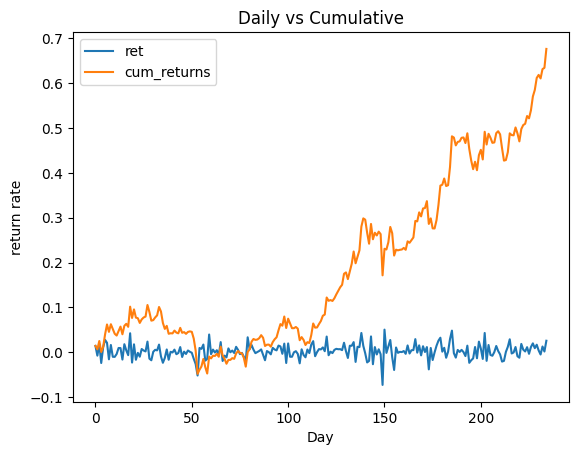

In [82]:

port_real_cum_return.plot(title='Daily vs Cumulative', xlabel='Day', ylabel='return rate')

<Axes: title={'center': 'RandomForest vs CCi30'}, xlabel='Date'>

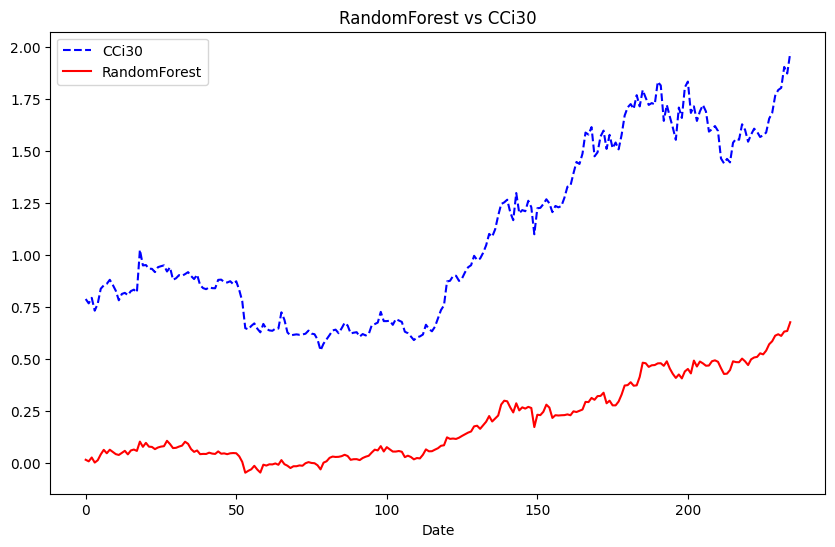

In [83]:
cci30_cum_ret['cum_returns'].plot(color='b', figsize=(10, 6), legend=True, label='CCi30', linestyle="dashed")
port_real_cum_return['cum_returns'].plot(title='RandomForest vs CCi30', color='r',legend=True, label='RandomForest', xlabel='Date')
